# Connect Forest Management Model with Forest Carbon Budget Model

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
import pickle
import libcbm
import os
from util_opt import compile_events, cbm_report, compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_emissionstock, run_scenario, plugin_c_curves, plugin_c_curves_both, cbm_report_both, compare_ws3_cbm, compare_ws3_cbm_both, track_system_stock, track_system_emission, compile_scenario_minemission, plot_scenario_minemission, kpi_age, kpi_species, cmp_c_ss, cmp_c_se, results_scenarios, bootstrap_ogi, compare_kpi_age

In [2]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
max_harvest = 1.0

In [3]:
# Define scenario options based on case study
scenario_options = {
    'redchris': ['no_cons','evenflow_cons',  'bau_redchrs', 'redchrs_AAC_90%', 'redchrs_AAC_80%', 'redchrs_AAC_70%', 'redchrs_AAC_60%', 'redchrs_AAC_50%', 'redchrs_AAC_40%', 'redchrs_AAC_30%', 'redchrs_AAC_20%', 'redchrs_AAC_10%' ],
    'goldenbear': ['no_cons', 'evenflow_cons', 'bau_gldbr', 'gldbr_AAC_90%', 'gldbr_AAC_80%', 'gldbr_AAC_70%', 'gldbr_AAC_60%', 'gldbr_AAC_50%', 'gldbr_AAC_40%', 'gldbr_AAC_30%', 'gldbr_AAC_20%', 'gldbr_AAC_10%'],
    'equitysilver': [ 'no_cons','evenflow_cons', 'bau_eqtslvr', 'eqtslvr_AAC_90%', 'eqtslvr_AAC_80%', 'eqtslvr_AAC_70%', 'eqtslvr_AAC_60%', 'eqtslvr_AAC_50%', 'eqtslvr_AAC_40%', 'eqtslvr_AAC_30%', 'eqtslvr_AAC_20%', 'eqtslvr_AAC_10%'],
    'test': ['no_cons', 'evenflow_cons', 'bau_redchrs']
}

# Function to handle case study selection and update scenario dropdown
def select_case_study(case_study):
    print(f"Selected case study: {case_study}")
    # Update the scenario dropdown based on the selected case study
    scenario_dropdown.options = scenario_options.get(case_study, [])
    scenario_dropdown.value = scenario_options[case_study][0]  # Set a default value

# Case study dropdown
case_study_dropdown = widgets.Dropdown(
    options=['redchris', 'goldenbear', 'equitysilver', 'test'],
    value='redchris',
    description='Case Study:'
)
case_study_dropdown.observe(lambda change: select_case_study(change['new']), names='value')
display(case_study_dropdown)

# Function to handle scenario selection
def select_scenario(scenario_name):
    print(f"Selected scenario: {scenario_name}")

# Scenario dropdown
scenario_dropdown = widgets.Dropdown(
    options=scenario_options['redchris'],  # Set initial options based on default case study
    value=scenario_options['redchris'][1],  # Set initial value
    description='Scenario:'
)
scenario_dropdown.observe(lambda change: select_scenario(change['new']), names='value')
display(scenario_dropdown)

# Function to handle objective functon
def select_obj(obj_mode):
    print(f"Selected objective: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='max_hv',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Case Study:', options=('redchris', 'goldenbear', 'equitysilver', 'test'), value='redchri…

Dropdown(description='Scenario:', index=1, options=('no_cons', 'evenflow_cons', 'bau_redchrs', 'redchrs_AAC_90…

Dropdown(description='Objective:', options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='max_hv')

In [4]:
# Initialize main widget components 
hwp_pool_effect = widgets.FloatSlider(min=0, max=1, step=1, description='HWP_effect', value=1, layout=widgets.Layout(margin='10px 0'))
release_immediately = widgets.FloatSlider(min=0, max=1, step=1, description='Release immediately', value=1, layout=widgets.Layout(margin='10px 0'))
displacement_effect = widgets.FloatSlider(min=0, max=1, step=1, description='Displacement', value=1, layout=widgets.Layout(margin='10px 0'))
clt_percentage = widgets.FloatSlider(min=0, max=1, step=0.1, description='CLT_percent:', value=0.5, layout=widgets.Layout(margin='10px 0'))
credibility = widgets.FloatSlider(min=0, max=1, step=0.1, description='Credibility:', value=1, layout=widgets.Layout(margin='10px 0'))
# max_harvest = widgets.FloatSlider(min=0, max=1, step=0.05, description='Max_harvest:', value=1.0, layout=widgets.Layout(margin='10px 0'))
budget_input = widgets.FloatText(value=10000000, description='Budget:', layout=widgets.Layout(margin='10px 0'))

release_immediately.layout.display = 'none' if hwp_pool_effect.value != 0 else 'block'
displacement_effect.layout.display = 'block' if hwp_pool_effect.value != 0 else 'none'
clt_percentage.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'
credibility.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'

container = widgets.VBox([
    hwp_pool_effect, release_immediately, displacement_effect, clt_percentage, credibility, budget_input  
    # ,max_harvest
])

display(container)

def update_widgets(change):
    hwp_pool_effect_value = hwp_pool_effect.value
    displacement_effect_value = displacement_effect.value

    release_immediately.layout.display = 'block' if hwp_pool_effect_value == 0 else 'none'
    displacement_effect.layout.display = 'block' if hwp_pool_effect_value != 0 else 'none'

    clt_percentage.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'
    credibility.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'

hwp_pool_effect.observe(update_widgets, names='value')
displacement_effect.observe(update_widgets, names='value')

In [5]:
#Start Calculating the Running Time
Start = time.time()

In [6]:
case_study = case_study_dropdown.value
scenario_name = scenario_dropdown.value
obj_mode = obj_dropdown.value
hwp_pool_effect_value = hwp_pool_effect.value
release_immediately_value = release_immediately.value if hwp_pool_effect_value == 0 else 0
displacement_effect = displacement_effect.value if hwp_pool_effect_value != 0 else 0
clt_percentage = clt_percentage.value if displacement_effect != 0 else 0
credibility = credibility.value if displacement_effect != 0 else 0
# max_harvest = max_harvest.value
budget_input = budget_input.value

In [7]:
# Define case study mappings and retrieve model details based on case study
case_study_options = {
    'redchris': {
        'model_name': 'redchris',
        'model_path': './data/woodstock_model_files_redchris'
    },
    'goldenbear': {
        'model_name': 'goldenbear',
        'model_path': './data/woodstock_model_files_goldenbear'
    },
    'equitysilver': {
        'model_name': 'equitysilver',
        'model_path': './data/woodstock_model_files_equitysilver'
    },
    'test': {
        'model_name': 'redchris',
        'model_path': './data/woodstock_model_files_redchris_test'
    }
}

model_info = case_study_options.get(case_study)

if model_info:
    model_name = model_info['model_name']
    model_path = model_info['model_path']
else:
    print('The case study name is not valid')


In [8]:
# Create and Run `ForestModel` instance
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=model_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()
fm.grow()

In [9]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

In [10]:
# Read curves
file_directory = "./inputs/curves"
file_names = [f"{case_study}_c_curves_p.pkl", f"{case_study}_c_curves_f.pkl"]
loaded_data = {}

for filename in file_names:
    file_path = os.path.join(file_directory, filename)
    with open(file_path, 'rb') as file:
        loaded_data[filename] = pickle.load(file)
    print(f"Loaded data from {file_path}")

c_curves_p = loaded_data.get(f"{case_study}_c_curves_p.pkl")
c_curves_f = loaded_data.get(f"{case_study}_c_curves_f.pkl")

Loaded data from ./inputs/curves/goldenbear_c_curves_p.pkl
Loaded data from ./inputs/curves/goldenbear_c_curves_f.pkl


In [11]:
# Plug carbon and old groth yield curves into forest model
plugin_c_curves_both(fm, c_curves_p, c_curves_f)
bootstrap_ogi(fm)

Running for goldenbear_max_hv_no_cons...
running no_cons scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-09
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3905 rows, 36130 columns and 36130 nonzeros
Model fingerprint: 0xcba9c472
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3905 rows and 36130 columns
Presolve time: 0.07s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0306528e+07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.08 seconds (0.01 work units)
Optimal objective  2.030652838e+07


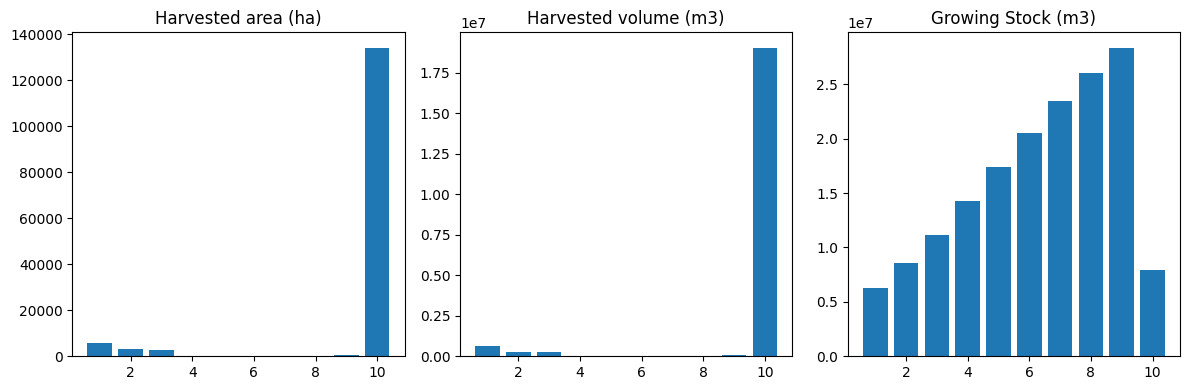

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_no_cons_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  21468
The economic indicator (the provincial government revenues) is:  732113
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


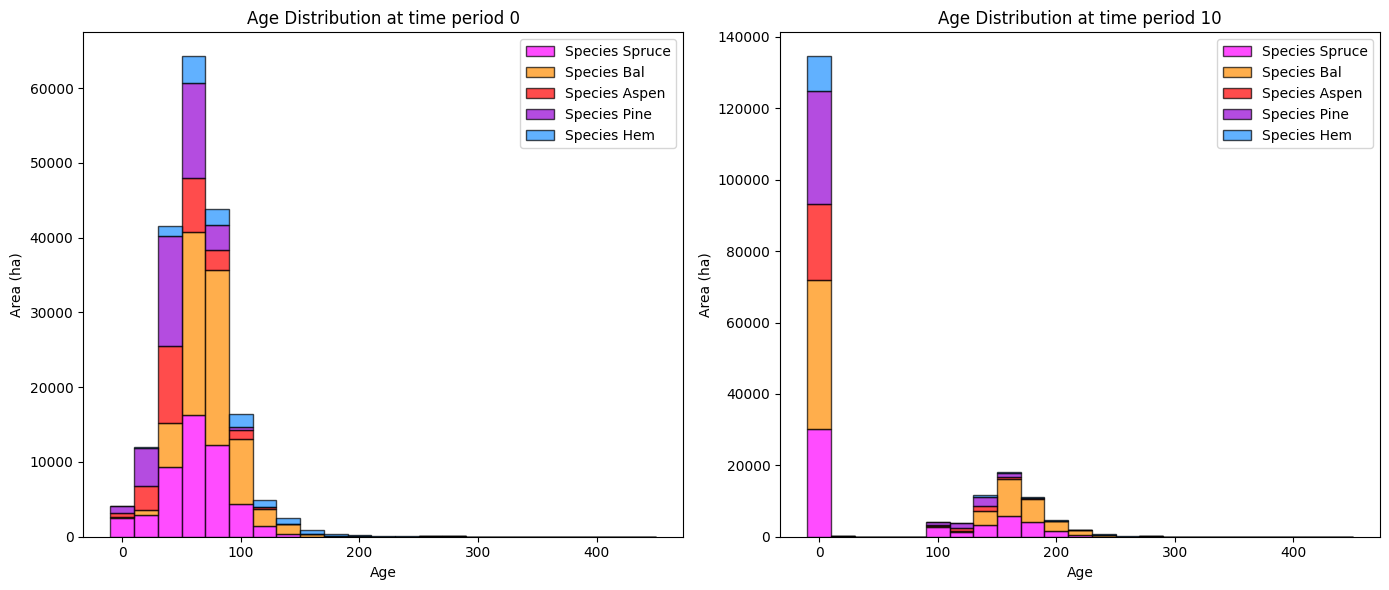

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_no_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  3485.893305  3483.184771
Bal     278.565372  7368.335601  7089.770229
Aspen   273.490478  2022.195583  1748.705105
Pine      0.000000  1070.013440  1070.013440
Hem     419.699331   705.040396   285.341065

Overall diversity has **increased** by 13677.01 hectares from time period 0 to time period 10.


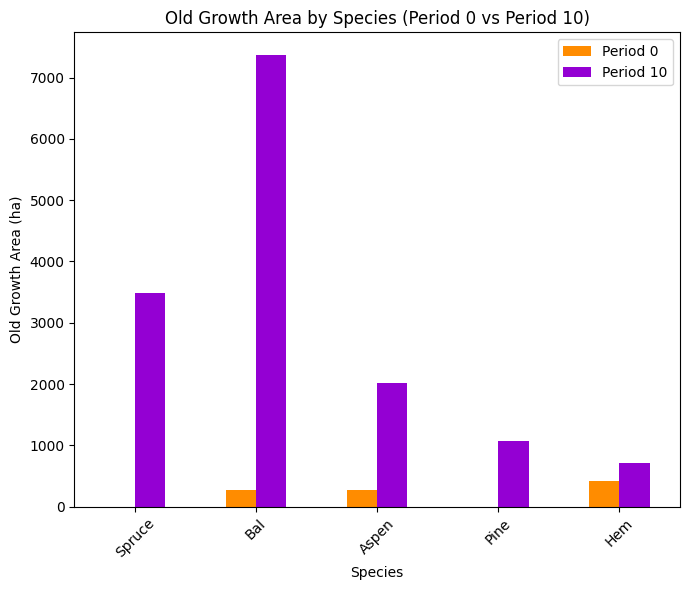

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_no_cons_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.3010
Bal: 0.4772
Aspen: 0.0727
Pine: 0.0965
Hem: 0.0526

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.7987

Diversity has **decreased** by 14.68% from time 0 to time 10.


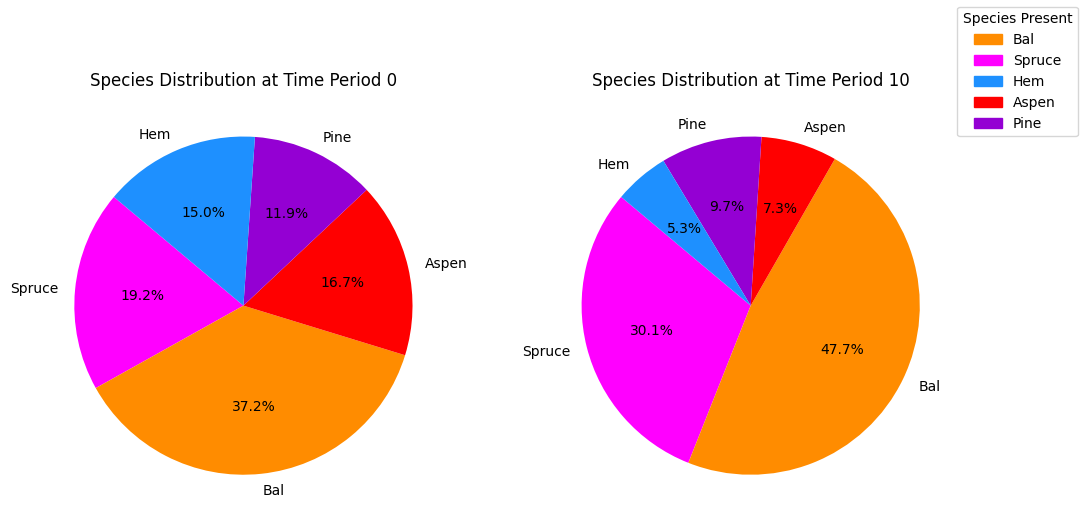

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_no_cons_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xb30b6437
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.19s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Factor Ops

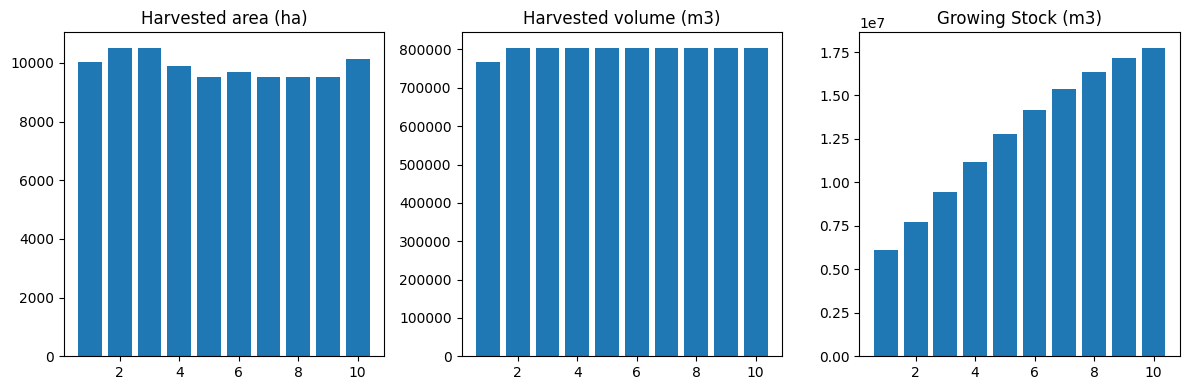

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  8463
The economic indicator (the provincial government revenues) is:  288619
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


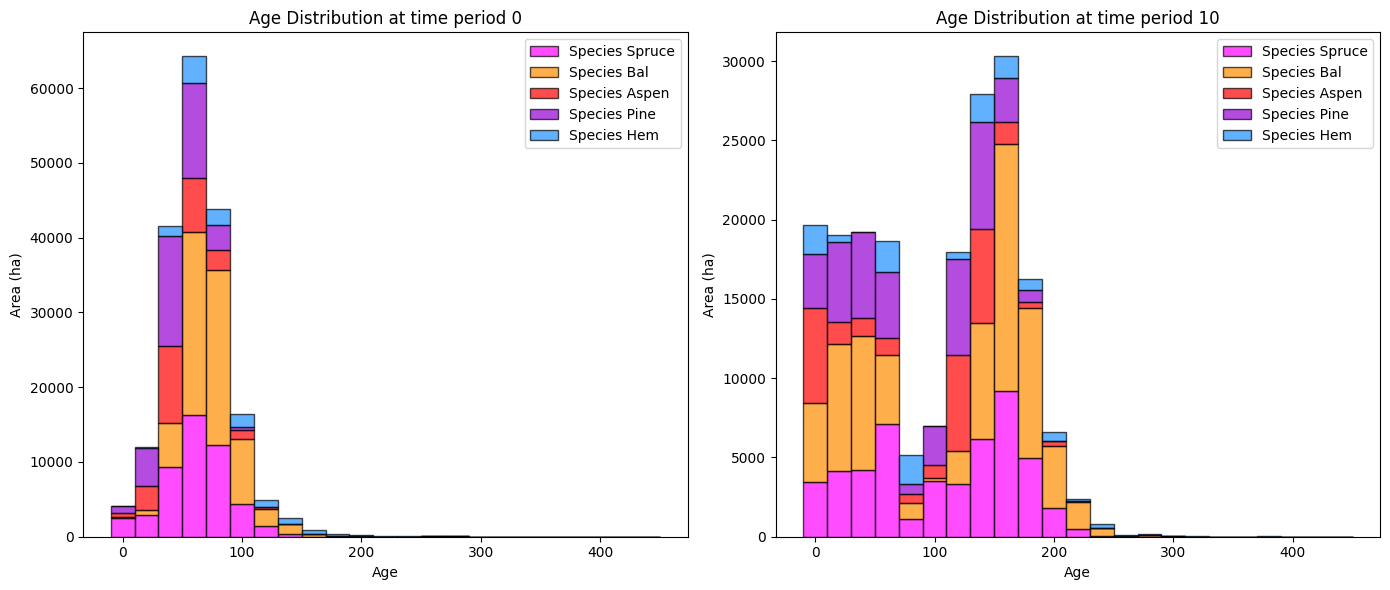

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4624.091497   4621.382963
Bal     278.565372  11130.044561  10851.479189
Aspen   273.490478   6117.315597   5843.825119
Pine      0.000000   3444.407631   3444.407631
Hem     419.699331   1309.461400    889.762069

Overall diversity has **increased** by 25650.86 hectares from time period 0 to time period 10.


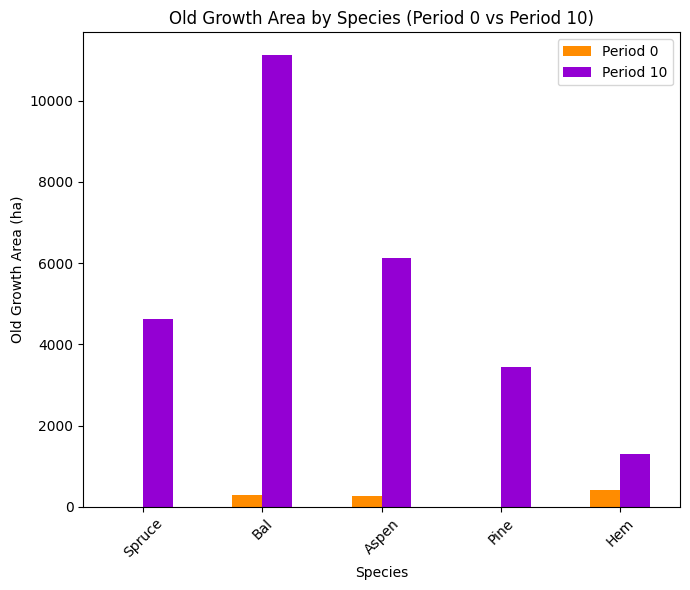

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2509
Bal: 0.3750
Aspen: 0.1338
Pine: 0.1506
Hem: 0.0896

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9228

Diversity has **decreased** by 2.27% from time 0 to time 10.


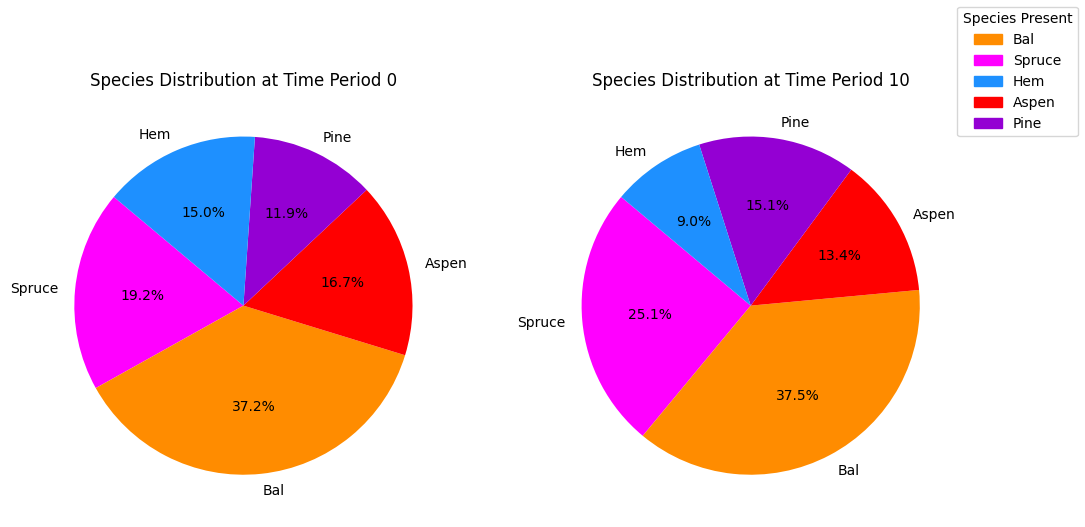

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_species_pie.pdf


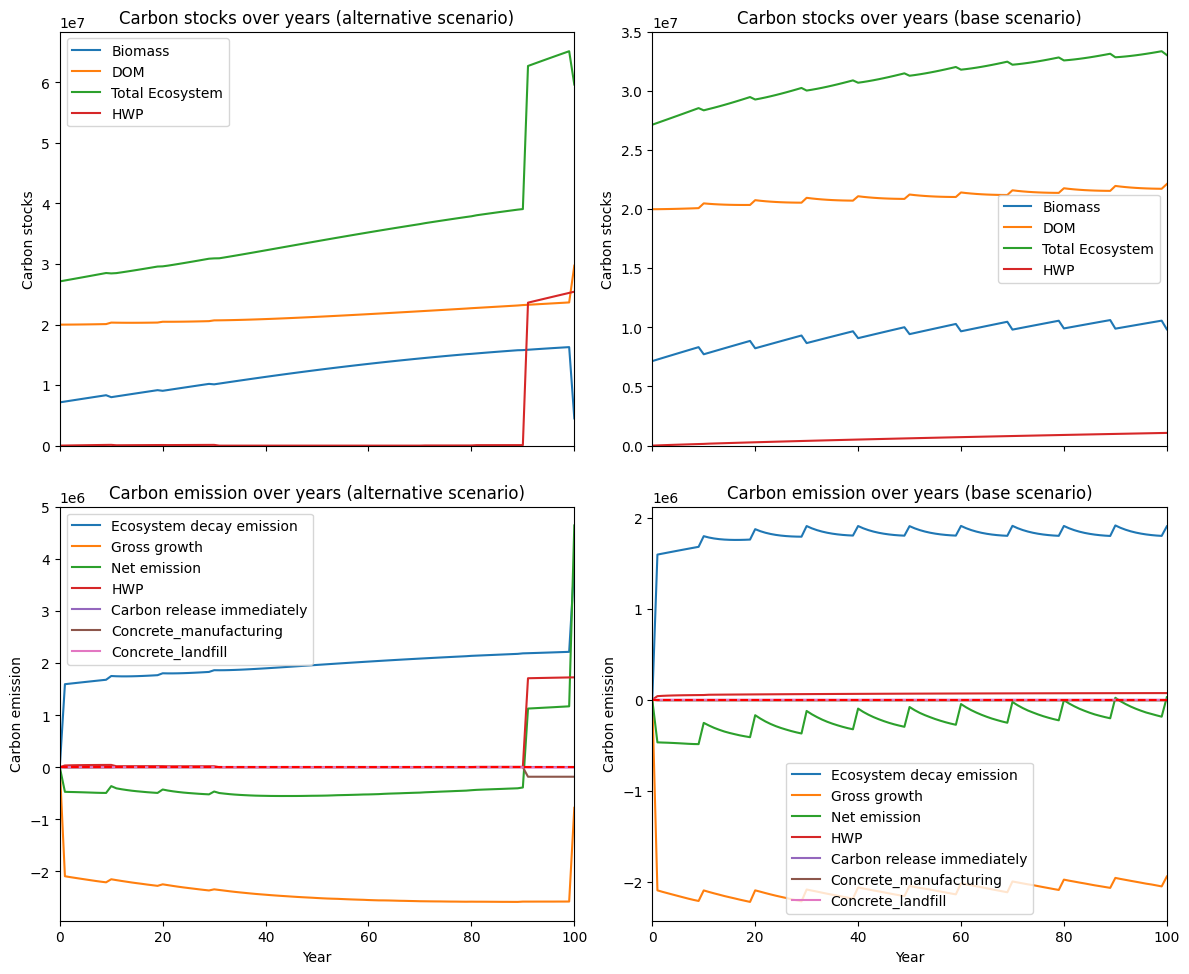

---------------------------------------------------------------------------------------
Net emission difference -2185798.7084171535
Net emission base scenario -11143671.658452034
Net emission alternative scenario -8957872.950034881
dollar_per_ton is:  4.574986690902339
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0 -1138.198192 -1138.198192
Bal     0.0 -3761.708960 -3761.708960
Aspen   0.0 -4095.120015 -4095.120015
Pine    0.0 -2374.394191 -2374.394191
Hem     0.0  -604.421004  -604.421004

Overall, the old growth area has **decreased** by -11973.84 hectares in the alternative scenario compared to the base scenario.


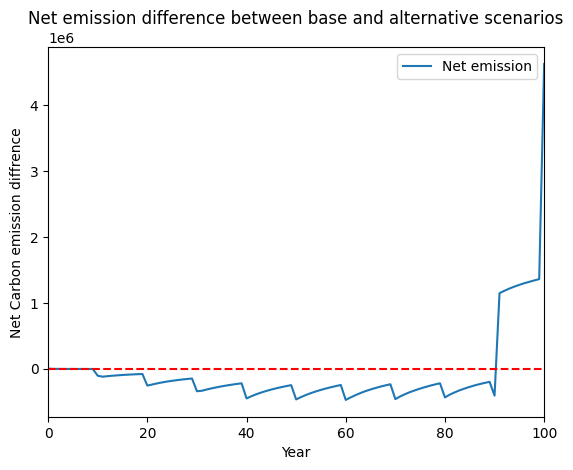

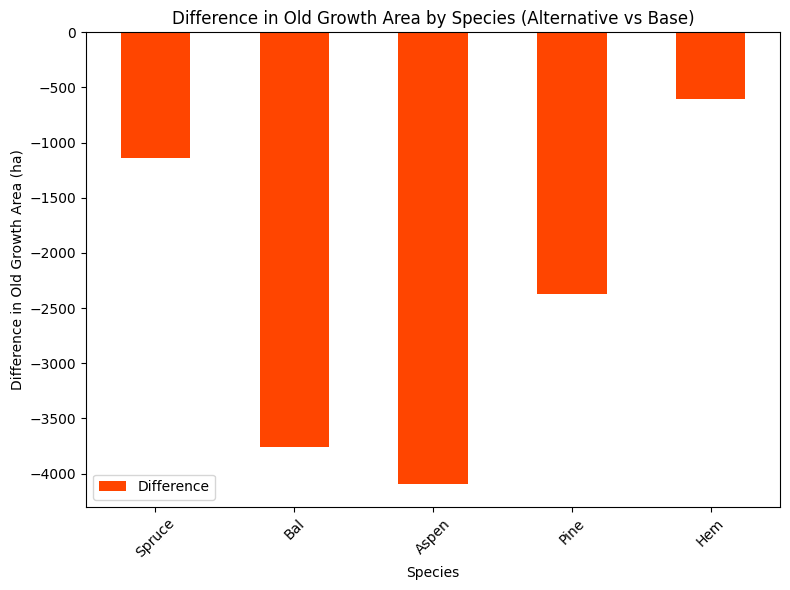

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_age_difference.pdf


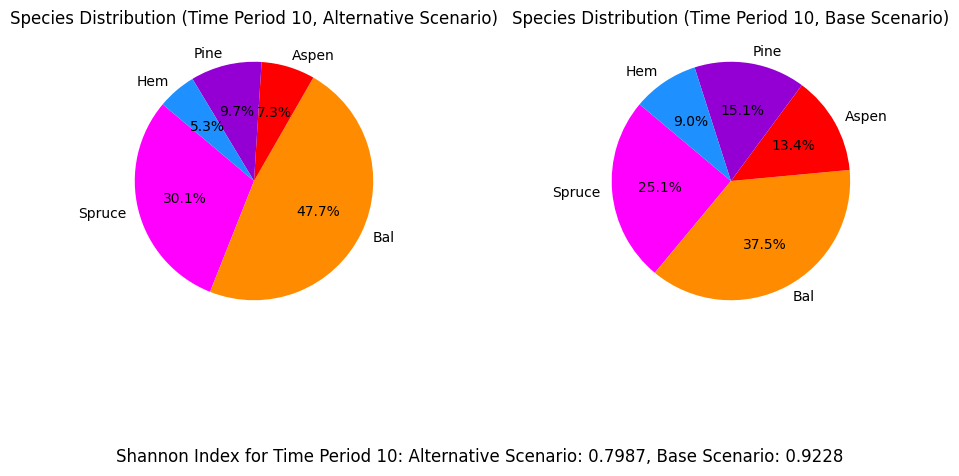

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_hv_evenflow_cons...
running even flow constraints scenario
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3945 rows, 36130 columns and 430076 nonzeros
Model fingerprint: 0x0868b629
Coefficient statistics:
  Matrix range     [1e-02, 9e+04]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2035 rows and 3905 columns
Presolve time: 0.11s
Presolved: 1910 rows, 32225 columns, 401001 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering ti

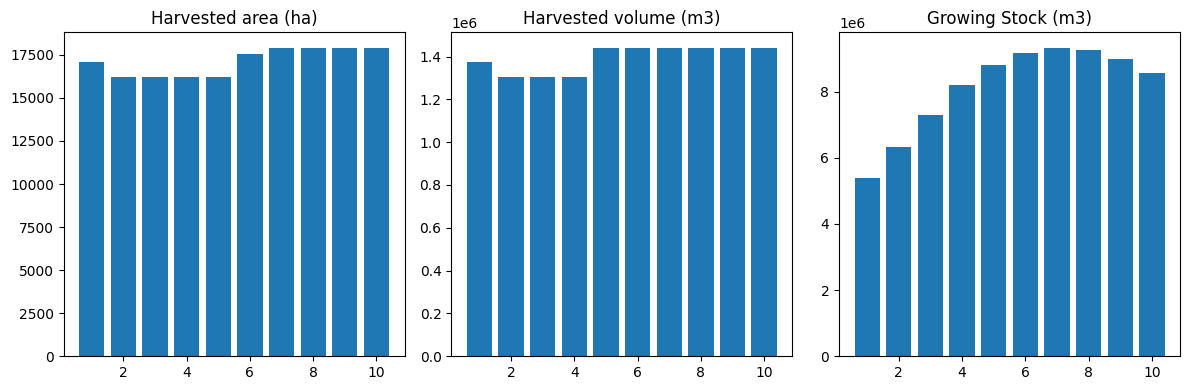

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_evenflow_cons_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  14725
The economic indicator (the provincial government revenues) is:  502182
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


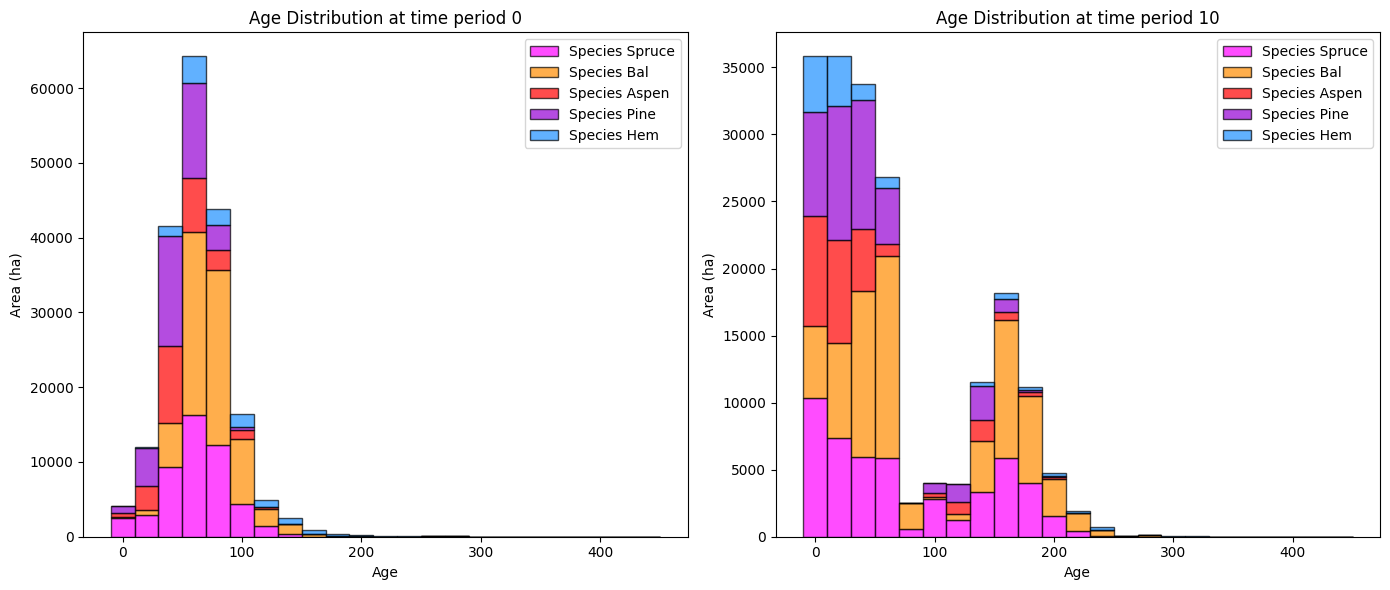

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_evenflow_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  3485.893305  3483.184771
Bal     278.565372  7368.335601  7089.770229
Aspen   273.490478  2022.195583  1748.705105
Pine      0.000000  1070.013440  1070.013440
Hem     419.699331   705.040396   285.341065

Overall diversity has **increased** by 13677.01 hectares from time period 0 to time period 10.


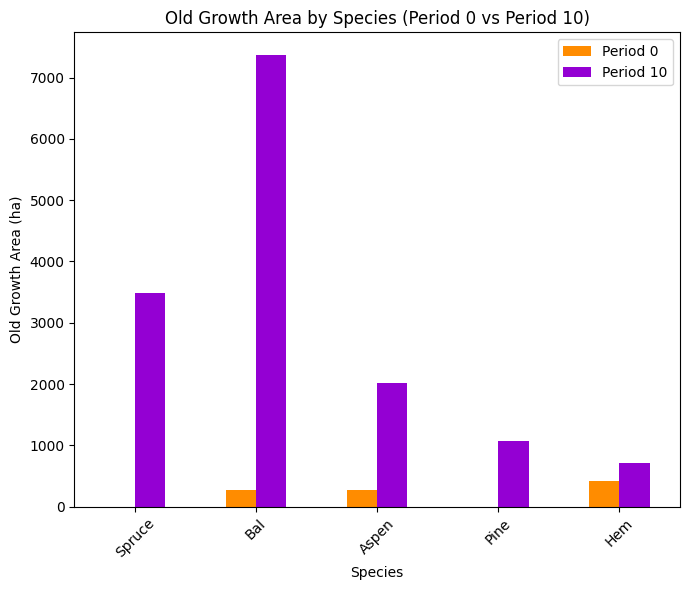

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_evenflow_cons_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2926
Bal: 0.4732
Aspen: 0.0747
Pine: 0.1068
Hem: 0.0526

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8086

Diversity has **decreased** by 13.69% from time 0 to time 10.


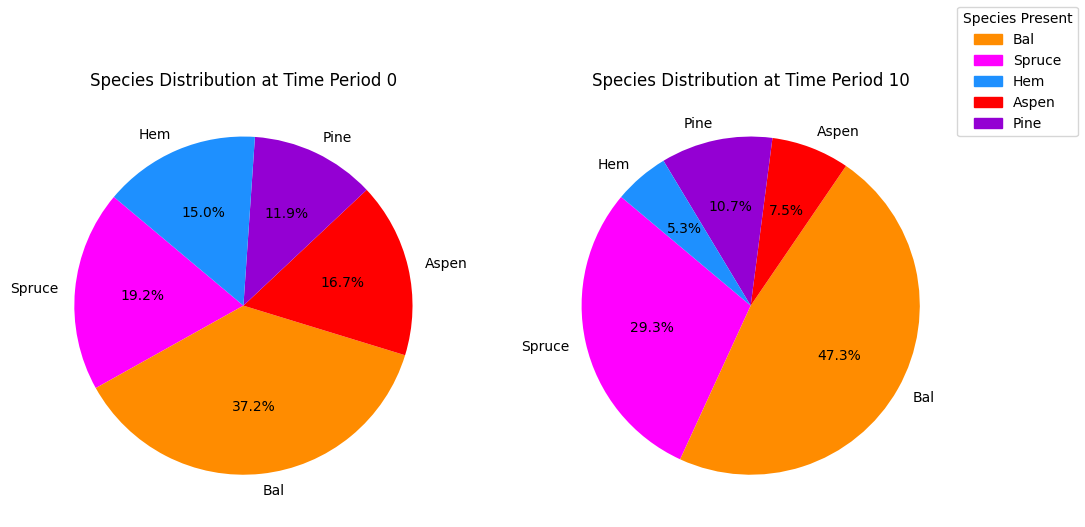

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_evenflow_cons_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xb30b6437
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.17s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

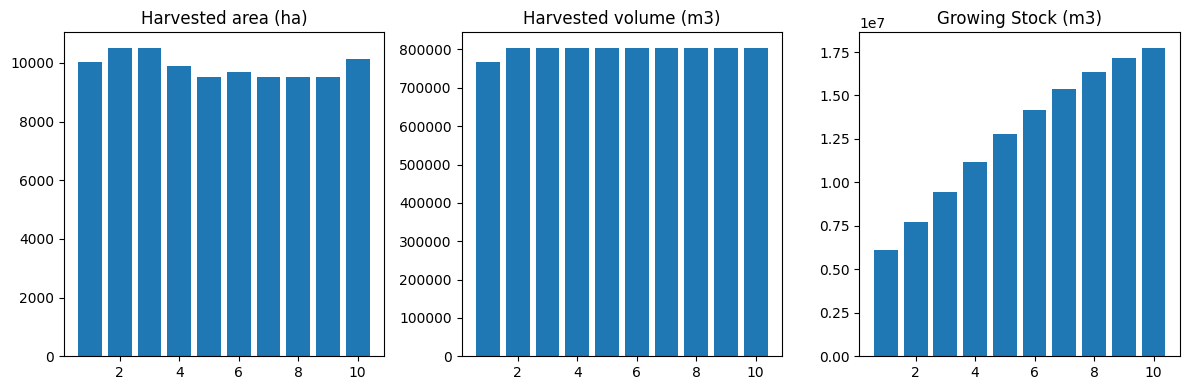

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  8463
The economic indicator (the provincial government revenues) is:  288619
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


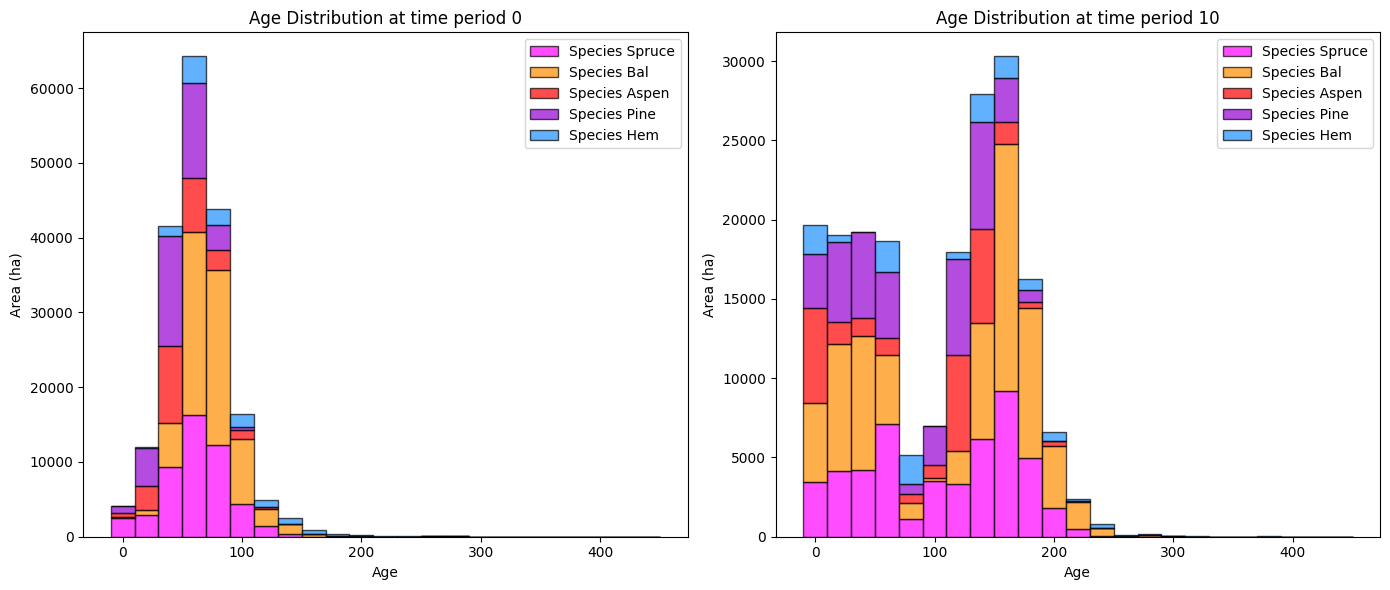

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4624.091497   4621.382963
Bal     278.565372  11130.044561  10851.479189
Aspen   273.490478   6117.315597   5843.825119
Pine      0.000000   3444.407631   3444.407631
Hem     419.699331   1309.461400    889.762069

Overall diversity has **increased** by 25650.86 hectares from time period 0 to time period 10.


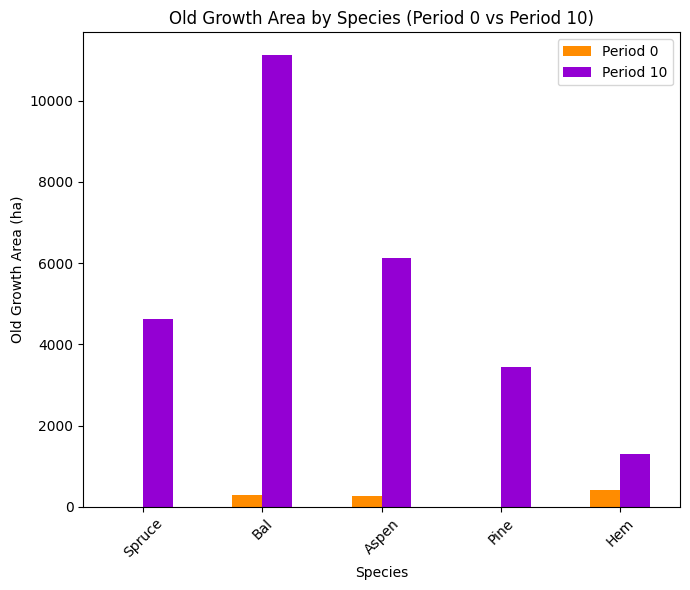

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2509
Bal: 0.3750
Aspen: 0.1338
Pine: 0.1506
Hem: 0.0896

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9228

Diversity has **decreased** by 2.27% from time 0 to time 10.


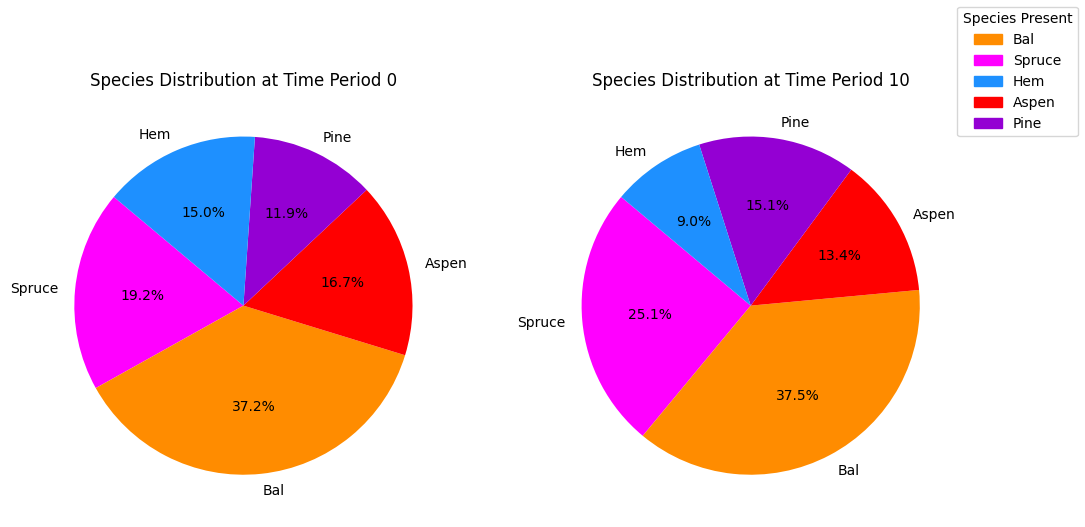

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_species_pie.pdf


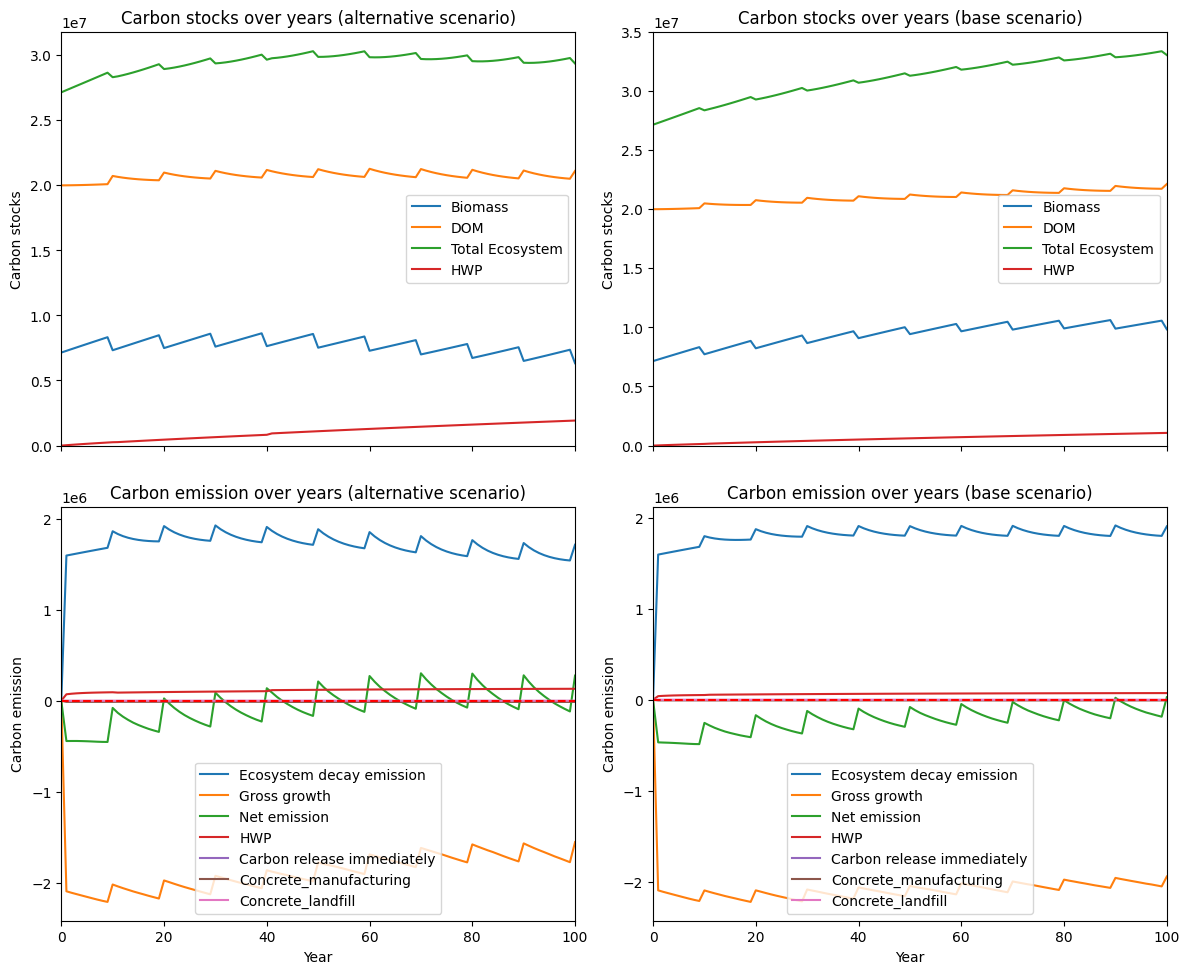

---------------------------------------------------------------------------------------
Net emission difference 2182354.7881276077
Net emission base scenario -6775518.161907273
Net emission alternative scenario -8957872.950034881
dollar_per_ton is:  4.582206364612094
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0 -1138.198192 -1138.198192
Bal     0.0 -3761.708960 -3761.708960
Aspen   0.0 -4095.120015 -4095.120015
Pine    0.0 -2374.394191 -2374.394191
Hem     0.0  -604.421004  -604.421004

Overall, the old growth area has **decreased** by -11973.84 hectares in the alternative scenario compared to the base scenario.


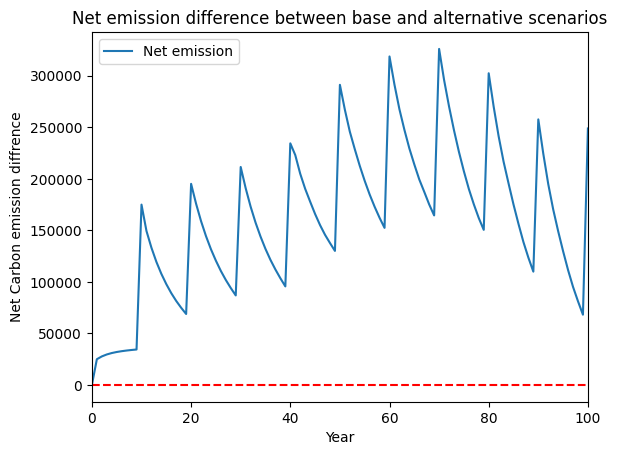

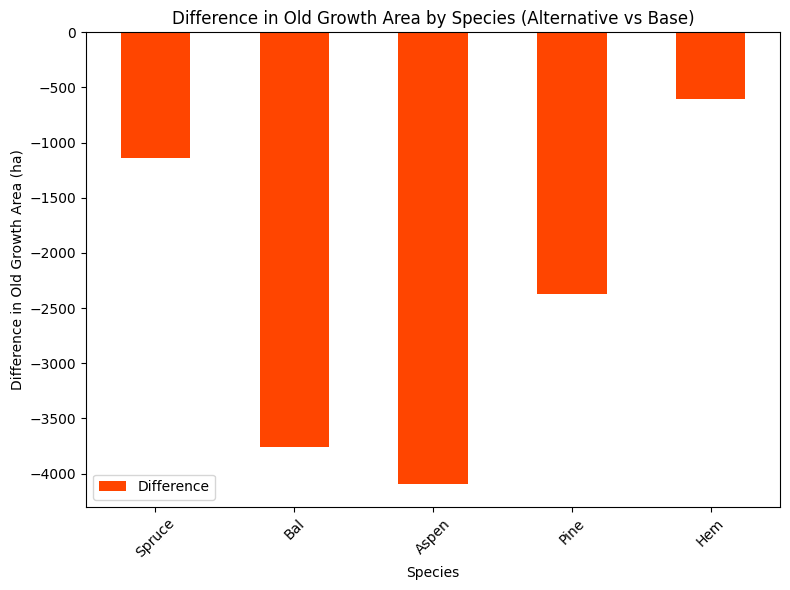

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_age_difference.pdf


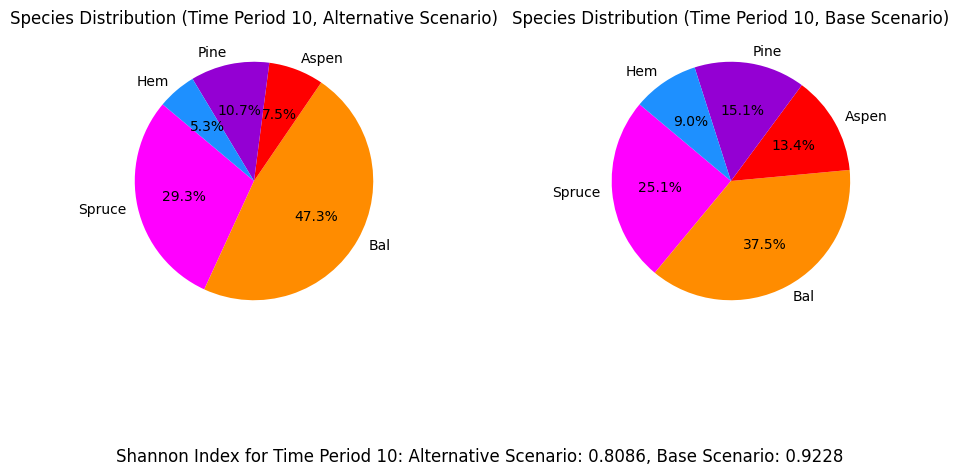

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_hv_bau_gldbr...
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xb30b6437
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.18s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier lo

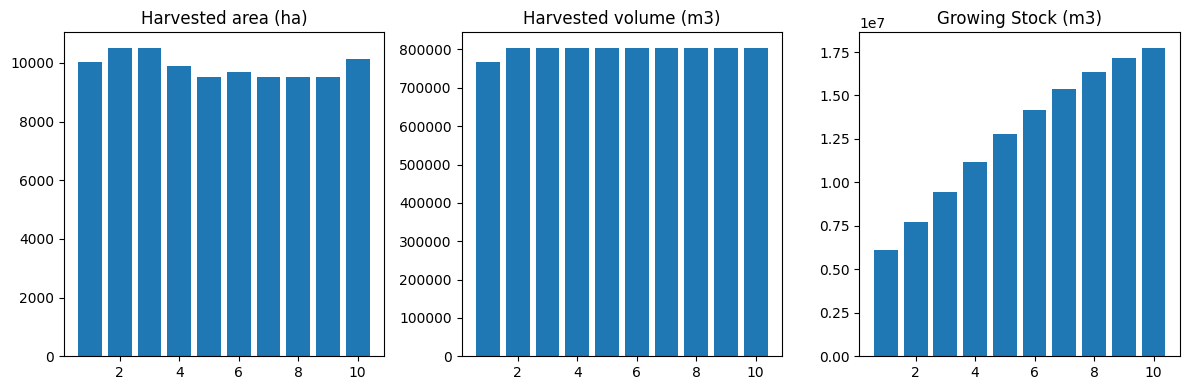

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  8463
The economic indicator (the provincial government revenues) is:  288619
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


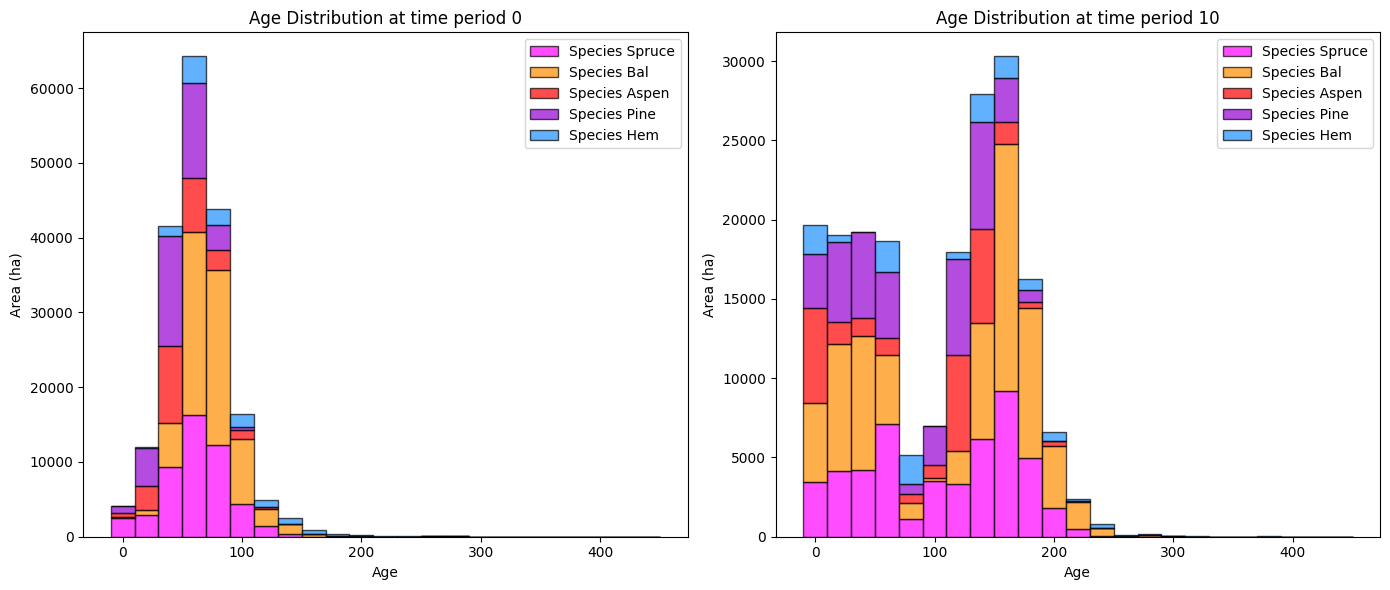

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4624.091497   4621.382963
Bal     278.565372  11130.044561  10851.479189
Aspen   273.490478   6117.315597   5843.825119
Pine      0.000000   3444.407631   3444.407631
Hem     419.699331   1309.461400    889.762069

Overall diversity has **increased** by 25650.86 hectares from time period 0 to time period 10.


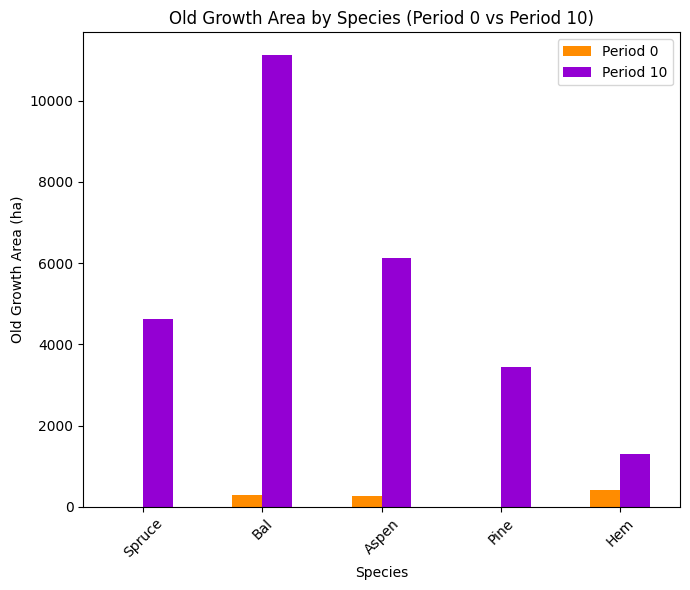

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2509
Bal: 0.3750
Aspen: 0.1338
Pine: 0.1506
Hem: 0.0896

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9228

Diversity has **decreased** by 2.27% from time 0 to time 10.


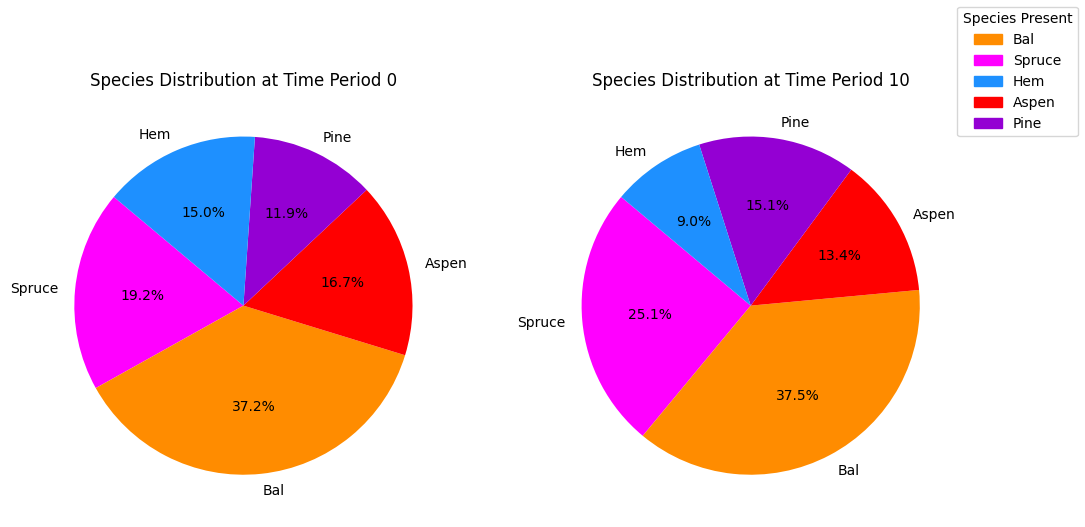

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xb30b6437
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.16s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Factor O

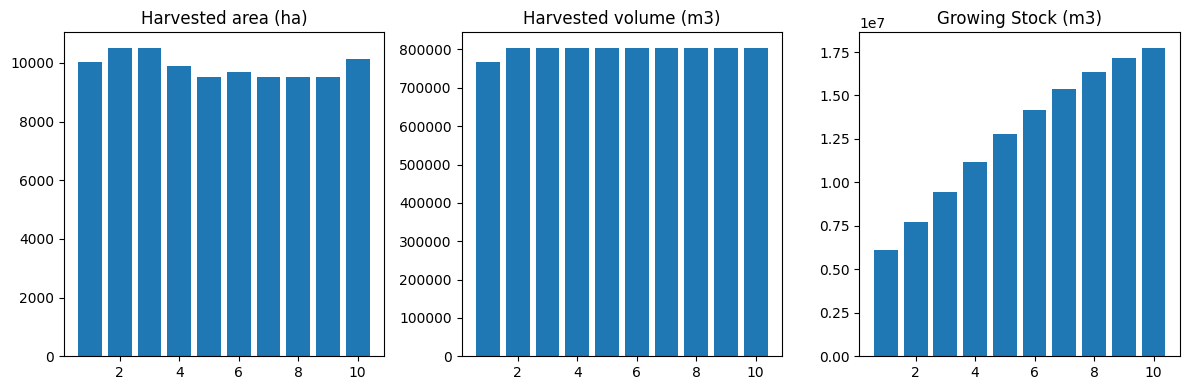

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  8463
The economic indicator (the provincial government revenues) is:  288619
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


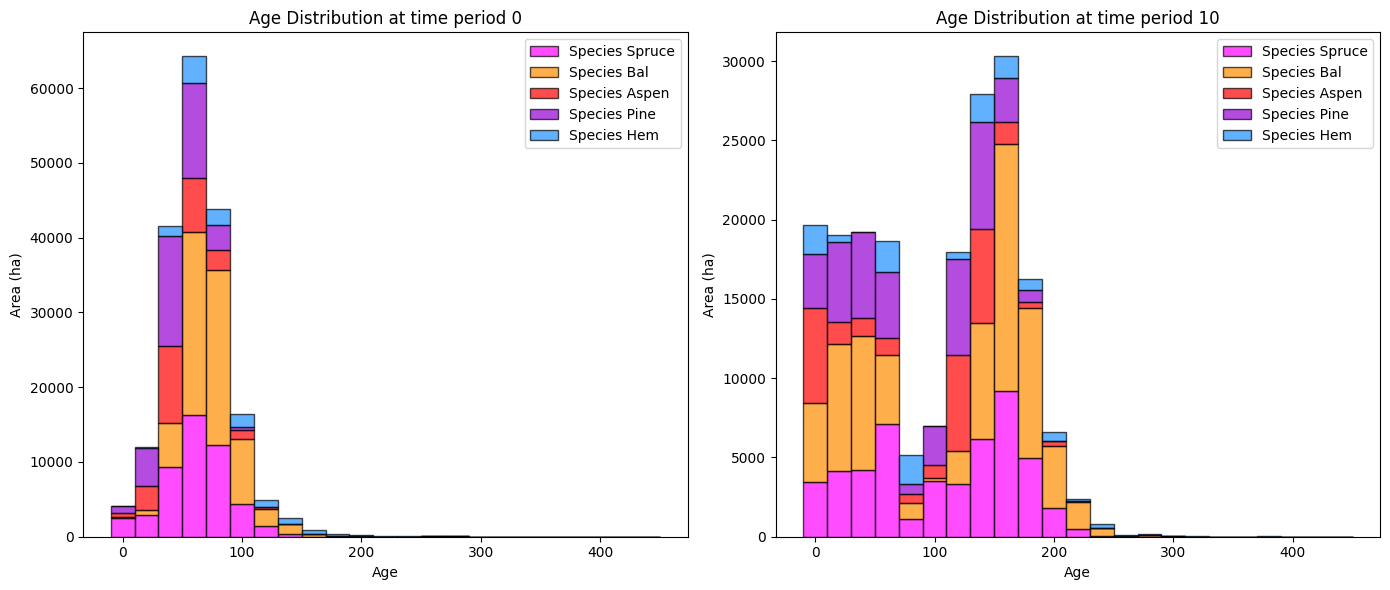

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4624.091497   4621.382963
Bal     278.565372  11130.044561  10851.479189
Aspen   273.490478   6117.315597   5843.825119
Pine      0.000000   3444.407631   3444.407631
Hem     419.699331   1309.461400    889.762069

Overall diversity has **increased** by 25650.86 hectares from time period 0 to time period 10.


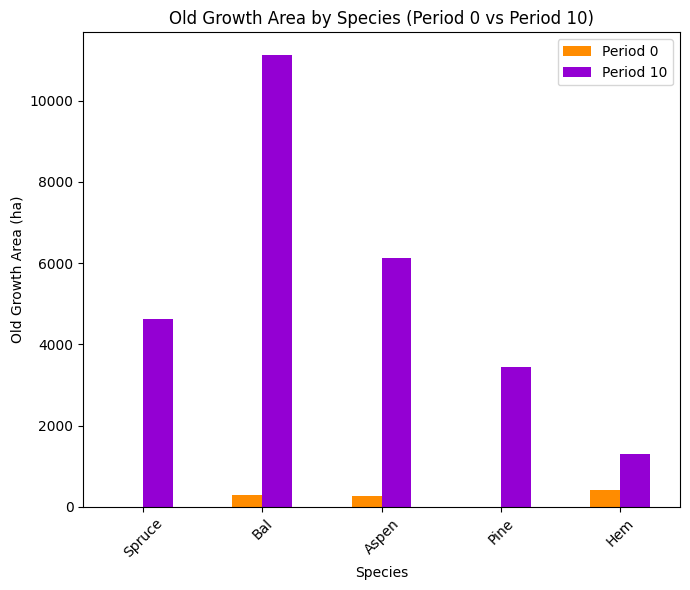

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2509
Bal: 0.3750
Aspen: 0.1338
Pine: 0.1506
Hem: 0.0896

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9228

Diversity has **decreased** by 2.27% from time 0 to time 10.


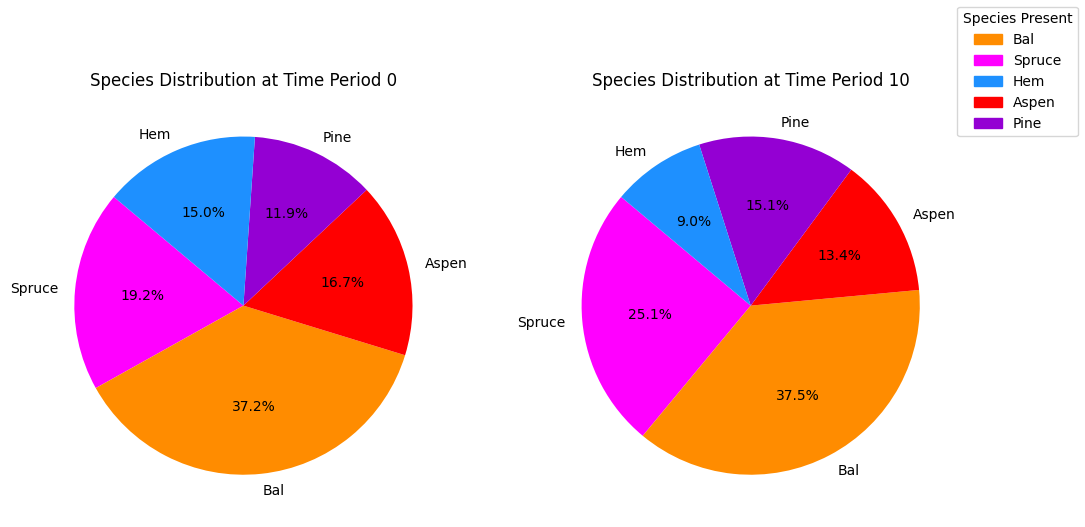

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_species_pie.pdf


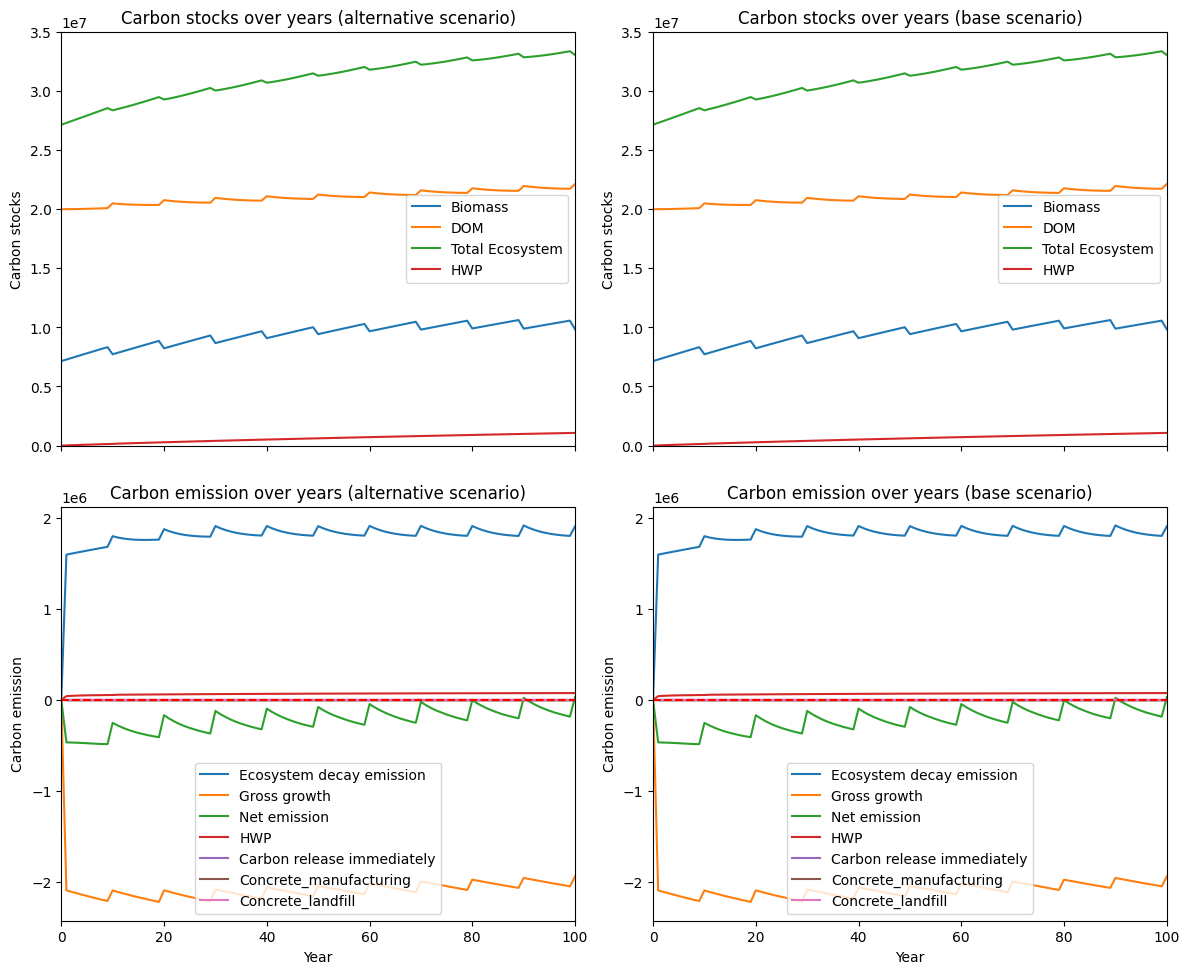

---------------------------------------------------------------------------------------
Net emission difference 0.0
Net emission base scenario -8957872.950034881
Net emission alternative scenario -8957872.950034881
dollar_per_ton is:  inf
Comparison of Old Growth Areas (Alternative - Base)
          0   10  Difference
Spruce  0.0  0.0         0.0
Bal     0.0  0.0         0.0
Aspen   0.0  0.0         0.0
Pine    0.0  0.0         0.0
Hem     0.0  0.0         0.0

Overall, the old growth area has **increased** by 0.00 hectares in the alternative scenario compared to the base scenario.


/media/data/project/eghasemi/nbds_mining/util_opt.py:1211: RuntimeWarning: divide by zero encountered in scalar divide
  dollar_per_ton = abs(budget_input / dif_scenario.iloc[:25]['Net emission'].sum())


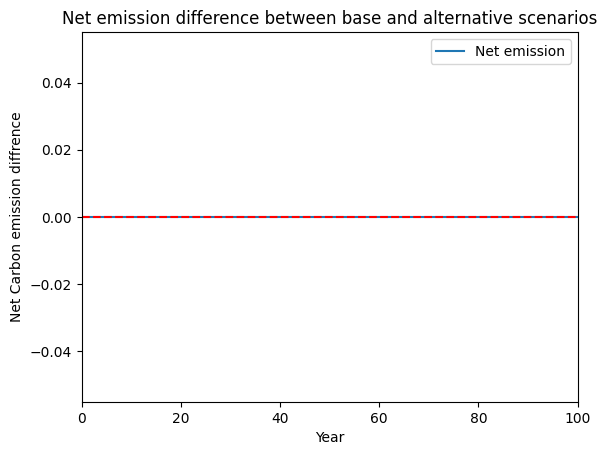

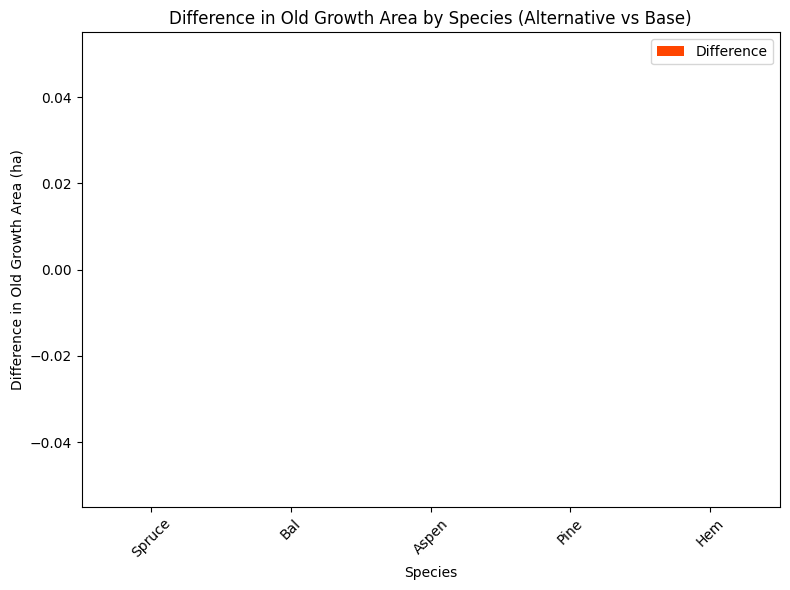

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_age_difference.pdf


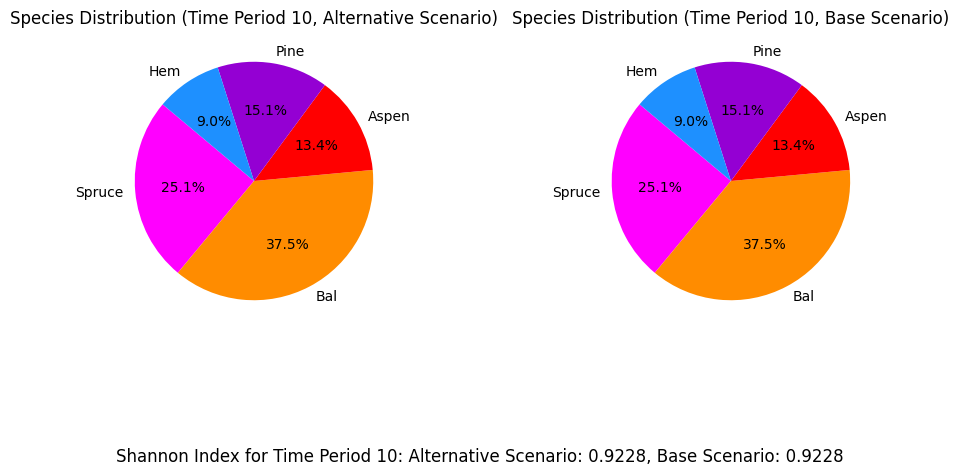

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_hv_gldbr_AAC_90%...
running the scenario for the Golden Bear mining site (90%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x8fd36b08
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.17s
Presolved: 1911 rows, 32226 

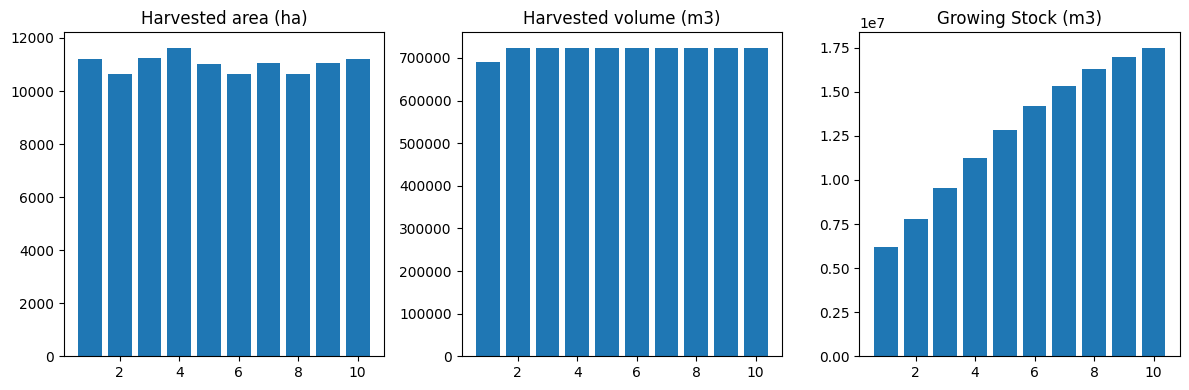

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_90%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7617
The economic indicator (the provincial government revenues) is:  259757
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


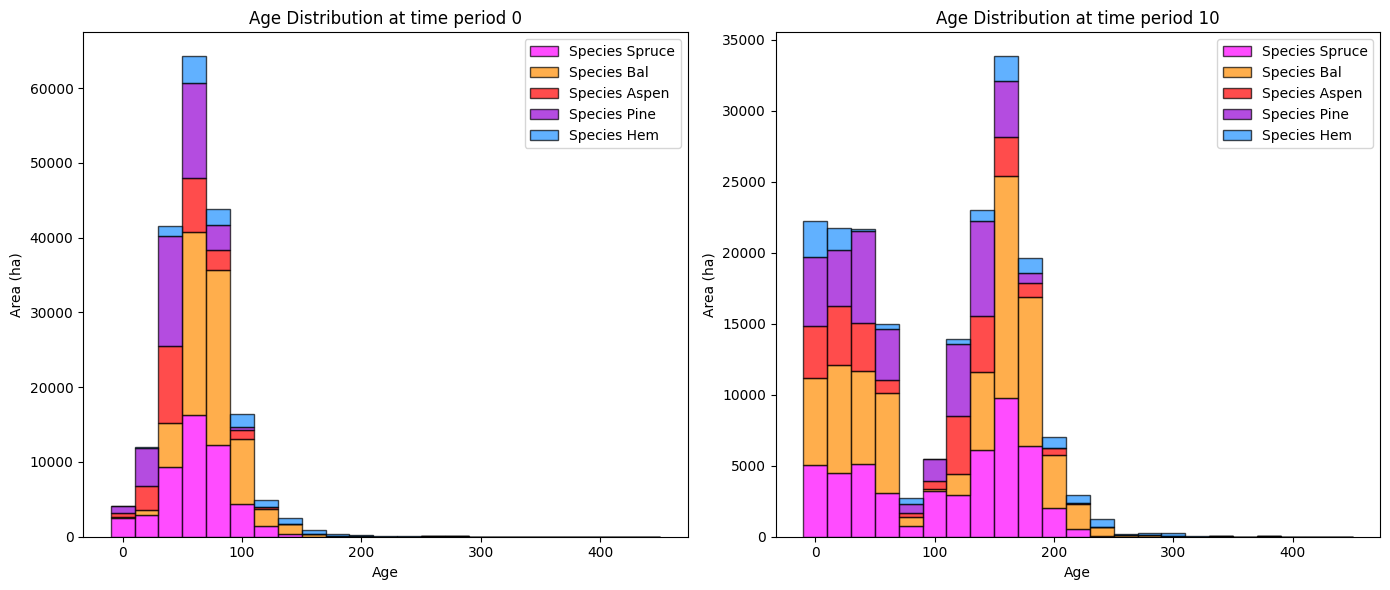

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_90%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   5900.077792   5897.369259
Bal     278.565372  12110.549187  11831.983815
Aspen   273.490478   7100.955084   6827.464606
Pine      0.000000   3845.208039   3845.208039
Hem     419.699331   2521.929288   2102.229958

Overall diversity has **increased** by 30504.26 hectares from time period 0 to time period 10.


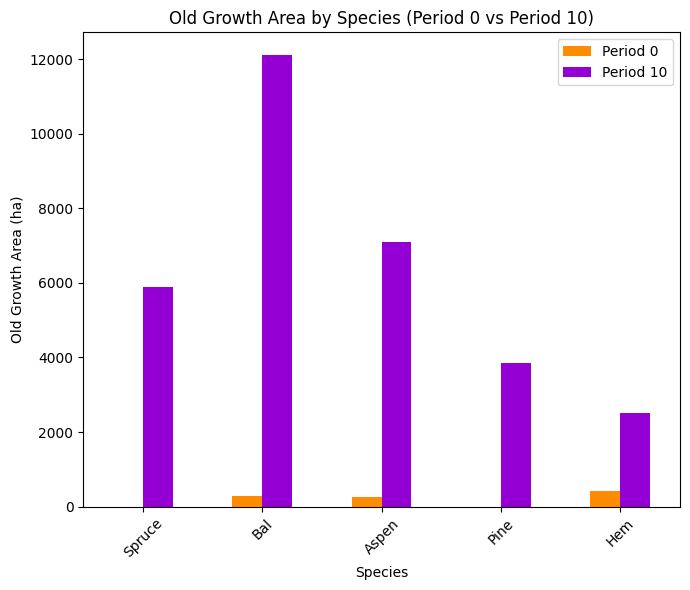

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_90%_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2740
Bal: 0.3694
Aspen: 0.1207
Pine: 0.1450
Hem: 0.0909

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9170

Diversity has **decreased** by 2.86% from time 0 to time 10.


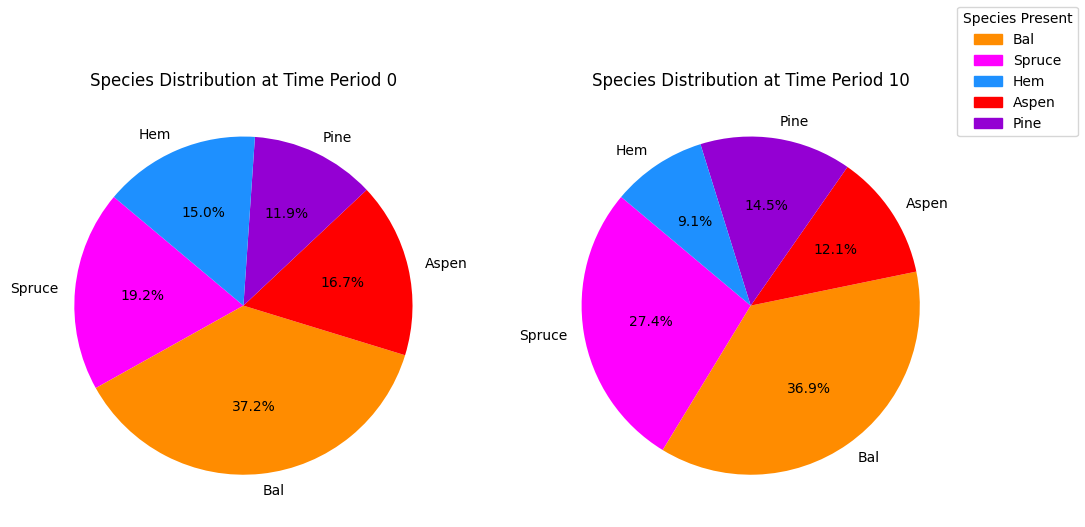

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_90%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xb30b6437
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.22s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

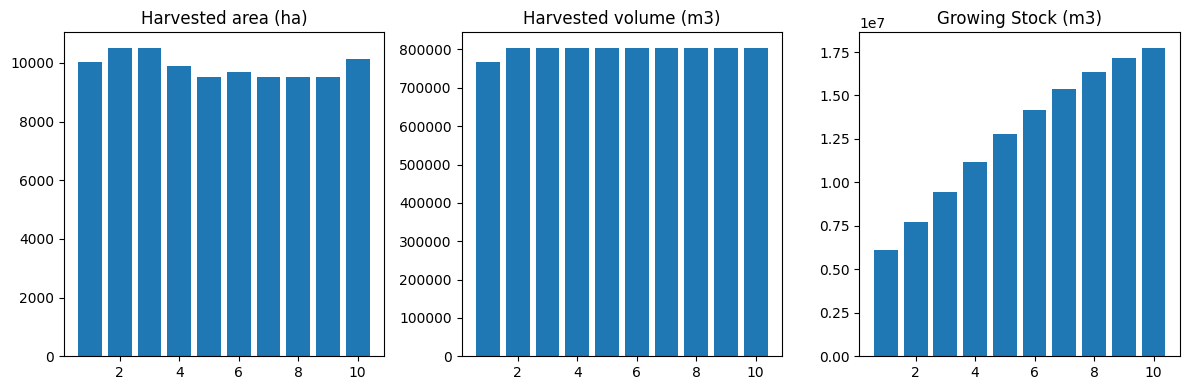

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  8463
The economic indicator (the provincial government revenues) is:  288619
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


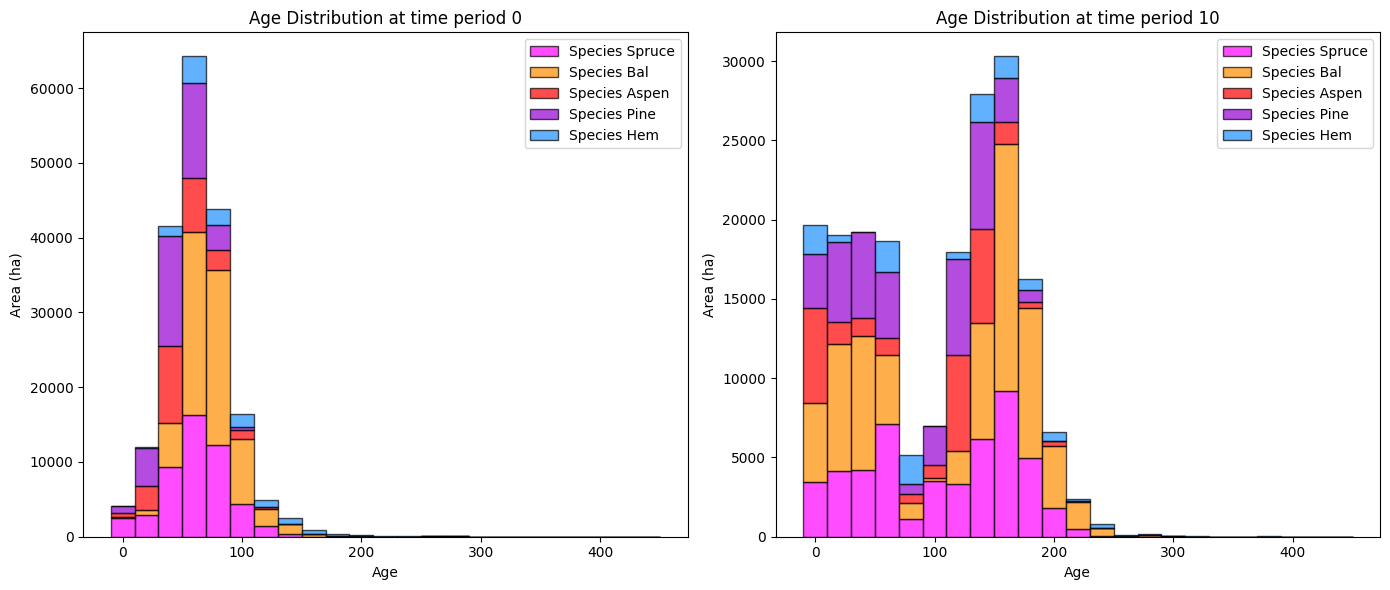

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4624.091497   4621.382963
Bal     278.565372  11130.044561  10851.479189
Aspen   273.490478   6117.315597   5843.825119
Pine      0.000000   3444.407631   3444.407631
Hem     419.699331   1309.461400    889.762069

Overall diversity has **increased** by 25650.86 hectares from time period 0 to time period 10.


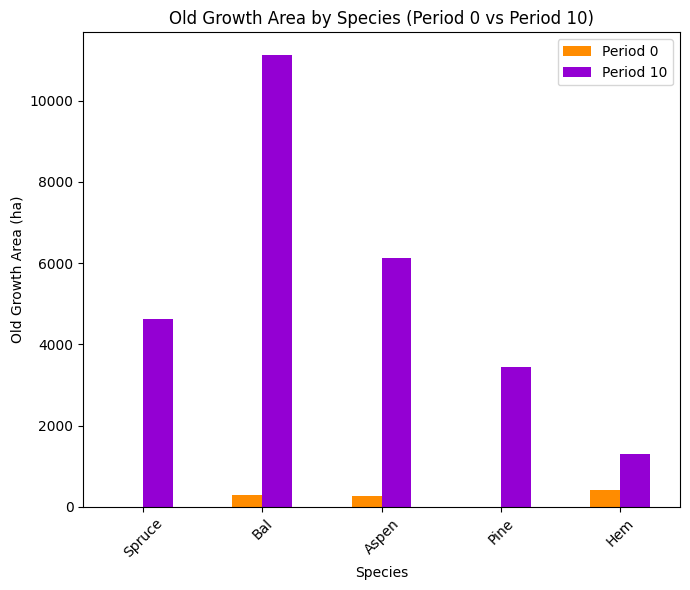

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2509
Bal: 0.3750
Aspen: 0.1338
Pine: 0.1506
Hem: 0.0896

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9228

Diversity has **decreased** by 2.27% from time 0 to time 10.


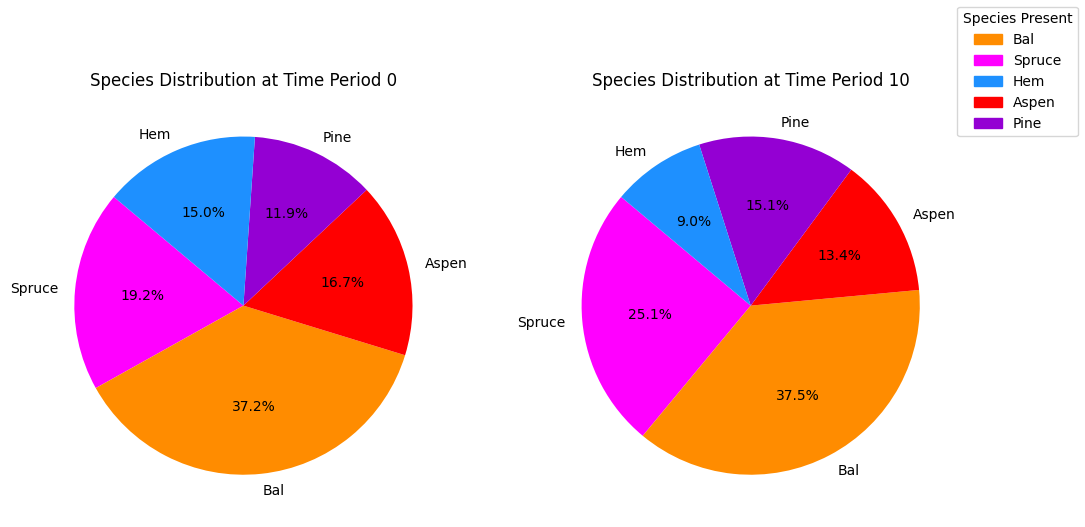

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_species_pie.pdf


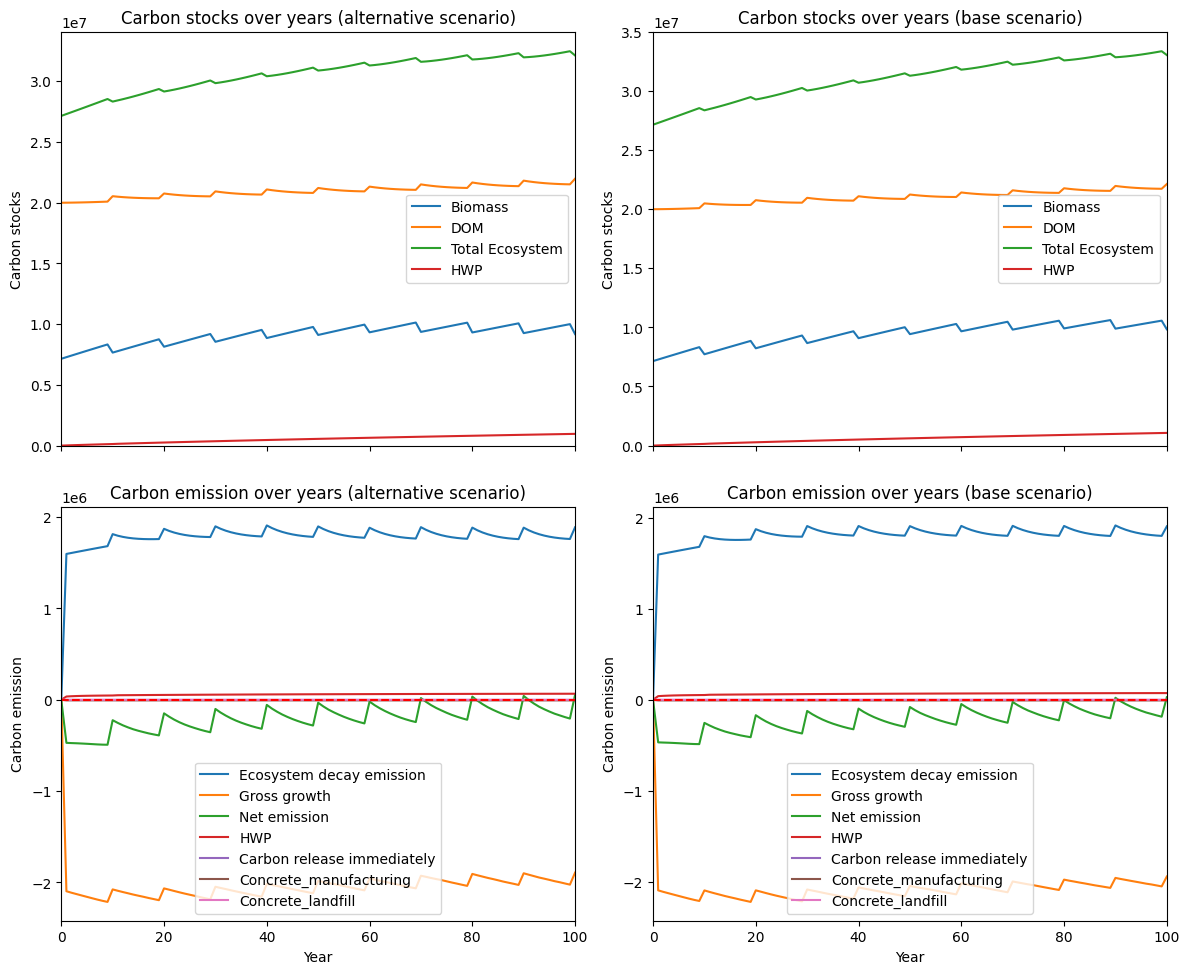

---------------------------------------------------------------------------------------
Net emission difference 328492.9732579008
Net emission base scenario -8629379.97677698
Net emission alternative scenario -8957872.950034881
dollar_per_ton is:  30.44205147167325
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  1275.986296  1275.986296
Bal     0.0   980.504626   980.504626
Aspen   0.0   983.639486   983.639486
Pine    0.0   400.800407   400.800407
Hem     0.0  1212.467889  1212.467889

Overall, the old growth area has **increased** by 4853.40 hectares in the alternative scenario compared to the base scenario.


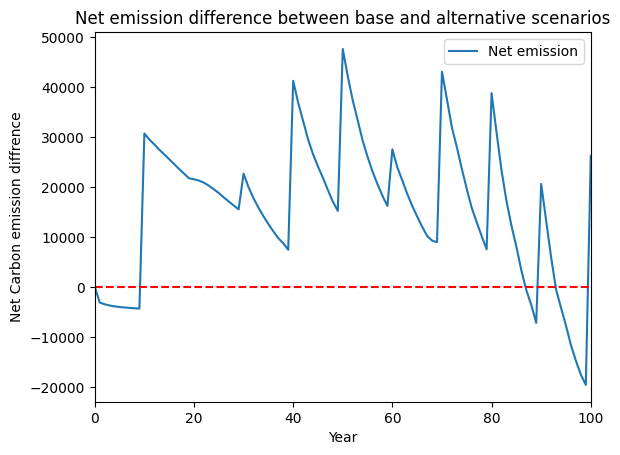

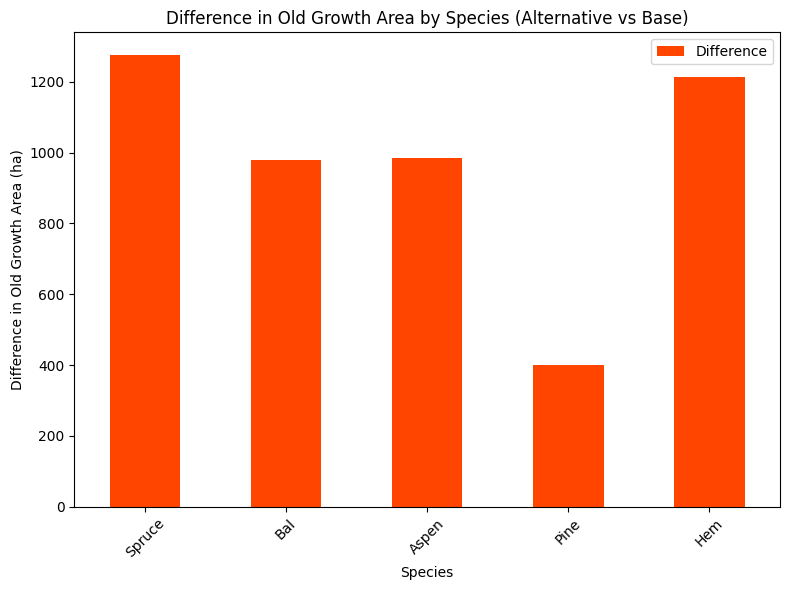

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_age_difference.pdf


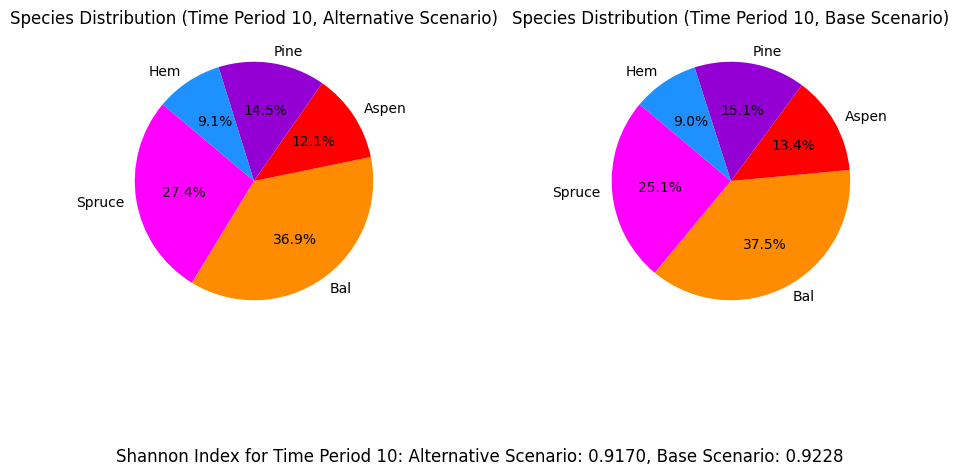

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_hv_gldbr_AAC_80%...
running the scenario for the Golden Bear mining site (80%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xbaa257a4
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.22s
Presolved: 1911 rows, 32226 

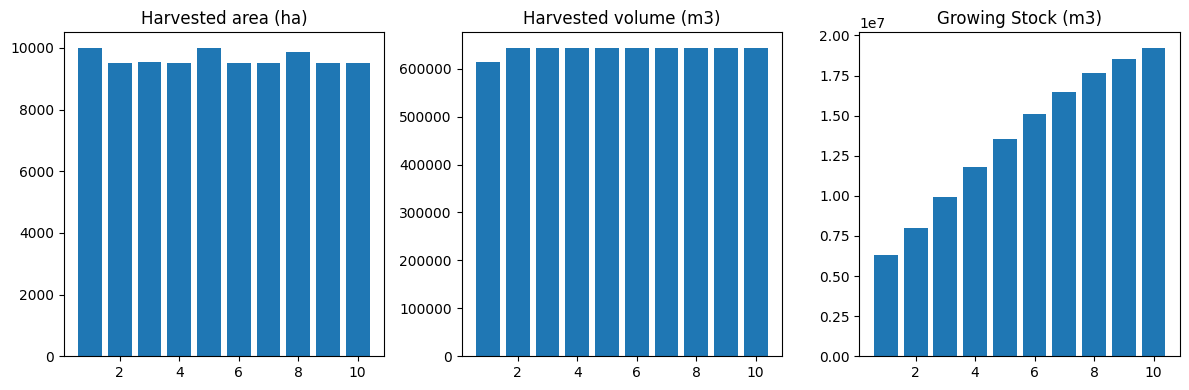

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_80%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  6770
The economic indicator (the provincial government revenues) is:  230895
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


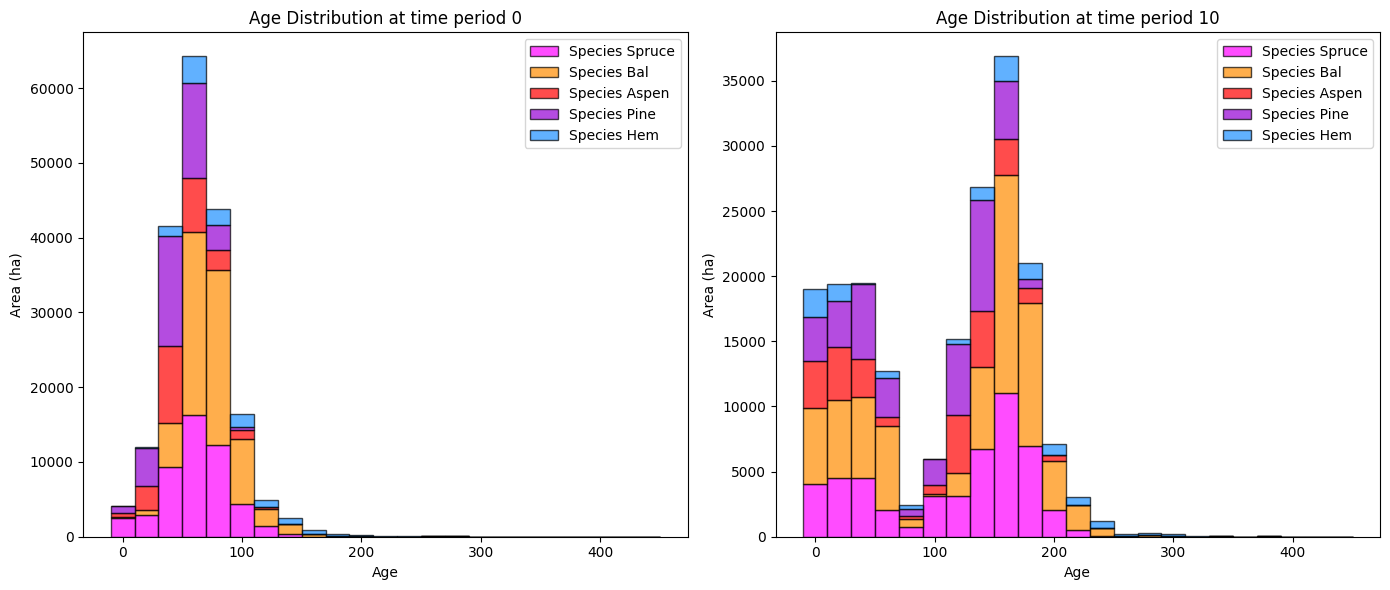

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_80%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   6324.585431   6321.876897
Bal     278.565372  12583.028422  12304.463050
Aspen   273.490478   7408.151480   7134.661002
Pine      0.000000   4436.478307   4436.478307
Hem     419.699331   2686.305762   2266.606431

Overall diversity has **increased** by 32464.09 hectares from time period 0 to time period 10.


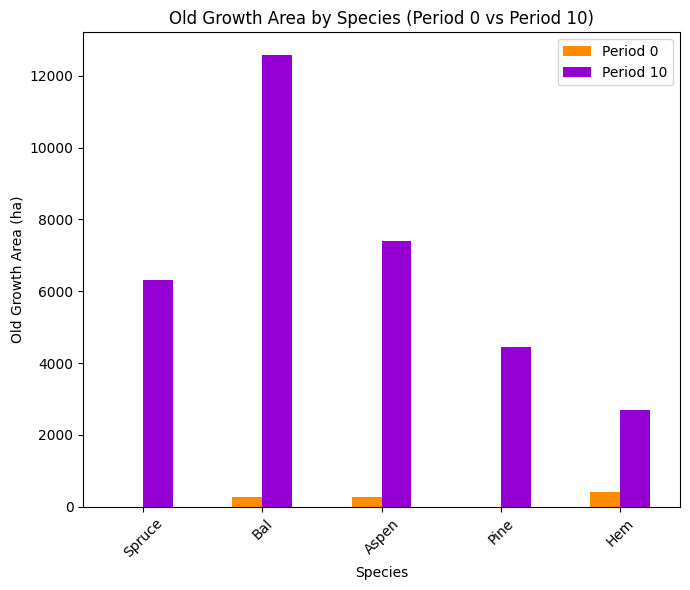

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_80%_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2759
Bal: 0.3620
Aspen: 0.1167
Pine: 0.1544
Hem: 0.0910

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9198

Diversity has **decreased** by 2.57% from time 0 to time 10.


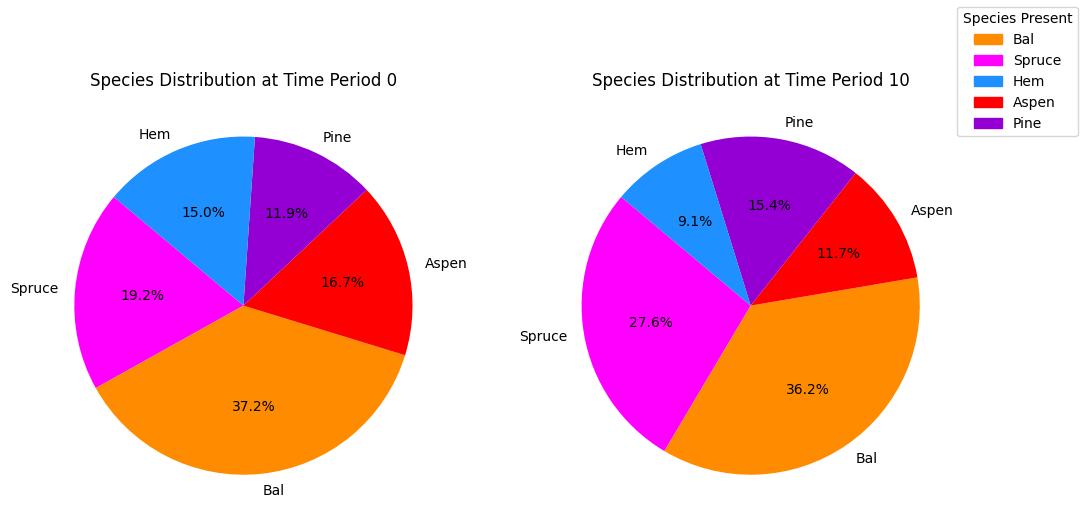

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_80%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xb30b6437
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.16s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

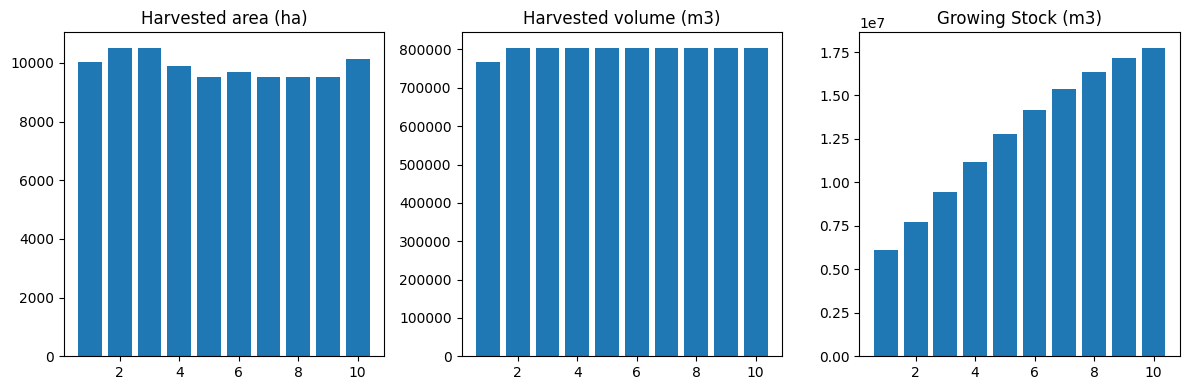

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  8463
The economic indicator (the provincial government revenues) is:  288619
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


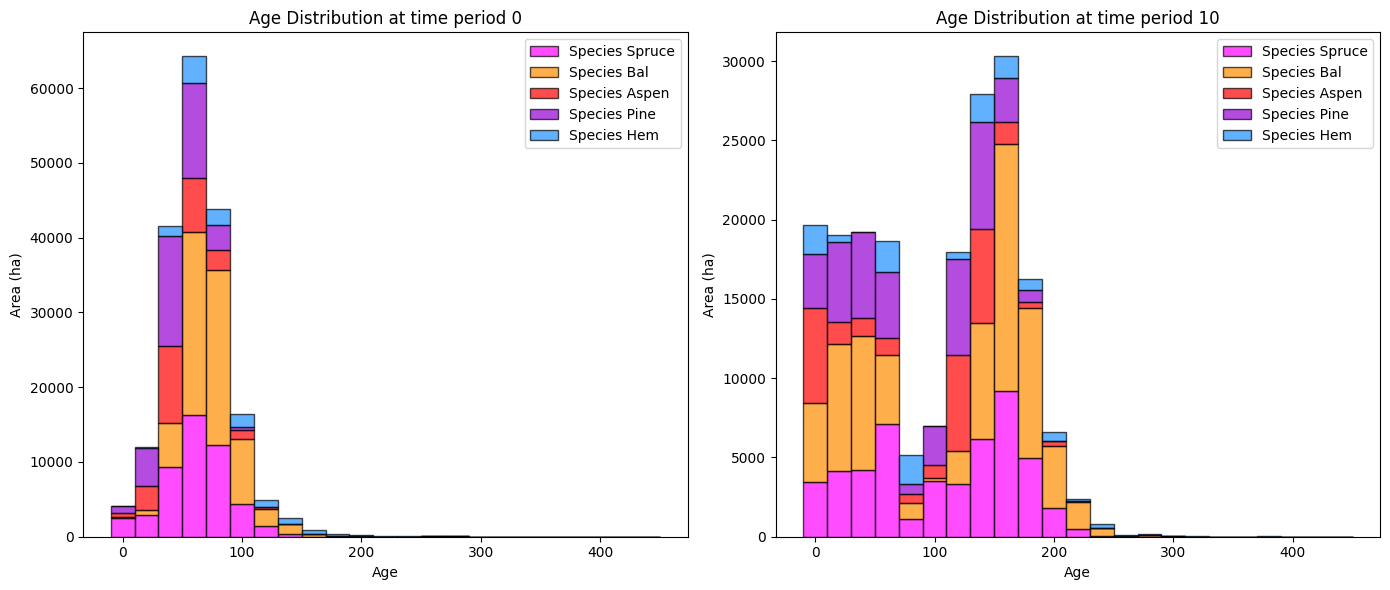

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4624.091497   4621.382963
Bal     278.565372  11130.044561  10851.479189
Aspen   273.490478   6117.315597   5843.825119
Pine      0.000000   3444.407631   3444.407631
Hem     419.699331   1309.461400    889.762069

Overall diversity has **increased** by 25650.86 hectares from time period 0 to time period 10.


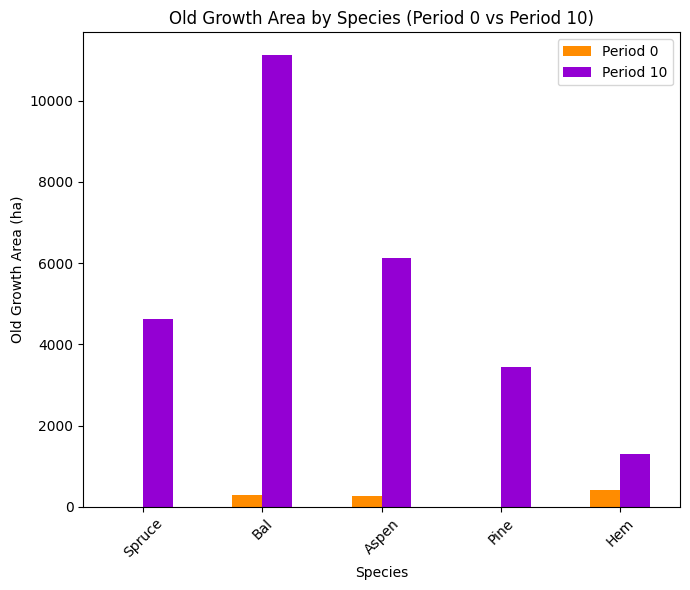

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2509
Bal: 0.3750
Aspen: 0.1338
Pine: 0.1506
Hem: 0.0896

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9228

Diversity has **decreased** by 2.27% from time 0 to time 10.


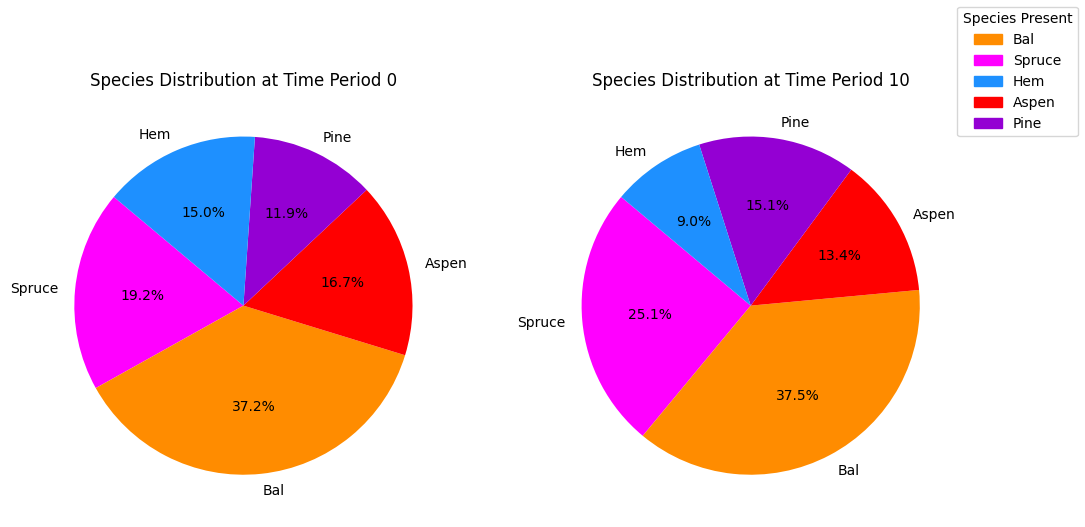

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_species_pie.pdf


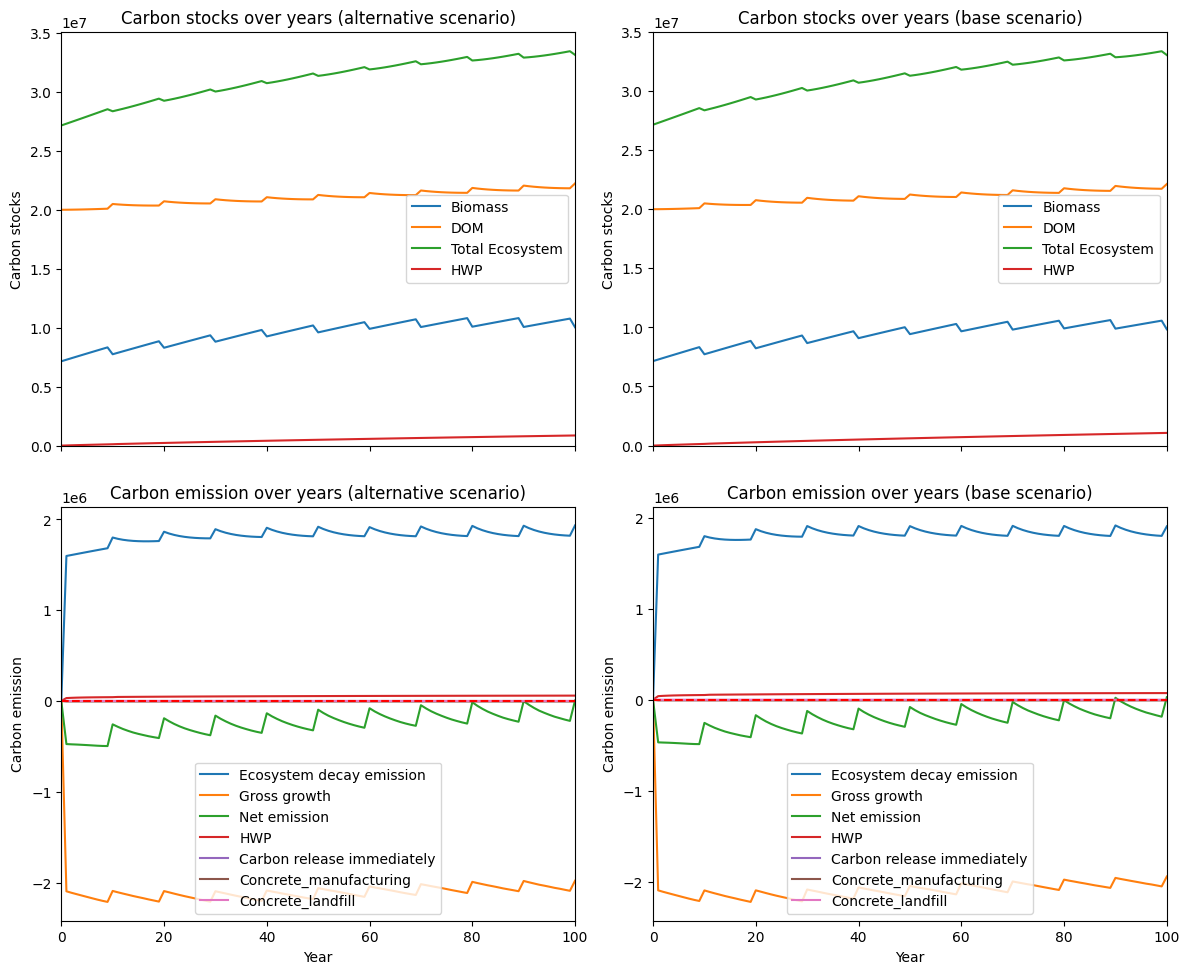

---------------------------------------------------------------------------------------
Net emission difference -134605.5951394487
Net emission base scenario -9092478.54517433
Net emission alternative scenario -8957872.950034881
dollar_per_ton is:  74.29111687103497
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  1700.493934  1700.493934
Bal     0.0  1452.983861  1452.983861
Aspen   0.0  1290.835882  1290.835882
Pine    0.0   992.070676   992.070676
Hem     0.0  1376.844362  1376.844362

Overall, the old growth area has **increased** by 6813.23 hectares in the alternative scenario compared to the base scenario.


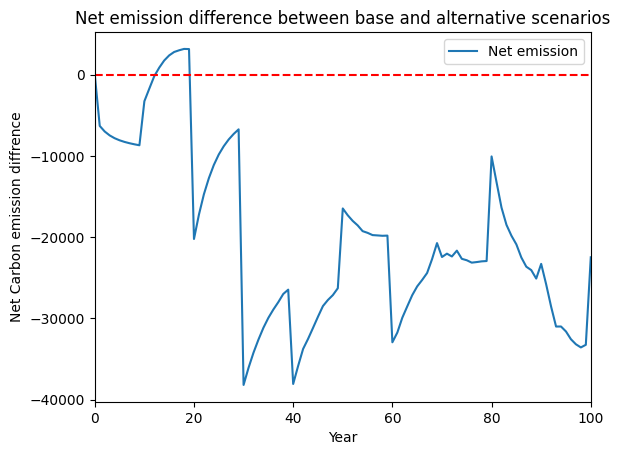

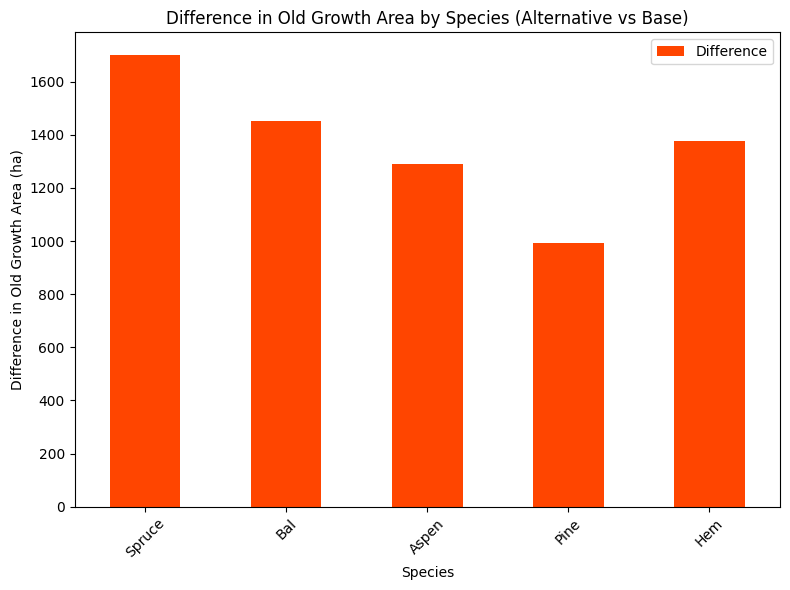

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_age_difference.pdf


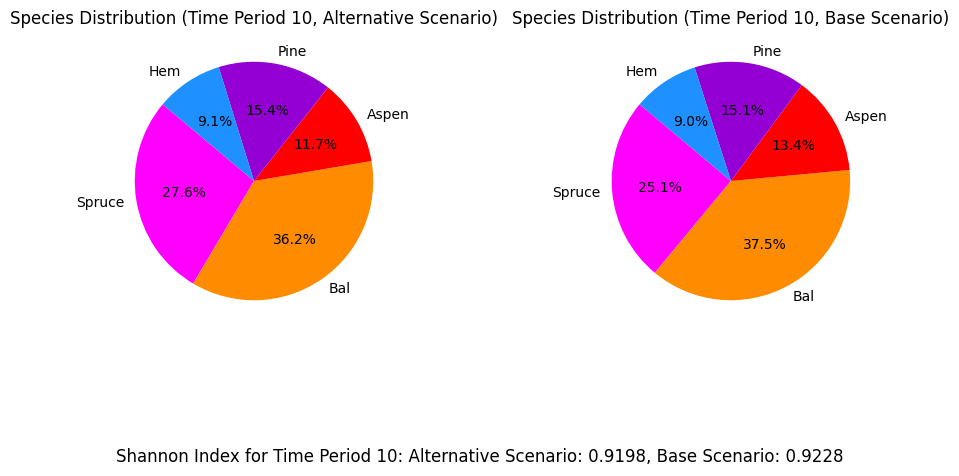

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_hv_gldbr_AAC_70%...
running the scenario for the Golden Bear mining site (70%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x5eaf7d79
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.18s
Presolved: 1911 rows, 32226 

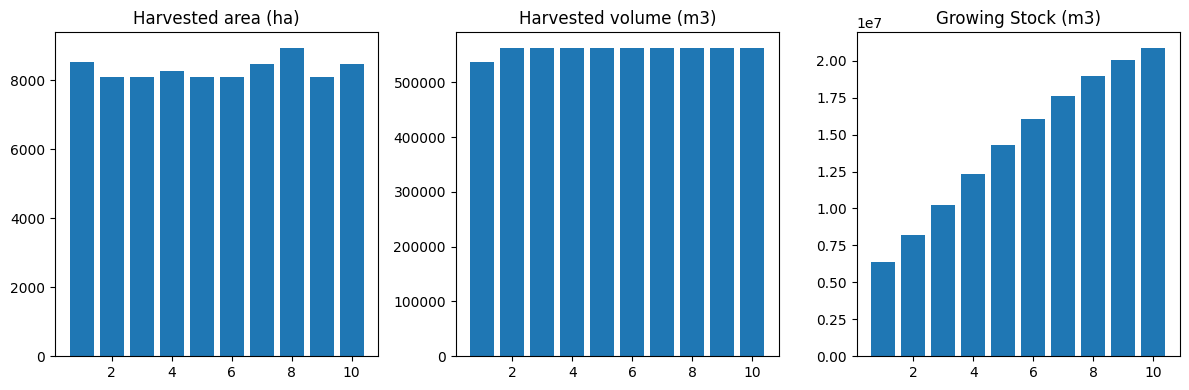

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_70%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  5924
The economic indicator (the provincial government revenues) is:  202033
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


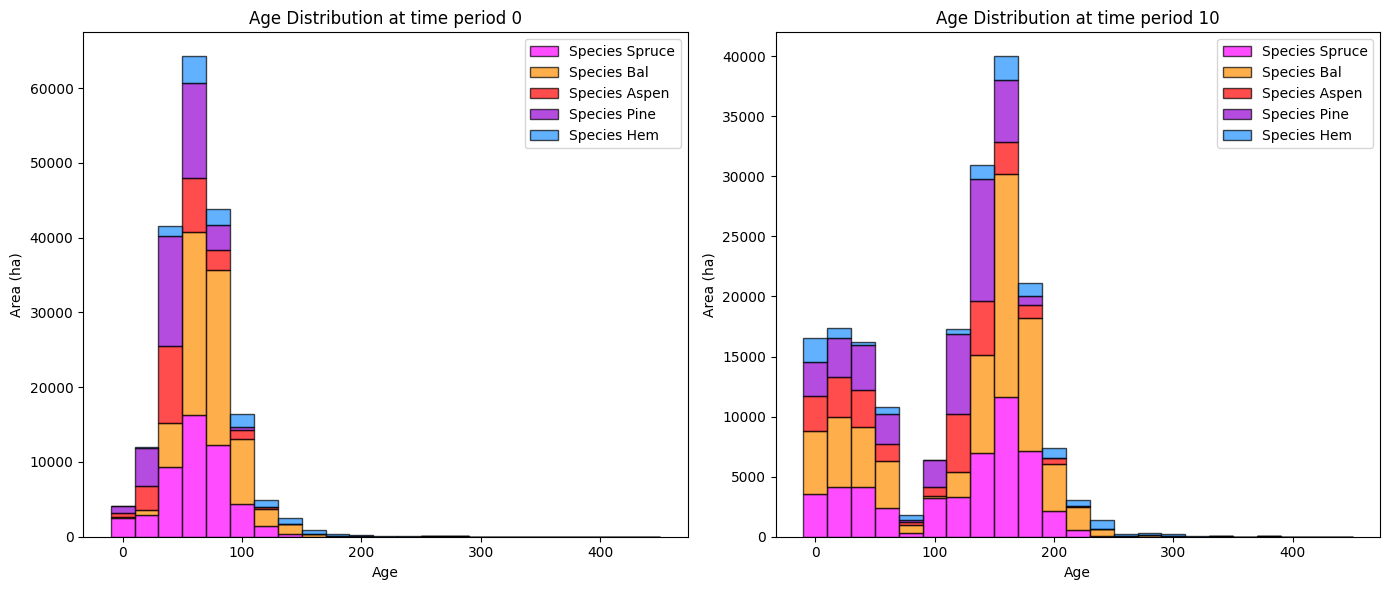

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_70%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   6552.647219   6549.938685
Bal     278.565372  12884.016714  12605.451342
Aspen   273.490478   7584.349777   7310.859299
Pine      0.000000   5107.088924   5107.088924
Hem     419.699331   2747.282848   2327.583517

Overall diversity has **increased** by 33900.92 hectares from time period 0 to time period 10.


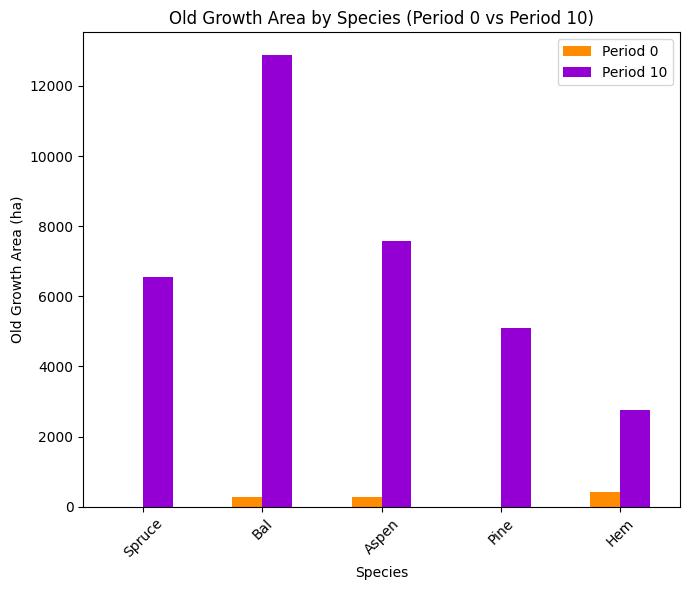

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_70%_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2658
Bal: 0.3688
Aspen: 0.1137
Pine: 0.1647
Hem: 0.0870

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9176

Diversity has **decreased** by 2.80% from time 0 to time 10.


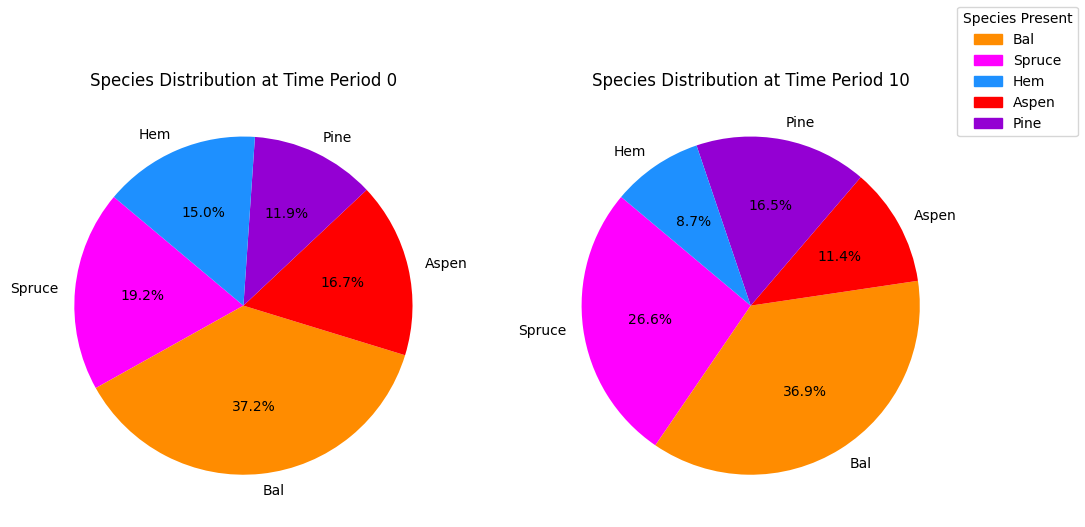

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_70%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xb30b6437
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.18s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

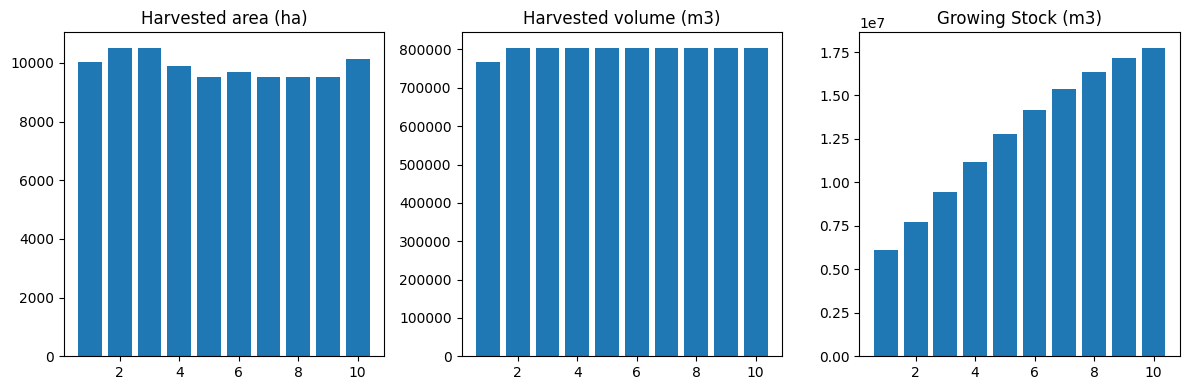

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  8463
The economic indicator (the provincial government revenues) is:  288619
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


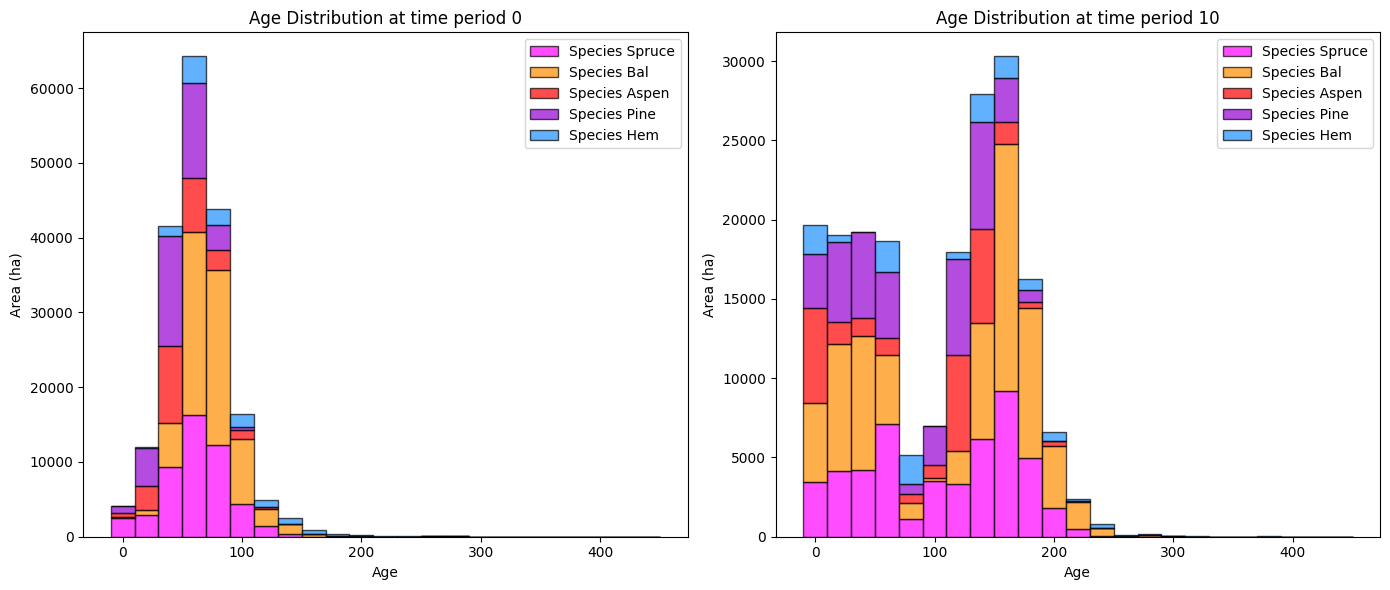

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4624.091497   4621.382963
Bal     278.565372  11130.044561  10851.479189
Aspen   273.490478   6117.315597   5843.825119
Pine      0.000000   3444.407631   3444.407631
Hem     419.699331   1309.461400    889.762069

Overall diversity has **increased** by 25650.86 hectares from time period 0 to time period 10.


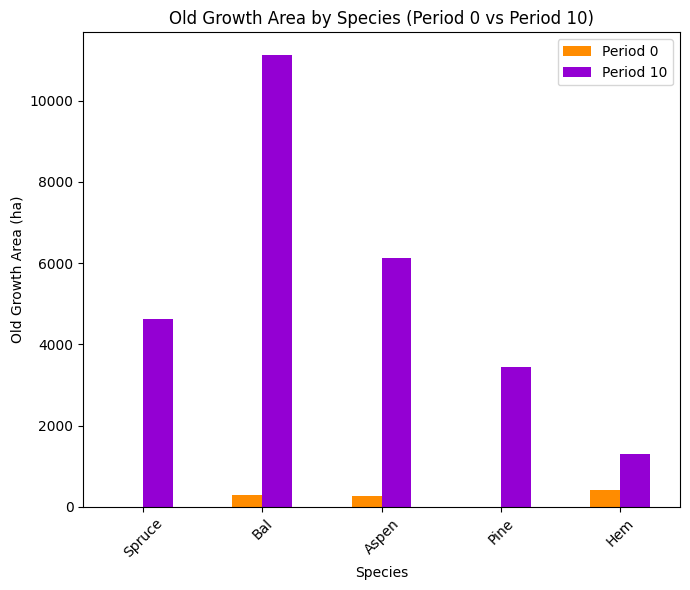

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2509
Bal: 0.3750
Aspen: 0.1338
Pine: 0.1506
Hem: 0.0896

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9228

Diversity has **decreased** by 2.27% from time 0 to time 10.


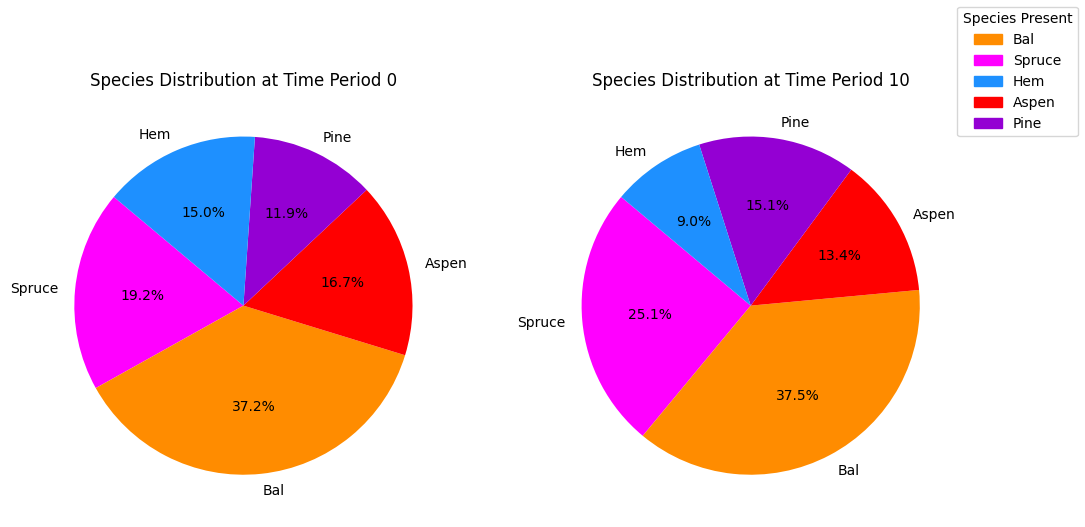

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_species_pie.pdf


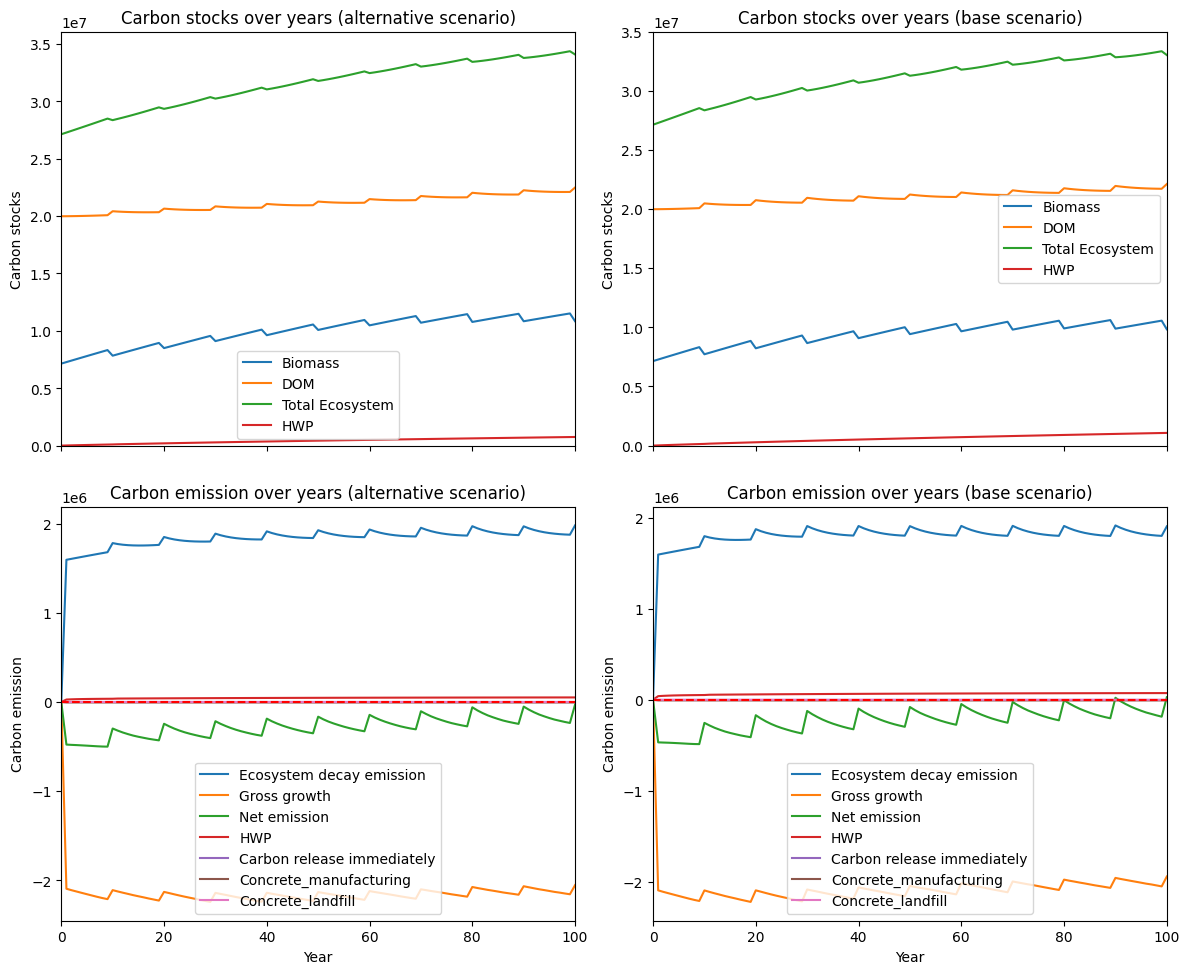

---------------------------------------------------------------------------------------
Net emission difference -692502.8674342289
Net emission base scenario -9650375.817469109
Net emission alternative scenario -8957872.950034881
dollar_per_ton is:  14.440373419753037
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  1928.555722  1928.555722
Bal     0.0  1753.972153  1753.972153
Aspen   0.0  1467.034180  1467.034180
Pine    0.0  1662.681293  1662.681293
Hem     0.0  1437.821448  1437.821448

Overall, the old growth area has **increased** by 8250.06 hectares in the alternative scenario compared to the base scenario.


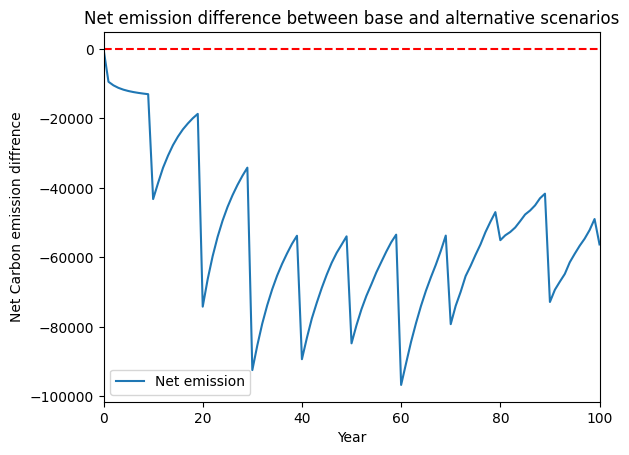

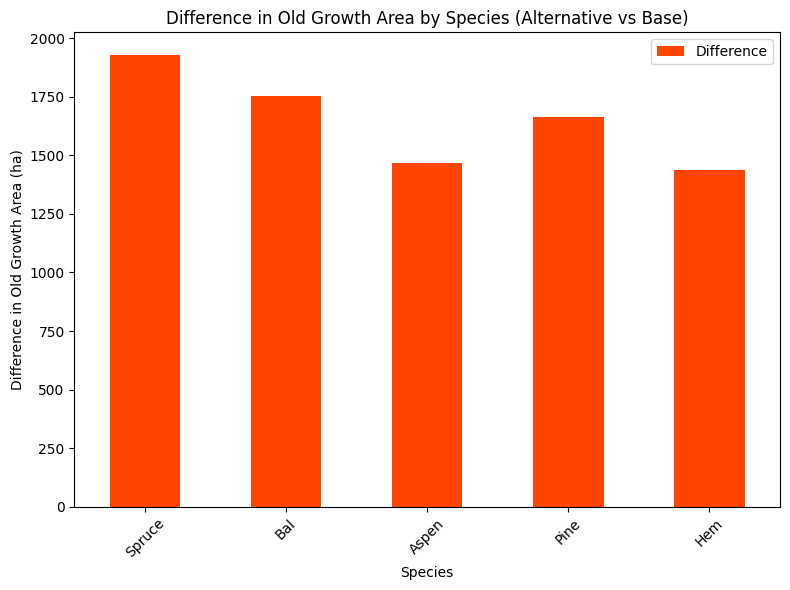

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_age_difference.pdf


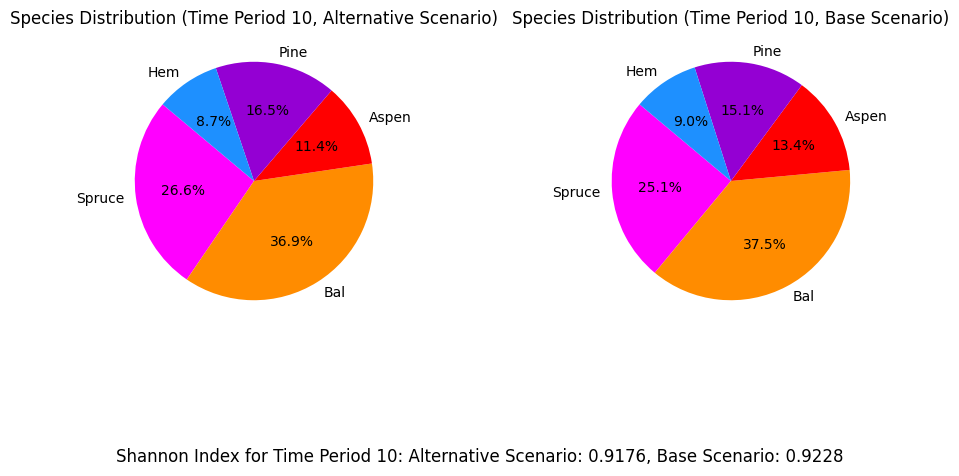

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_hv_gldbr_AAC_60%...
running the scenario for the Golden Bear mining site (60%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x945a0579
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.18s
Presolved: 1911 rows, 32226 

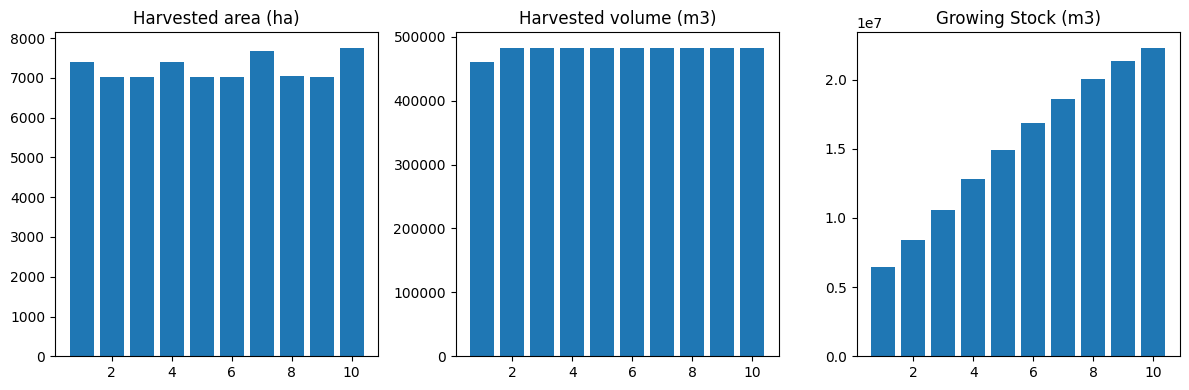

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_60%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  5078
The economic indicator (the provincial government revenues) is:  173171
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


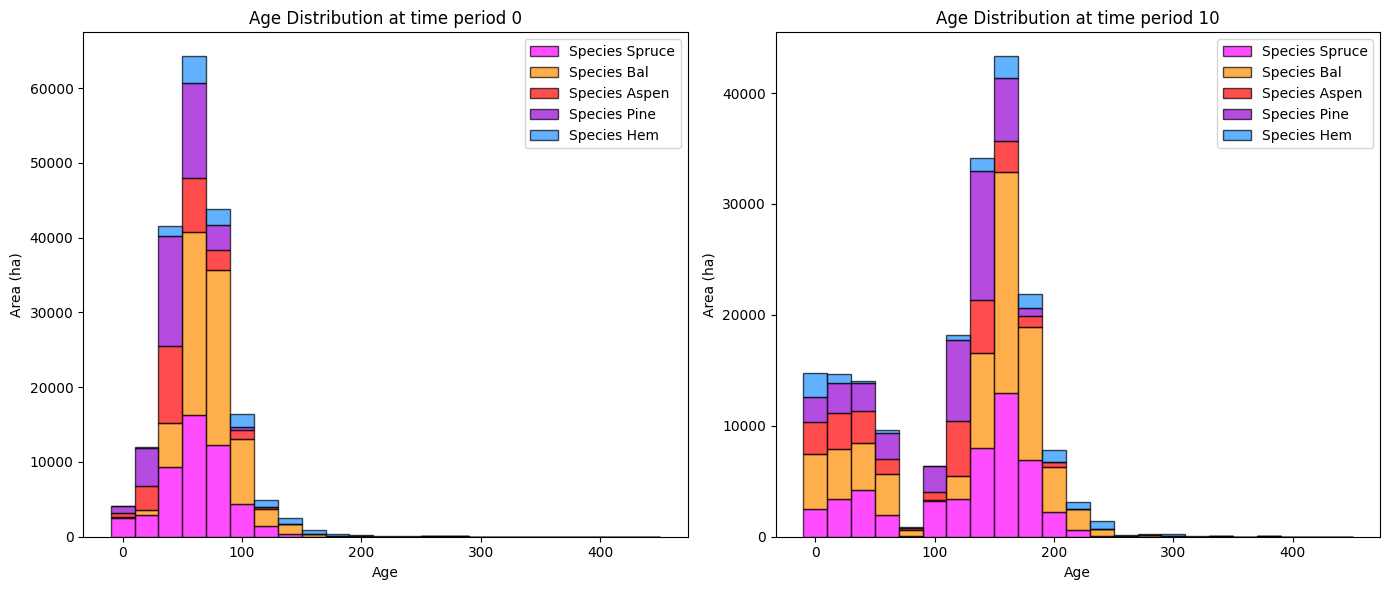

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_60%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   6807.125899   6804.417365
Bal     278.565372  13434.735269  13156.169897
Aspen   273.490478   7796.369806   7522.879328
Pine      0.000000   5587.268553   5587.268553
Hem     419.699331   3020.375900   2600.676569

Overall diversity has **increased** by 35671.41 hectares from time period 0 to time period 10.


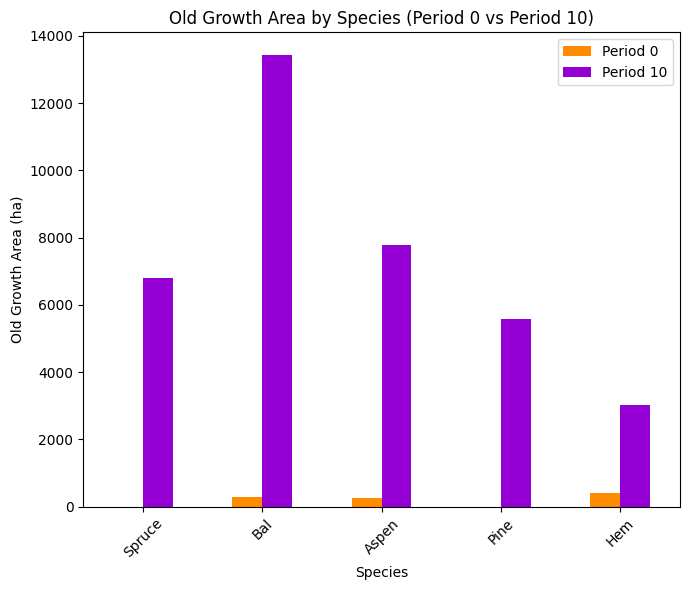

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_60%_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2701
Bal: 0.3660
Aspen: 0.1083
Pine: 0.1701
Hem: 0.0855

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9157

Diversity has **decreased** by 2.99% from time 0 to time 10.


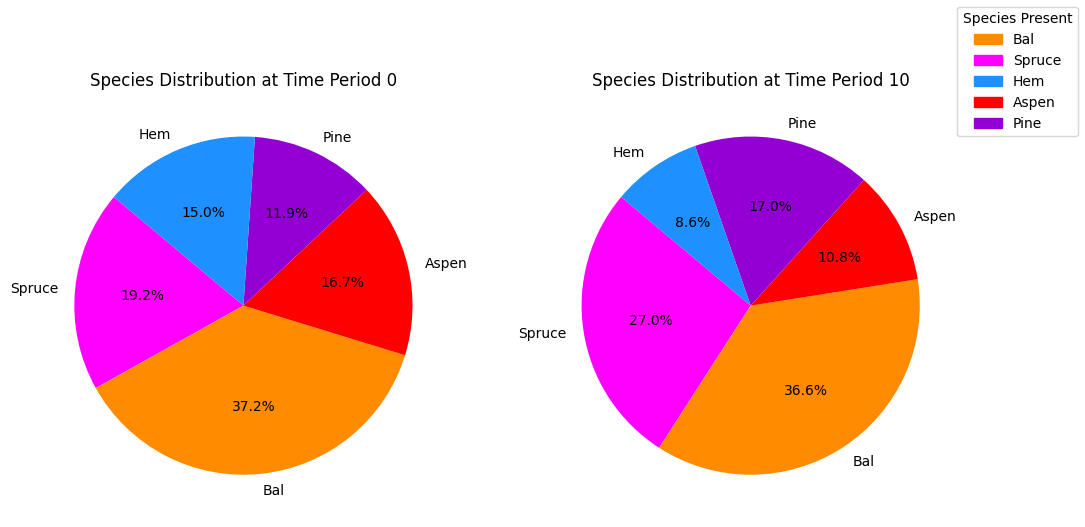

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_60%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xb30b6437
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.19s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

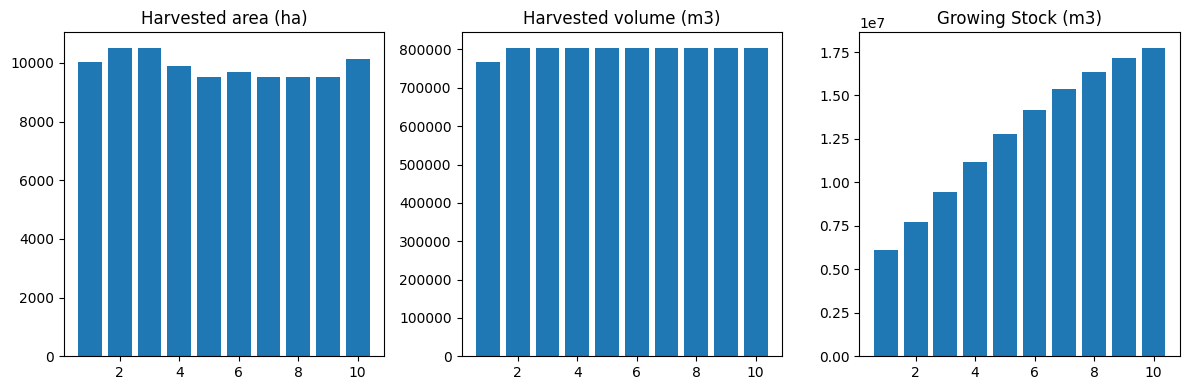

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  8463
The economic indicator (the provincial government revenues) is:  288619
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


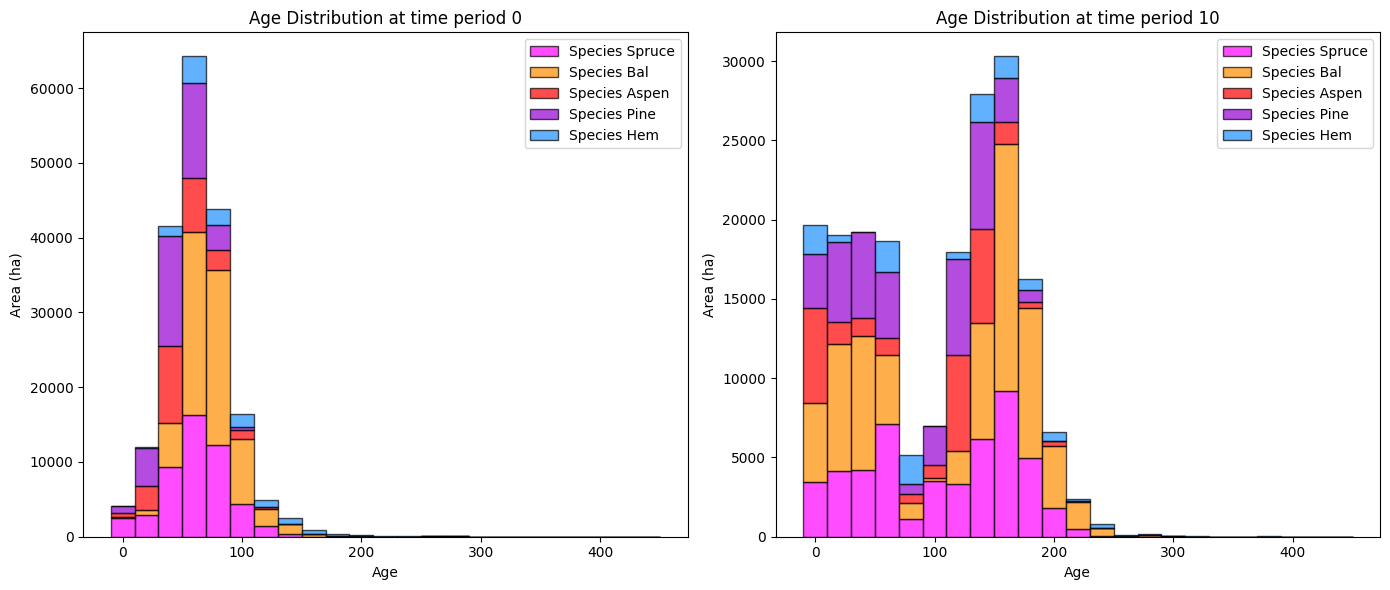

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4624.091497   4621.382963
Bal     278.565372  11130.044561  10851.479189
Aspen   273.490478   6117.315597   5843.825119
Pine      0.000000   3444.407631   3444.407631
Hem     419.699331   1309.461400    889.762069

Overall diversity has **increased** by 25650.86 hectares from time period 0 to time period 10.


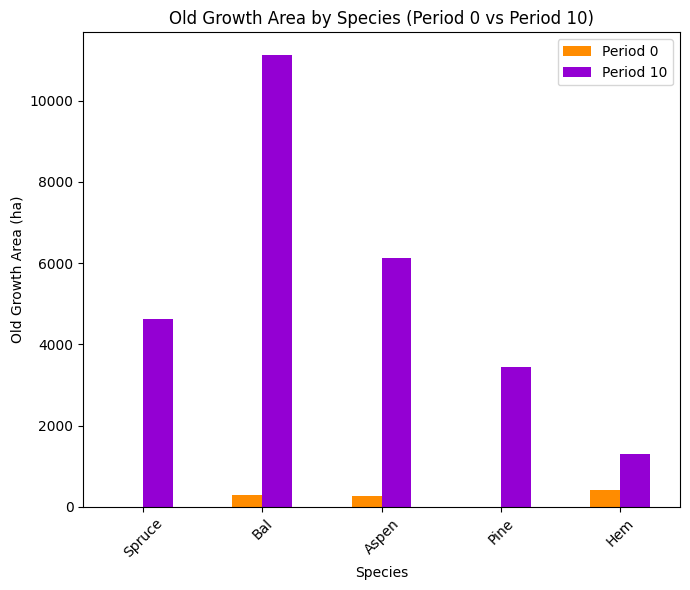

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2509
Bal: 0.3750
Aspen: 0.1338
Pine: 0.1506
Hem: 0.0896

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9228

Diversity has **decreased** by 2.27% from time 0 to time 10.


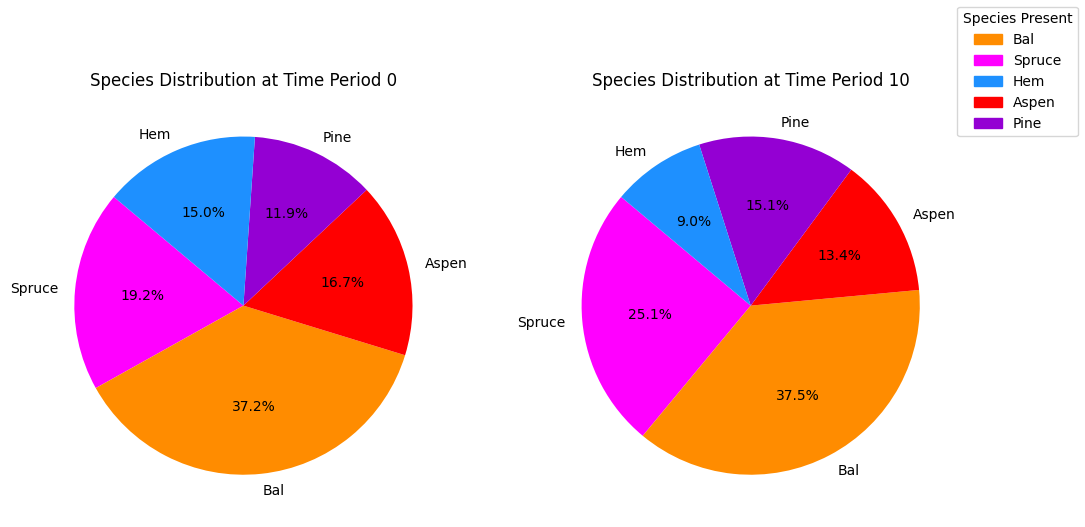

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_species_pie.pdf


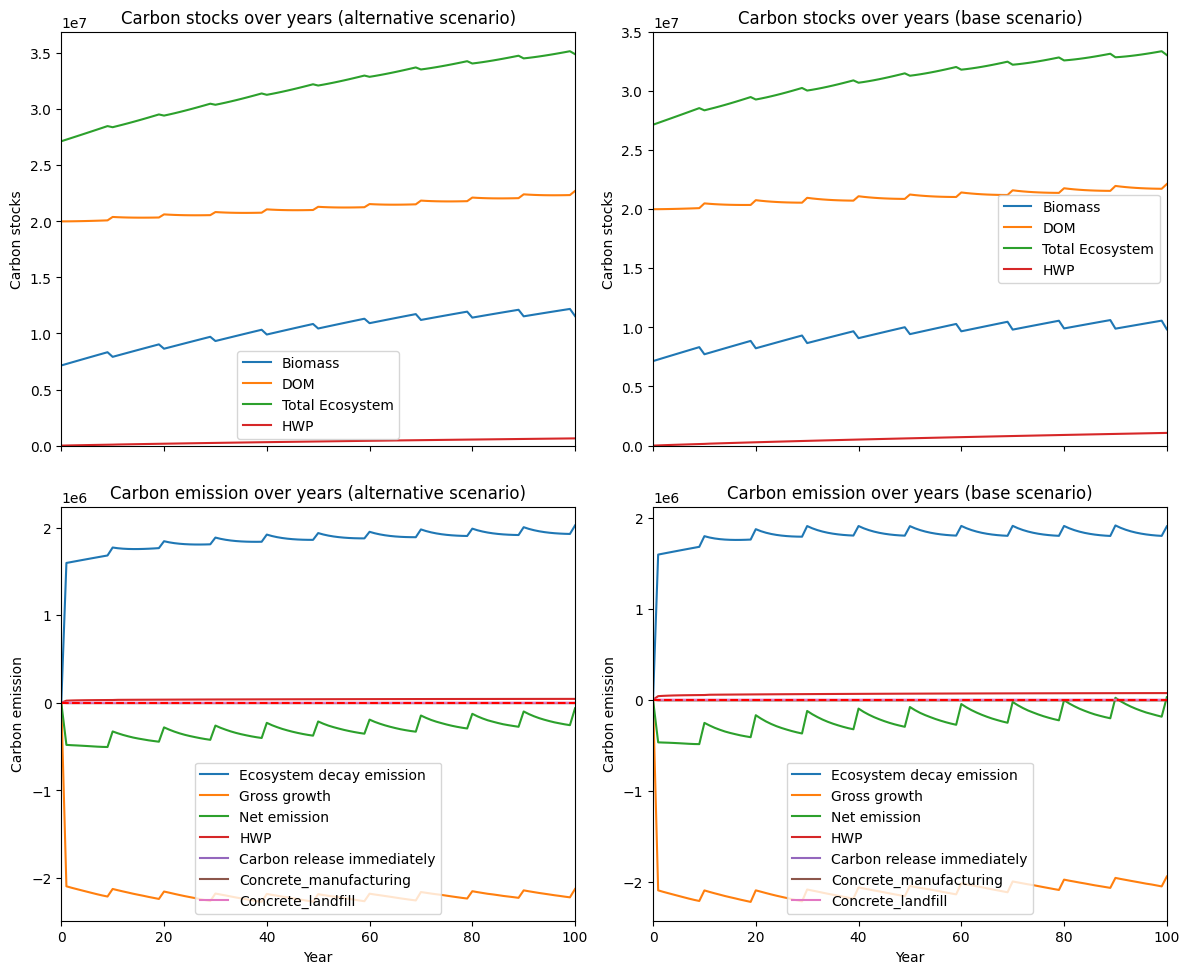

---------------------------------------------------------------------------------------
Net emission difference -1089350.8439874125
Net emission base scenario -10047223.794022294
Net emission alternative scenario -8957872.950034881
dollar_per_ton is:  9.179778998836072
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  2183.034402  2183.034402
Bal     0.0  2304.690708  2304.690708
Aspen   0.0  1679.054209  1679.054209
Pine    0.0  2142.860922  2142.860922
Hem     0.0  1710.914500  1710.914500

Overall, the old growth area has **increased** by 10020.55 hectares in the alternative scenario compared to the base scenario.


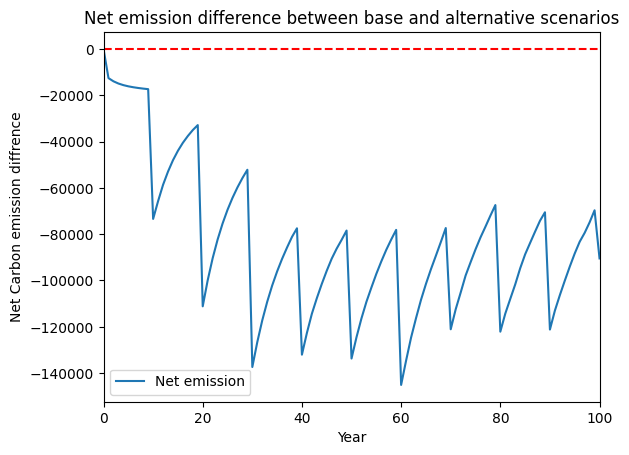

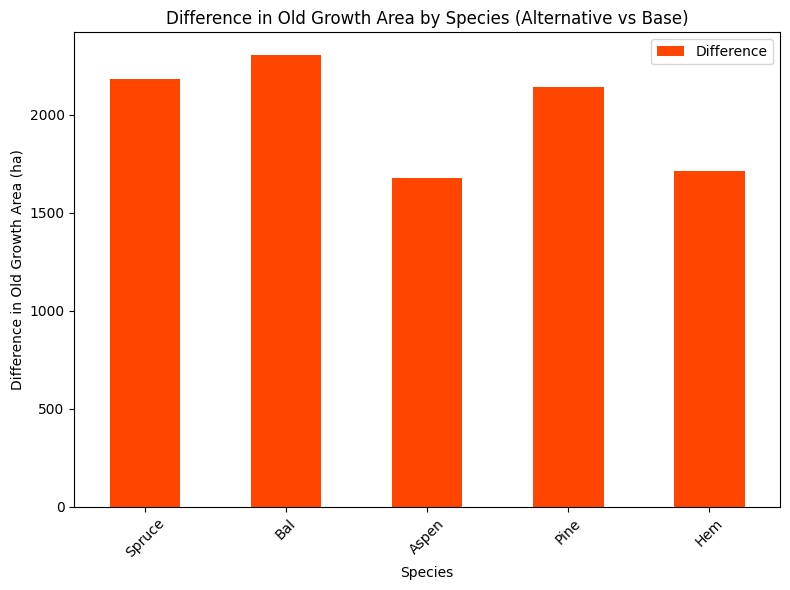

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_age_difference.pdf


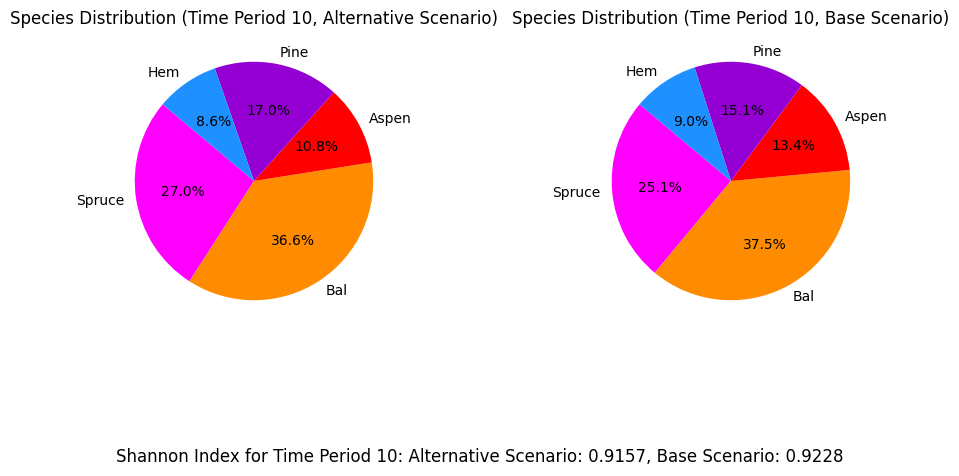

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_hv_gldbr_AAC_50%...
running the scenario for the Golden Bear mining site (50%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xa36abc1c
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.27s
Presolved: 1911 rows, 32226 

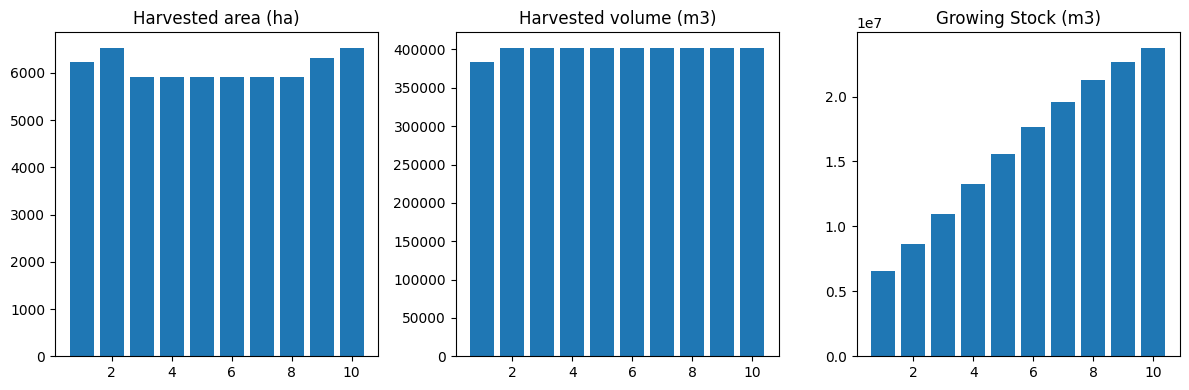

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_50%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  4231
The economic indicator (the provincial government revenues) is:  144310
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


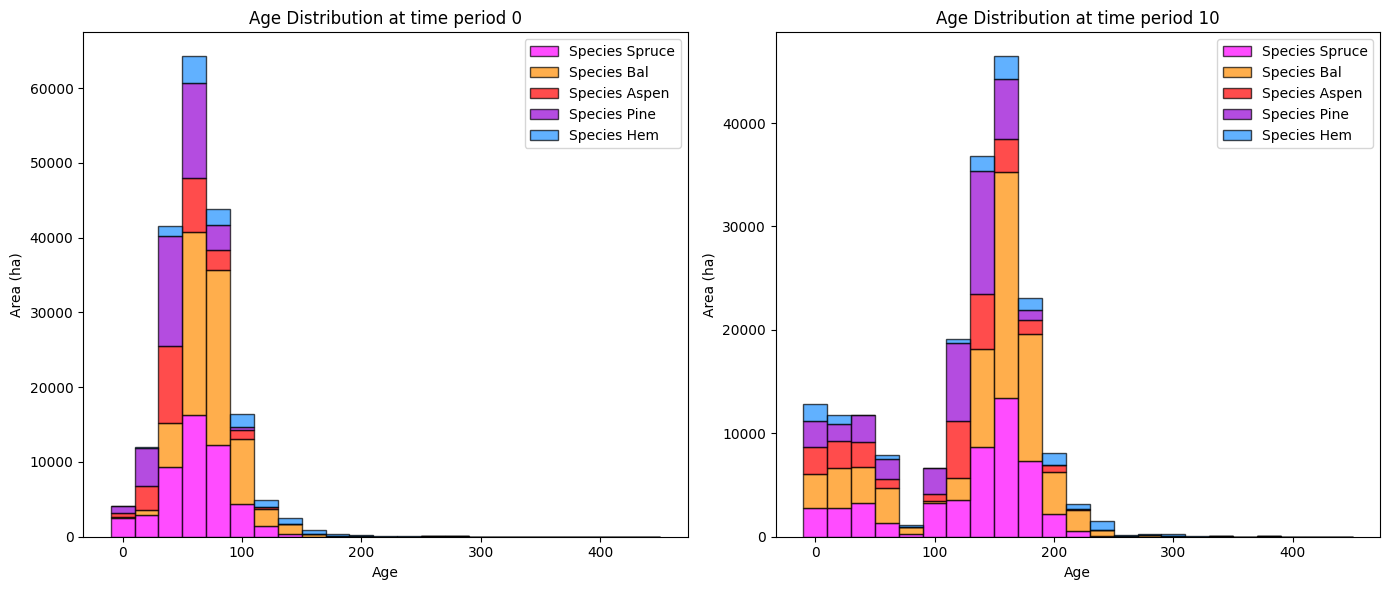

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_50%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   7052.563731   7049.855198
Bal     278.565372  13801.120392  13522.555021
Aspen   273.490478   9214.579782   8941.089304
Pine      0.000000   5872.224993   5872.224993
Hem     419.699331   3063.404245   2643.704915

Overall diversity has **increased** by 38029.43 hectares from time period 0 to time period 10.


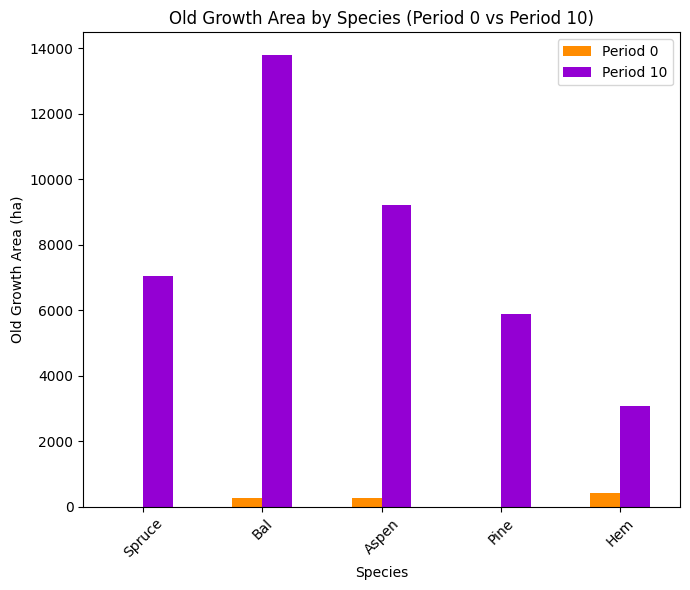

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_50%_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2663
Bal: 0.3690
Aspen: 0.1137
Pine: 0.1656
Hem: 0.0854

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9167

Diversity has **decreased** by 2.89% from time 0 to time 10.


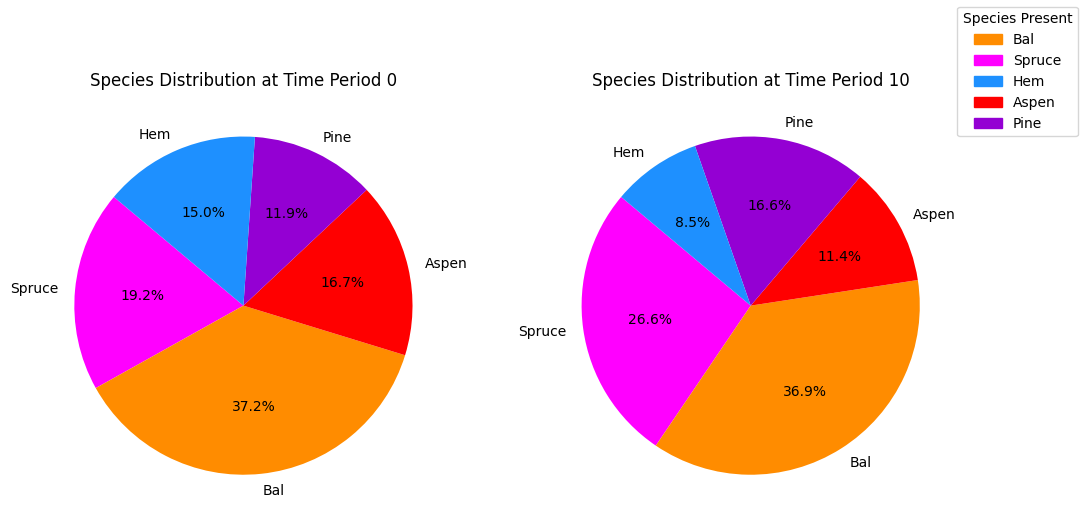

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_50%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Saved cbm_output_3 and cbm_output_4 as pickle files.


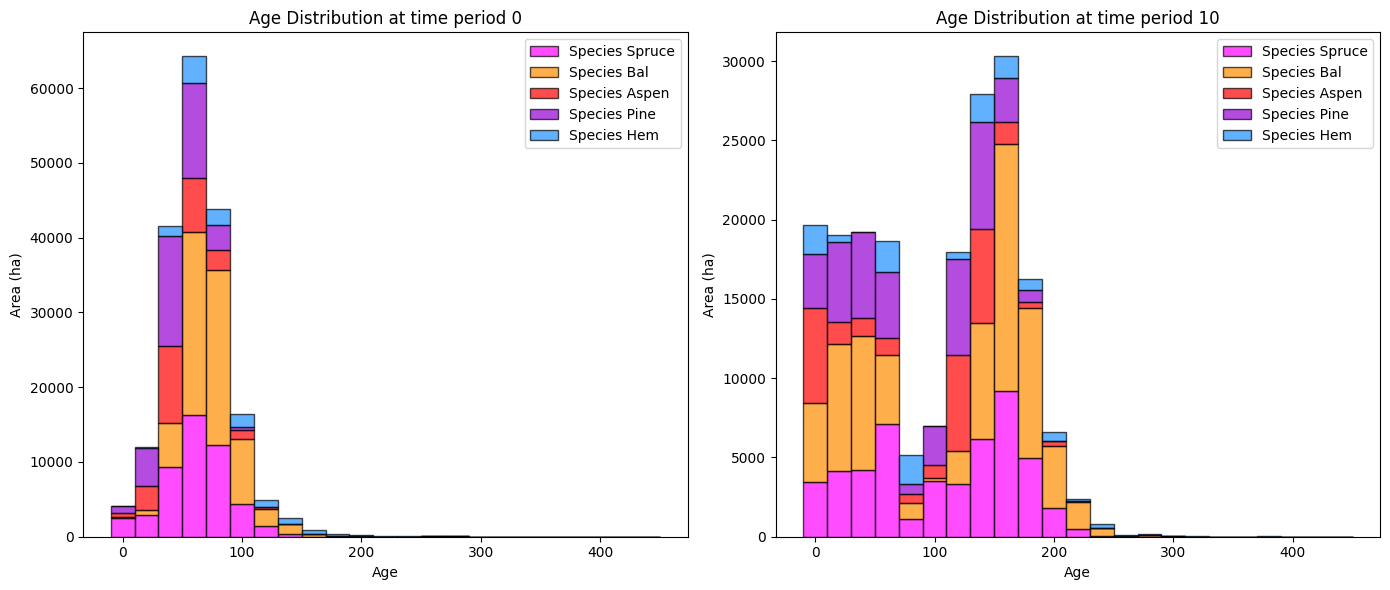

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4624.091497   4621.382963
Bal     278.565372  11130.044561  10851.479189
Aspen   273.490478   6117.315597   5843.825119
Pine      0.000000   3444.407631   3444.407631
Hem     419.699331   1309.461400    889.762069

Overall diversity has **increased** by 25650.86 hectares from time period 0 to time period 10.


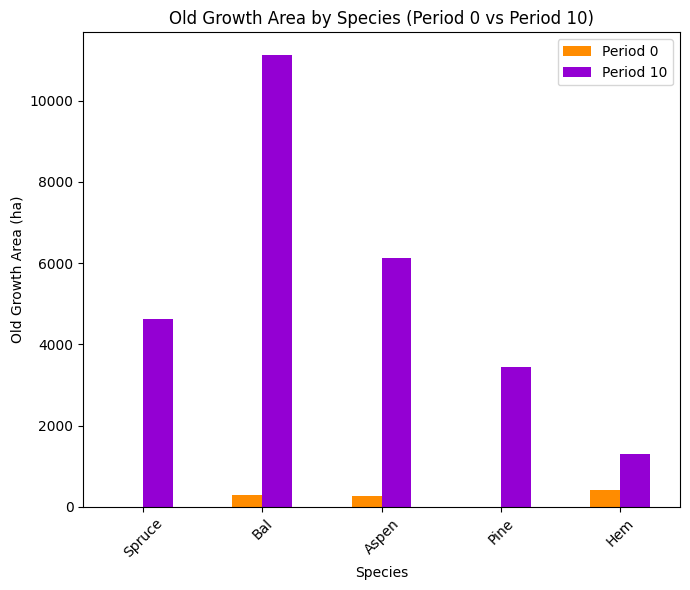

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2509
Bal: 0.3750
Aspen: 0.1338
Pine: 0.1506
Hem: 0.0896

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9228

Diversity has **decreased** by 2.27% from time 0 to time 10.


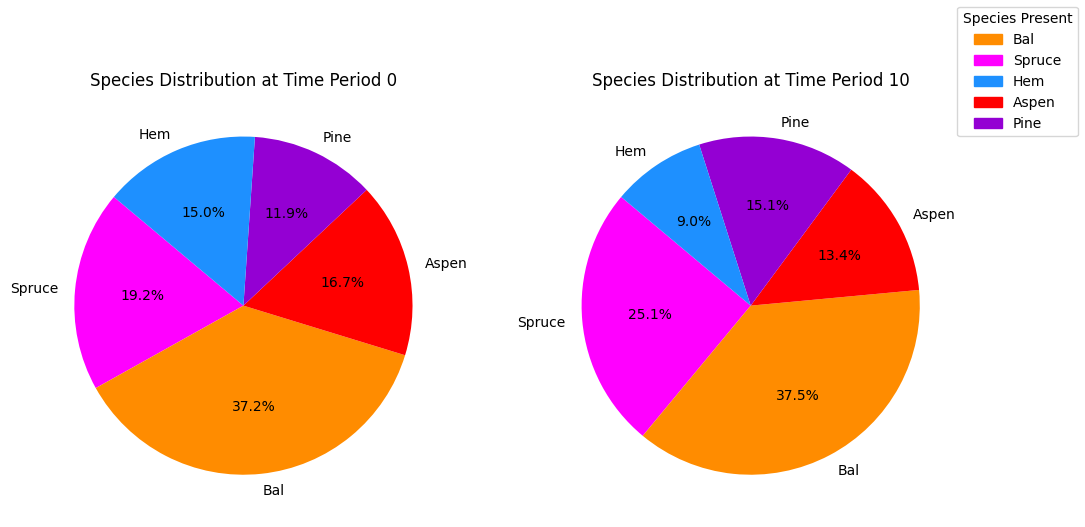

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_species_pie.pdf


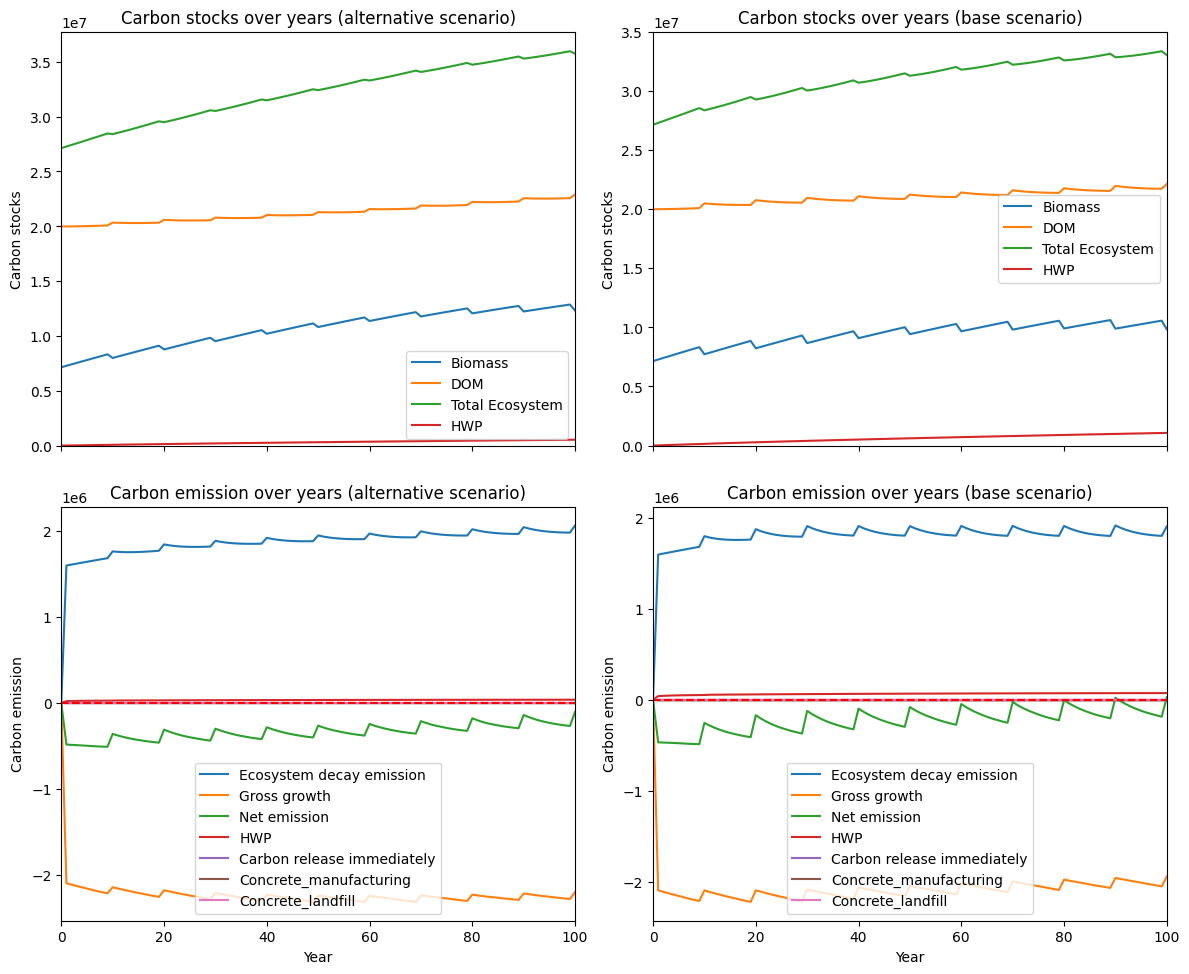

---------------------------------------------------------------------------------------
Net emission difference -1488806.0274064825
Net emission base scenario -10446678.977441365
Net emission alternative scenario -8957872.950034881
dollar_per_ton is:  6.716791721632211
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  2428.472234  2428.472234
Bal     0.0  2671.075831  2671.075831
Aspen   0.0  3097.264185  3097.264185
Pine    0.0  2427.817362  2427.817362
Hem     0.0  1753.942845  1753.942845

Overall, the old growth area has **increased** by 12378.57 hectares in the alternative scenario compared to the base scenario.


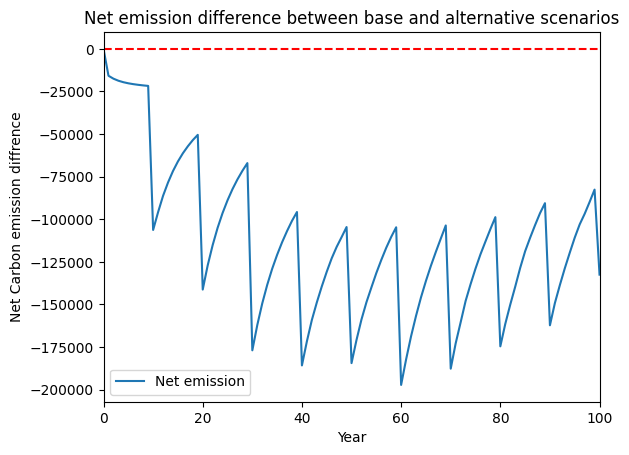

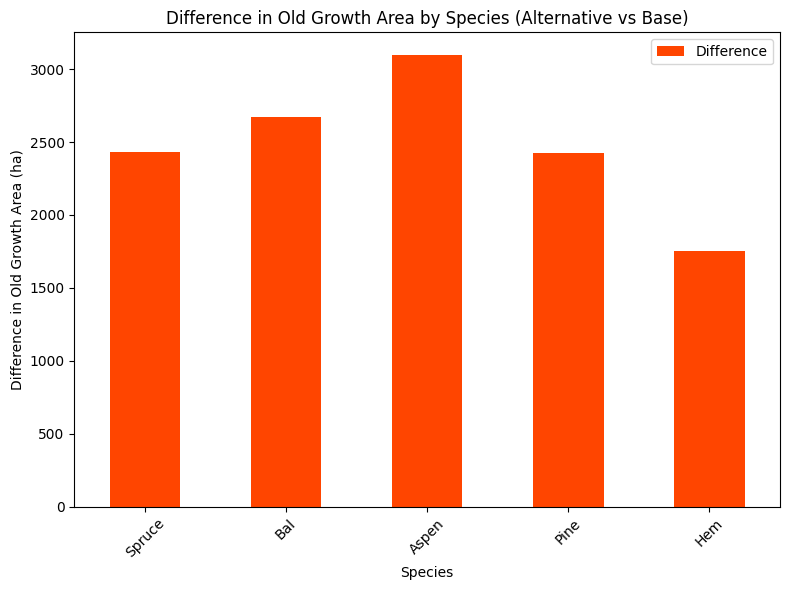

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_age_difference.pdf


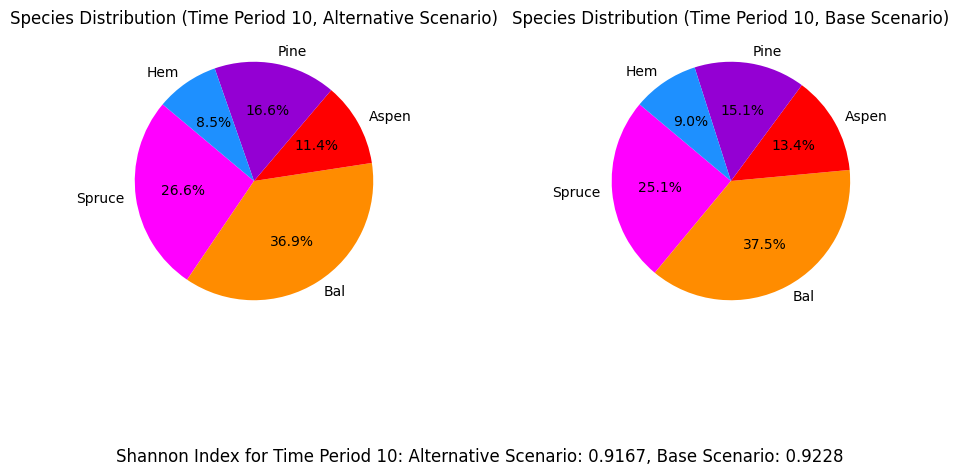

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_hv_gldbr_AAC_40%...
running the scenario for the Golden Bear mining site (40%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x7d8550f0
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.18s
Presolved: 1911 rows, 32226 

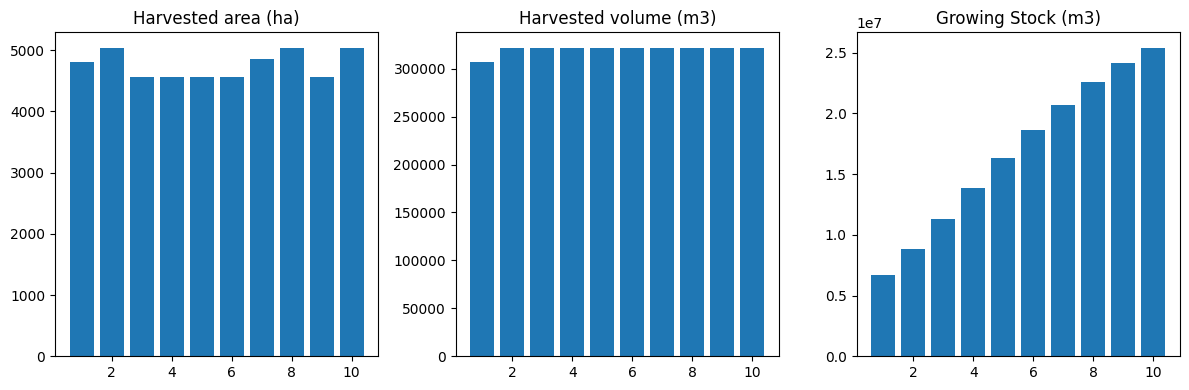

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_40%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  3385
The economic indicator (the provincial government revenues) is:  115448
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


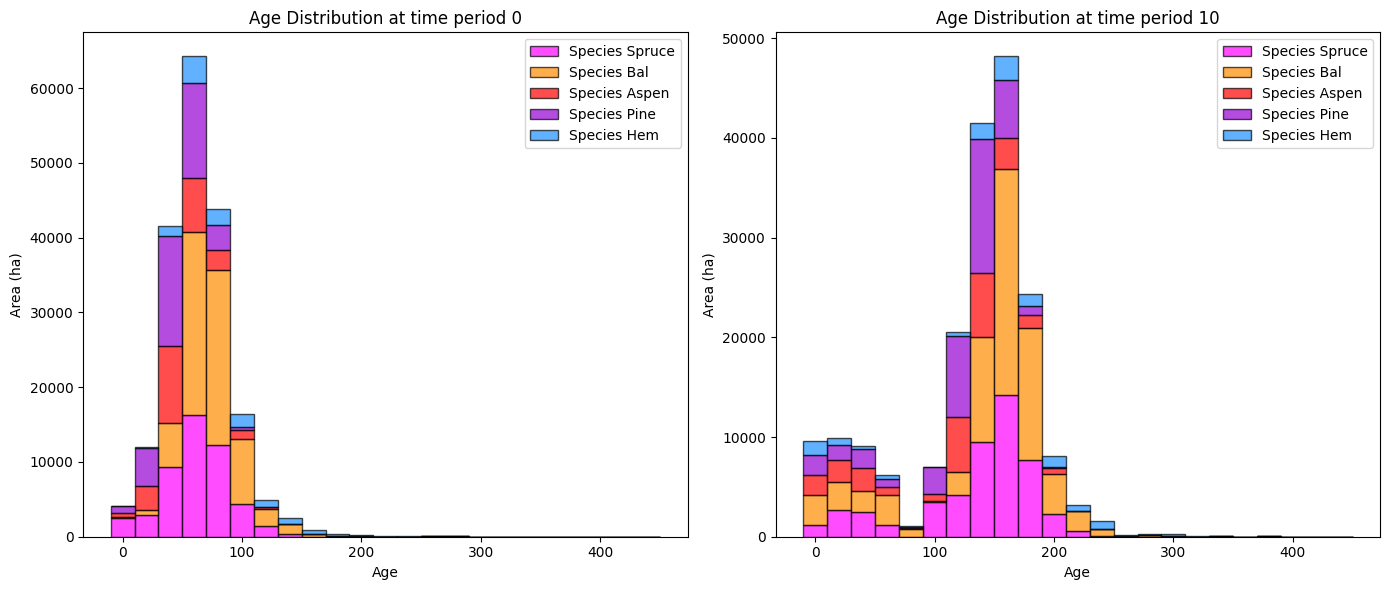

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_40%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   7430.997675   7428.289142
Bal     278.565372  14274.949868  13996.384496
Aspen   273.490478   9688.455104   9414.964625
Pine      0.000000   6113.864875   6113.864875
Hem     419.699331   3187.185118   2767.485787

Overall diversity has **increased** by 39720.99 hectares from time period 0 to time period 10.


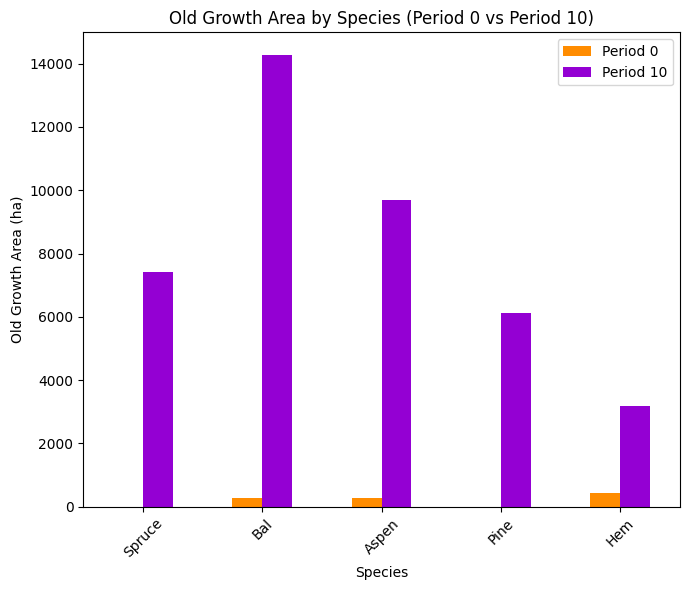

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_40%_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2712
Bal: 0.3653
Aspen: 0.1127
Pine: 0.1661
Hem: 0.0847

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9165

Diversity has **decreased** by 2.90% from time 0 to time 10.


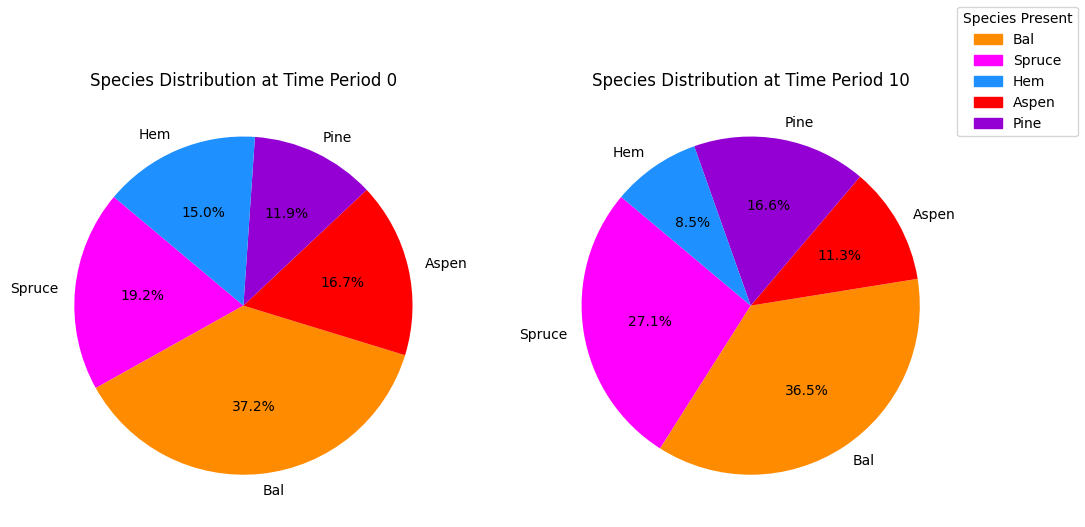

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_40%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xb30b6437
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.18s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

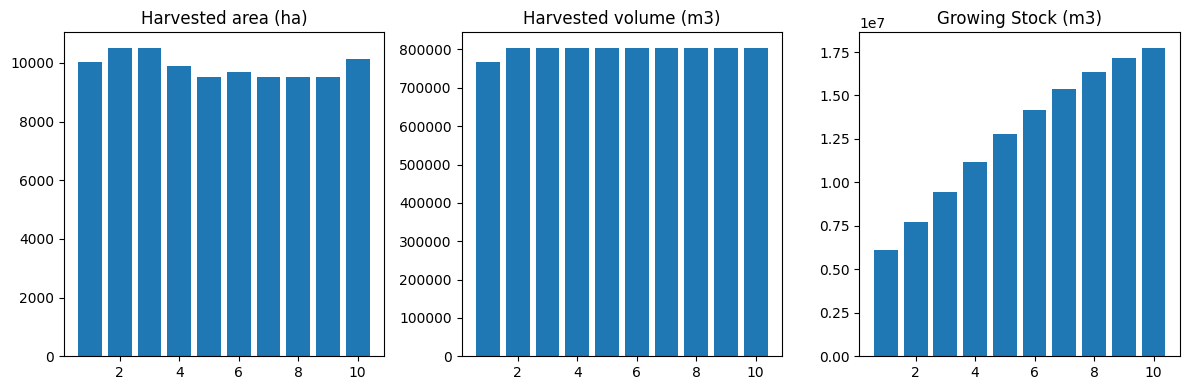

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  8463
The economic indicator (the provincial government revenues) is:  288619
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


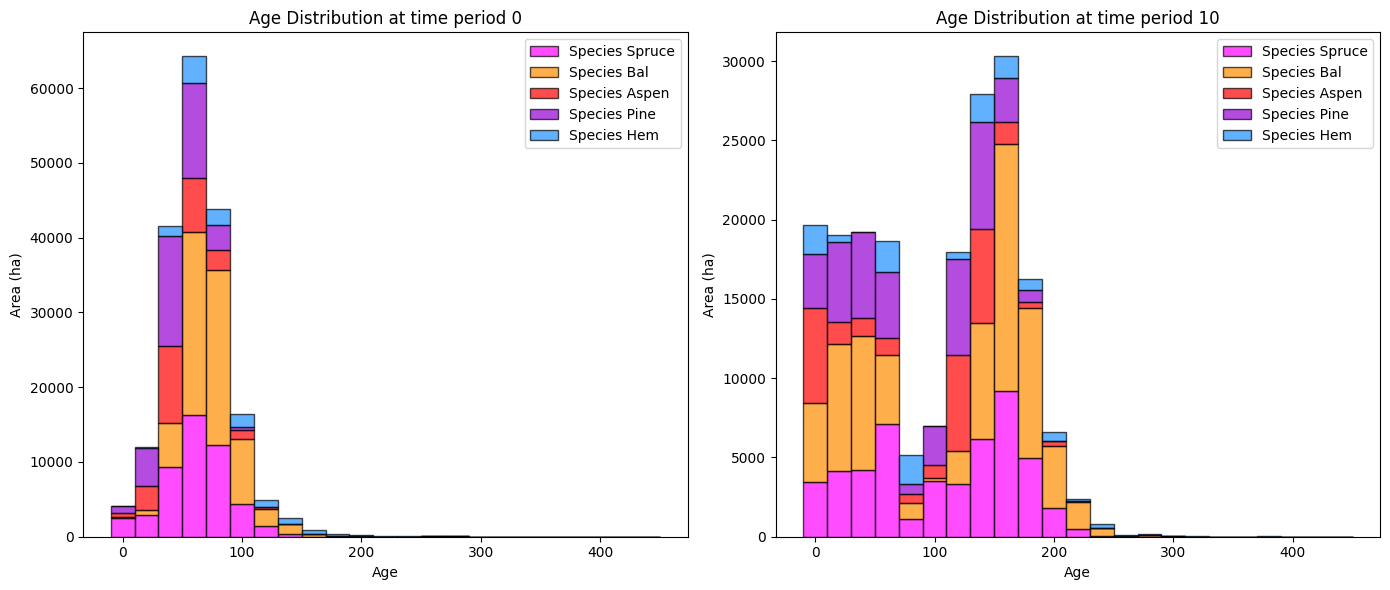

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4624.091497   4621.382963
Bal     278.565372  11130.044561  10851.479189
Aspen   273.490478   6117.315597   5843.825119
Pine      0.000000   3444.407631   3444.407631
Hem     419.699331   1309.461400    889.762069

Overall diversity has **increased** by 25650.86 hectares from time period 0 to time period 10.


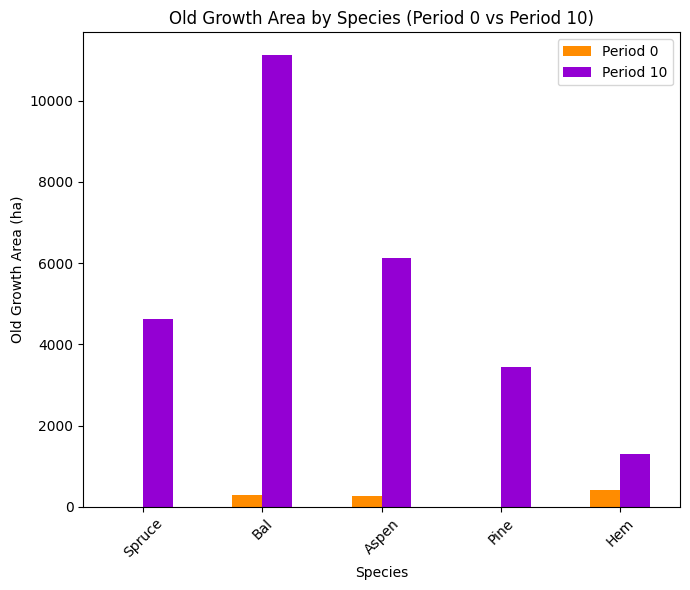

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2509
Bal: 0.3750
Aspen: 0.1338
Pine: 0.1506
Hem: 0.0896

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9228

Diversity has **decreased** by 2.27% from time 0 to time 10.


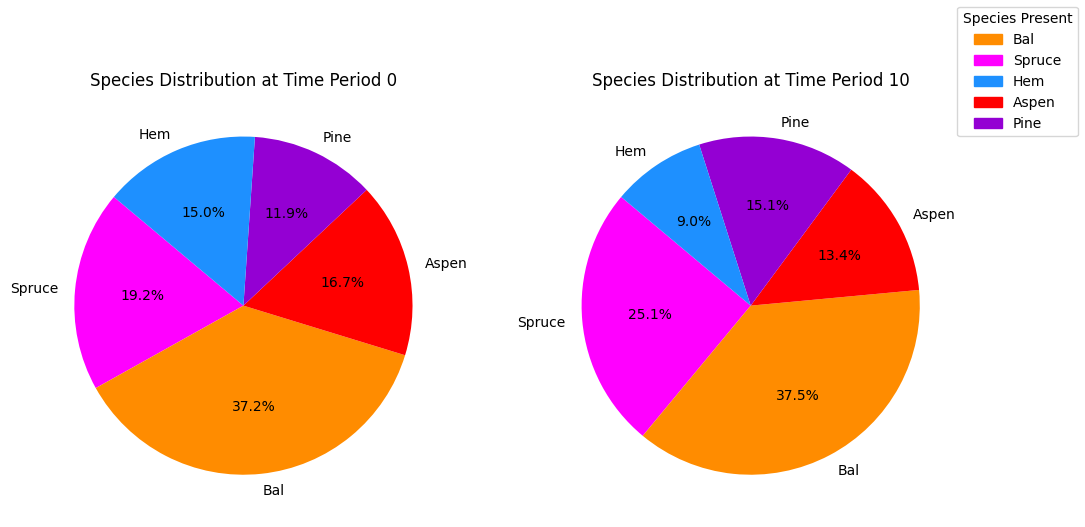

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_species_pie.pdf


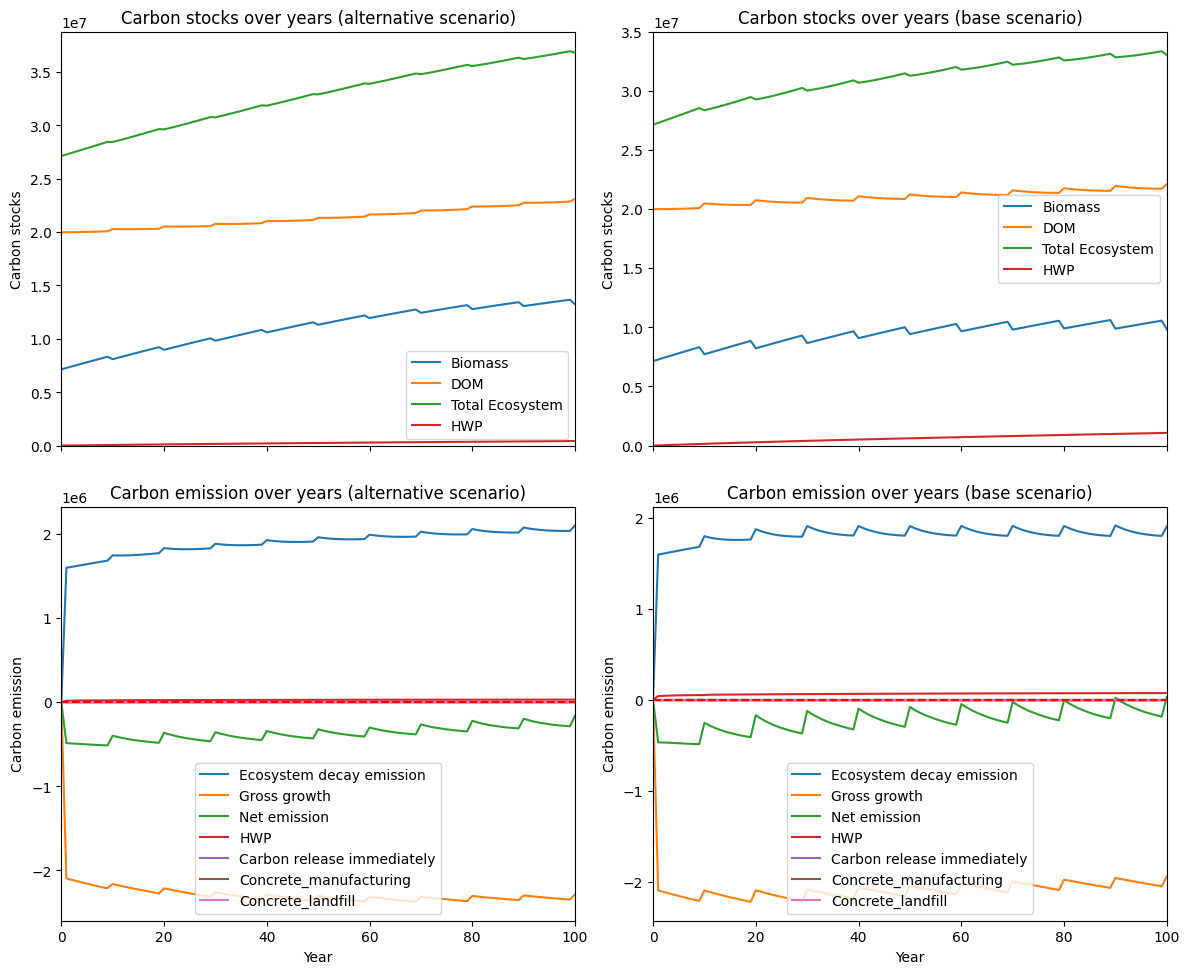

---------------------------------------------------------------------------------------
Net emission difference -2037437.025111197
Net emission base scenario -10995309.975146078
Net emission alternative scenario -8957872.950034881
dollar_per_ton is:  4.908127160128657
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  2806.906179  2806.906179
Bal     0.0  3144.905307  3144.905307
Aspen   0.0  3571.139506  3571.139506
Pine    0.0  2669.457244  2669.457244
Hem     0.0  1877.723718  1877.723718

Overall, the old growth area has **increased** by 14070.13 hectares in the alternative scenario compared to the base scenario.


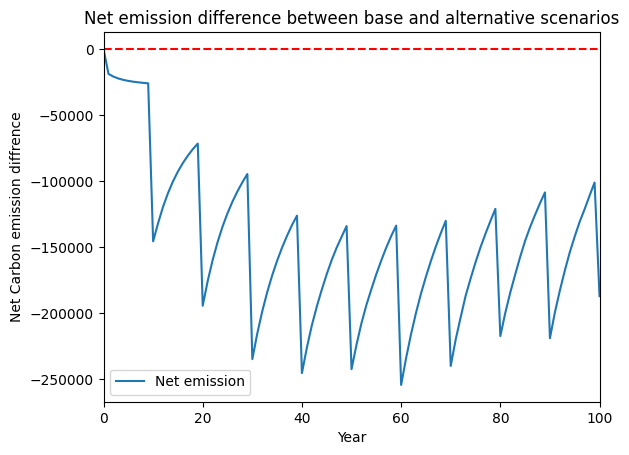

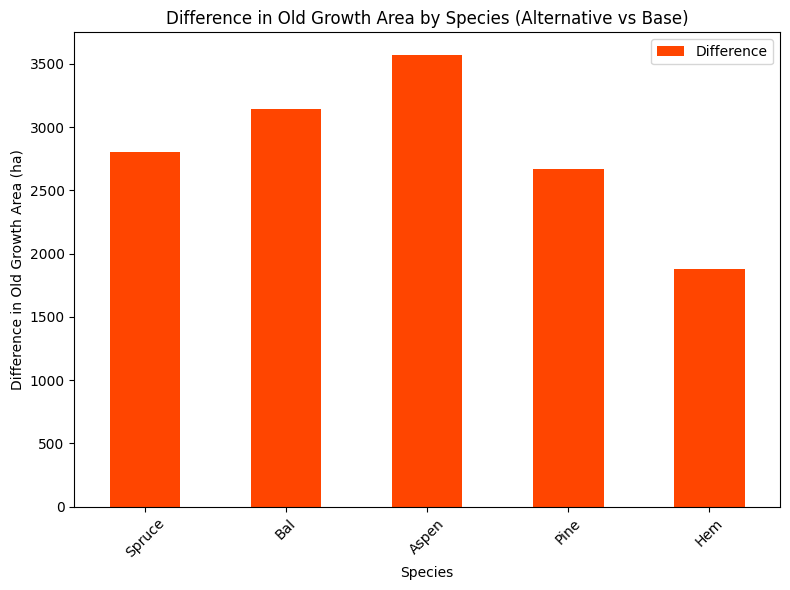

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_age_difference.pdf


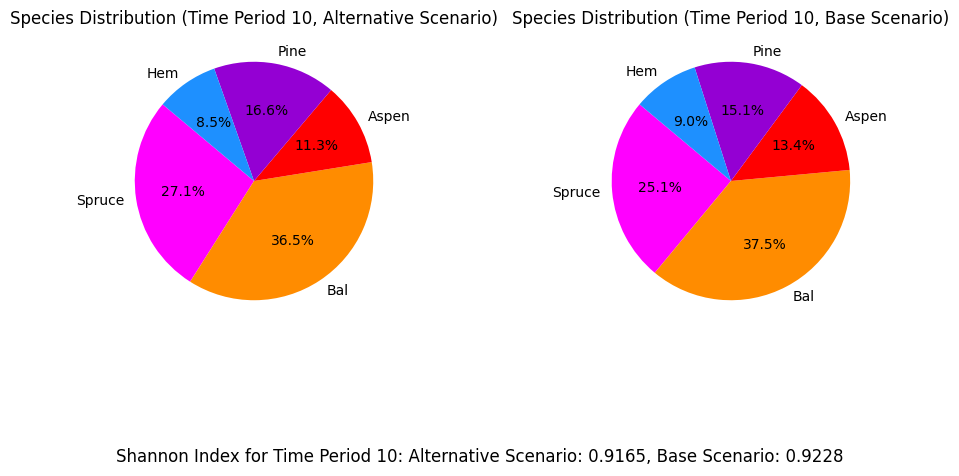

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_hv_gldbr_AAC_30%...
running the scenario for the Golden Bear mining site (30%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x1926171d
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.27s
Presolved: 1911 rows, 32226 

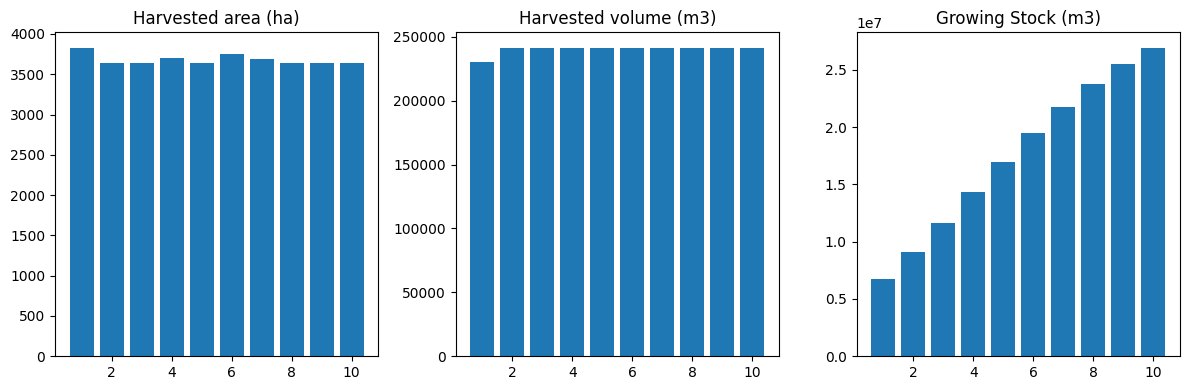

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_30%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  2539
The economic indicator (the provincial government revenues) is:  86586
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


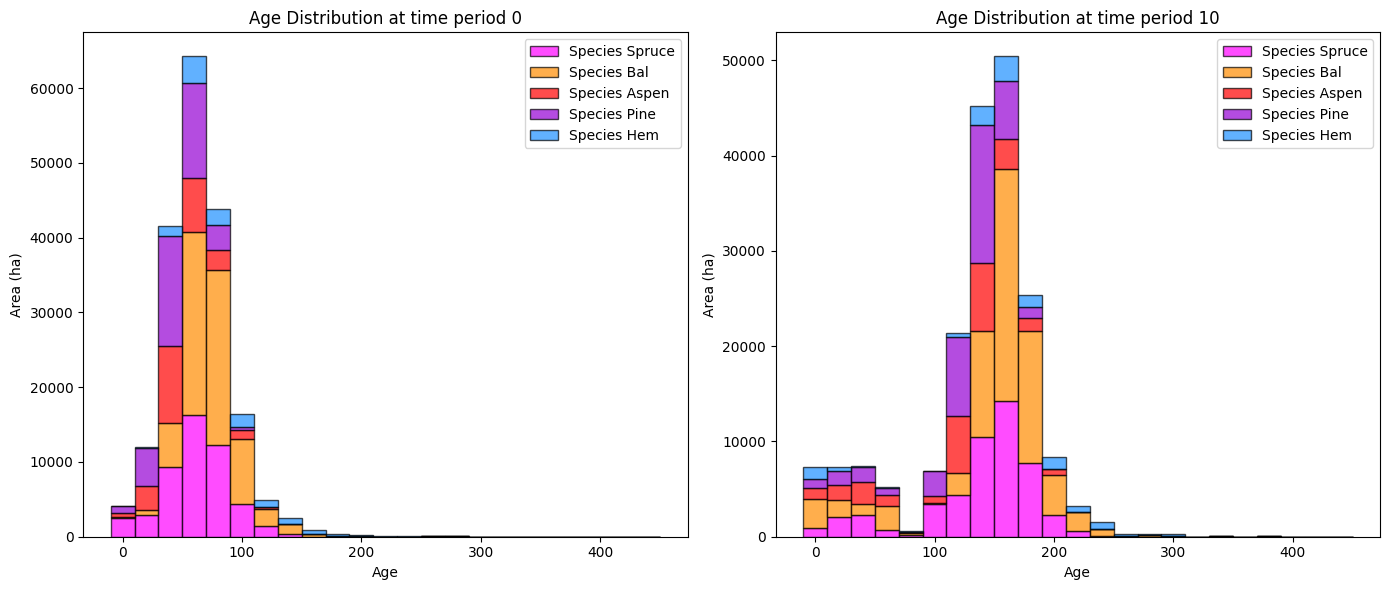

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_30%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   7550.930066   7548.221532
Bal     278.565372  14943.657725  14665.092353
Aspen   273.490478  10220.383421   9946.892943
Pine      0.000000   6552.127115   6552.127115
Hem     419.699331   3410.492901   2990.793570

Overall diversity has **increased** by 41703.13 hectares from time period 0 to time period 10.


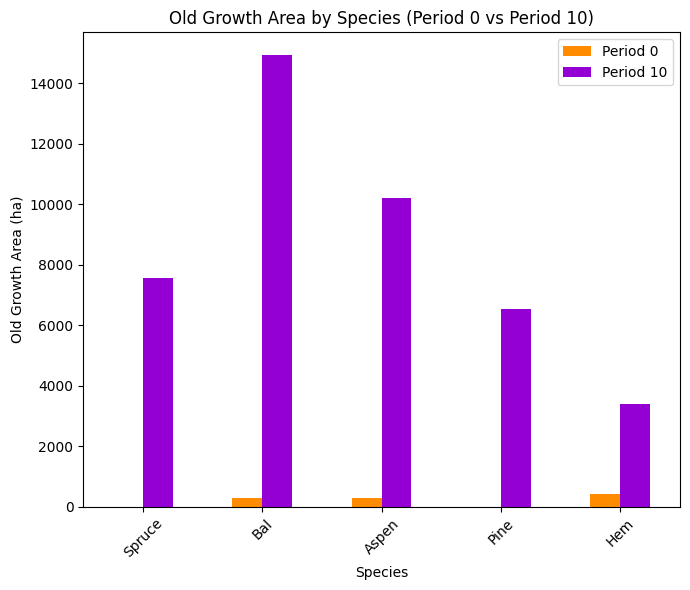

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_30%_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2657
Bal: 0.3661
Aspen: 0.1132
Pine: 0.1655
Hem: 0.0896

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9198

Diversity has **decreased** by 2.57% from time 0 to time 10.


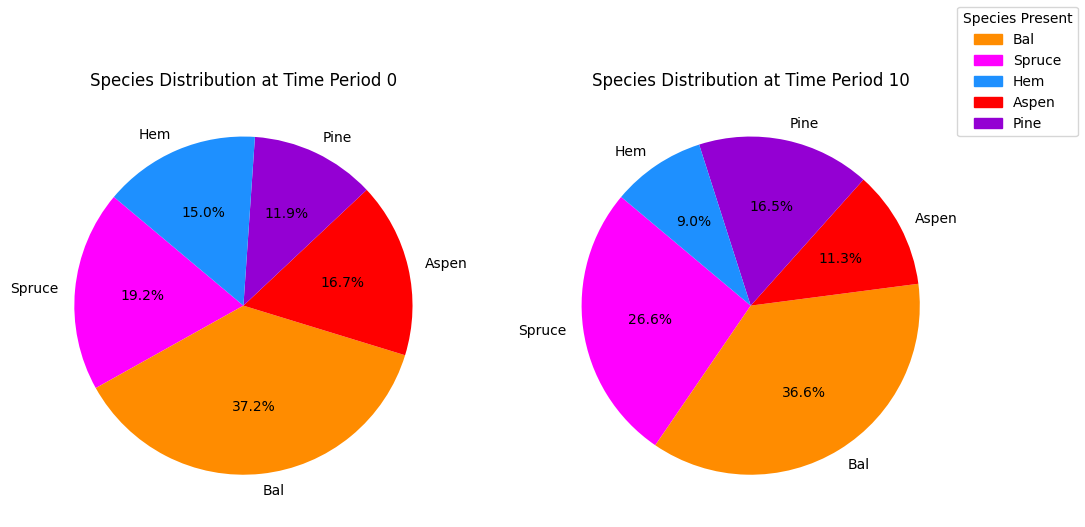

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_30%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xb30b6437
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.17s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

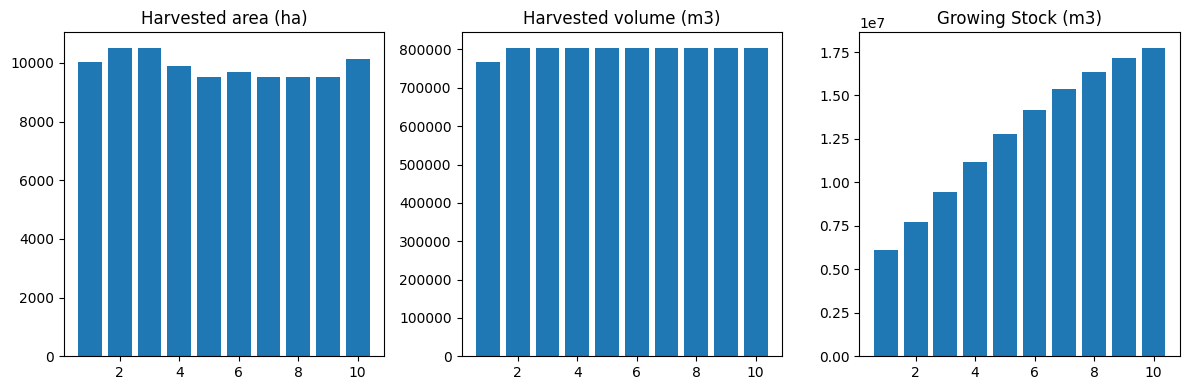

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  8463
The economic indicator (the provincial government revenues) is:  288619
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


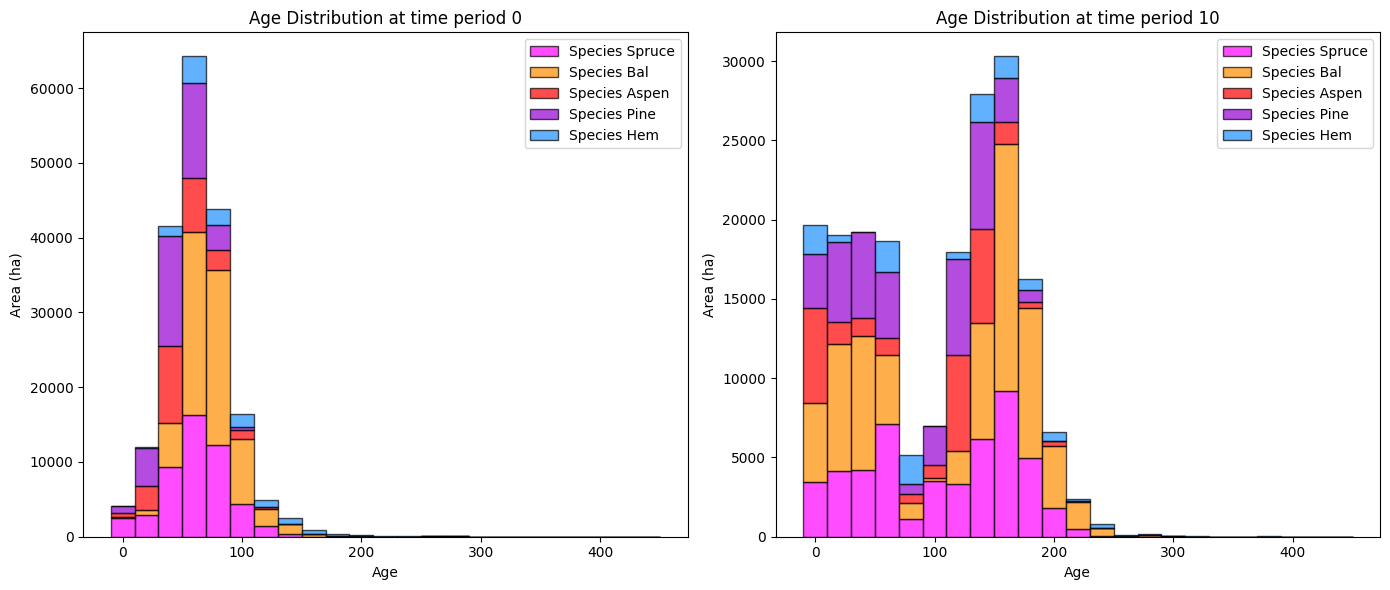

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4624.091497   4621.382963
Bal     278.565372  11130.044561  10851.479189
Aspen   273.490478   6117.315597   5843.825119
Pine      0.000000   3444.407631   3444.407631
Hem     419.699331   1309.461400    889.762069

Overall diversity has **increased** by 25650.86 hectares from time period 0 to time period 10.


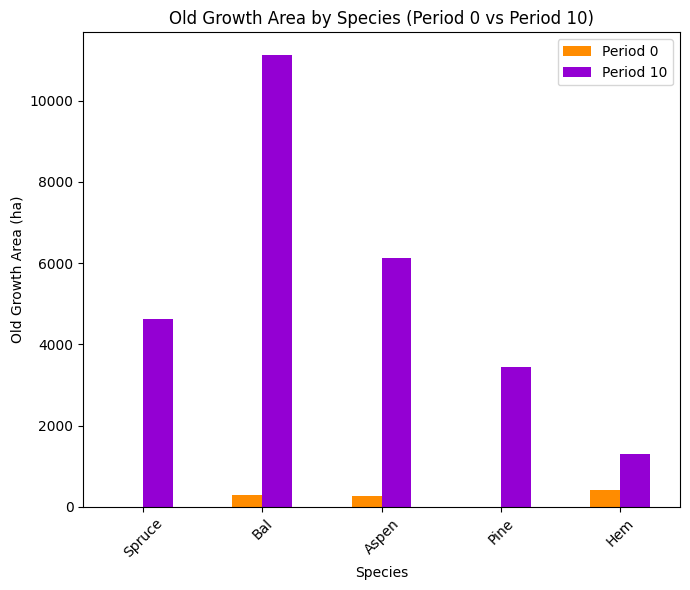

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2509
Bal: 0.3750
Aspen: 0.1338
Pine: 0.1506
Hem: 0.0896

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9228

Diversity has **decreased** by 2.27% from time 0 to time 10.


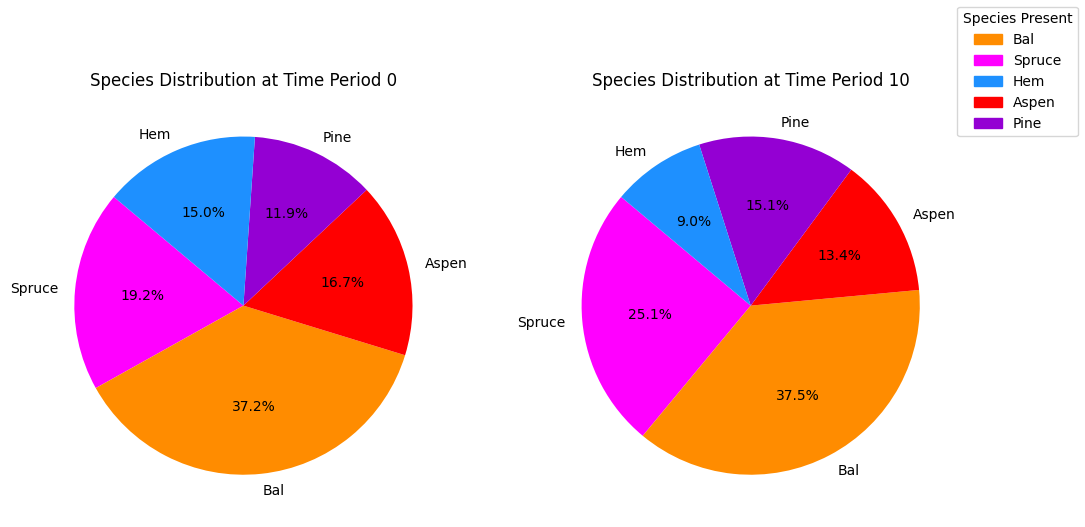

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_species_pie.pdf


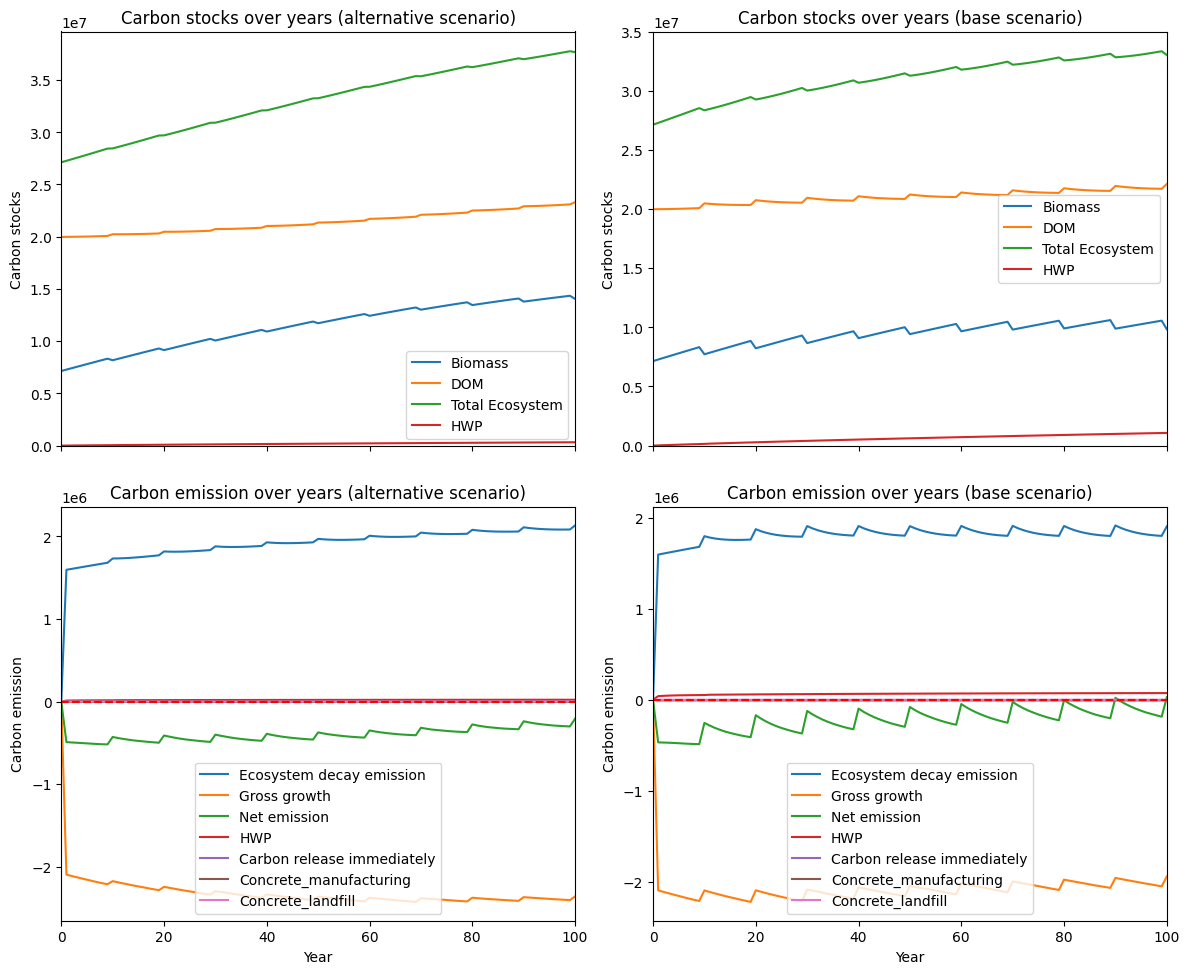

---------------------------------------------------------------------------------------
Net emission difference -2468487.0882711126
Net emission base scenario -11426360.038305992
Net emission alternative scenario -8957872.950034881
dollar_per_ton is:  4.051064333094743
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  2926.838569  2926.838569
Bal     0.0  3813.613164  3813.613164
Aspen   0.0  4103.067824  4103.067824
Pine    0.0  3107.719484  3107.719484
Hem     0.0  2101.031501  2101.031501

Overall, the old growth area has **increased** by 16052.27 hectares in the alternative scenario compared to the base scenario.


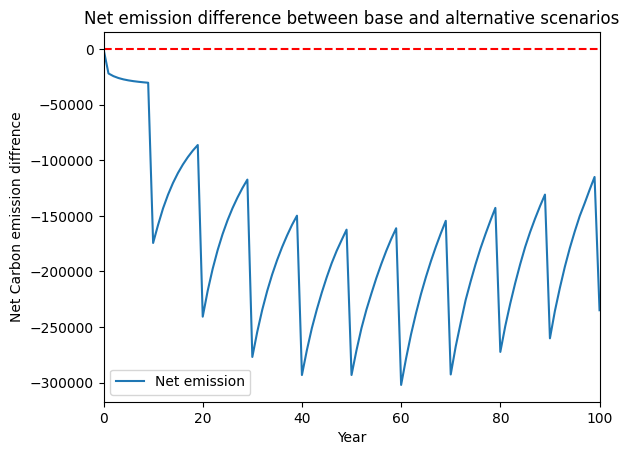

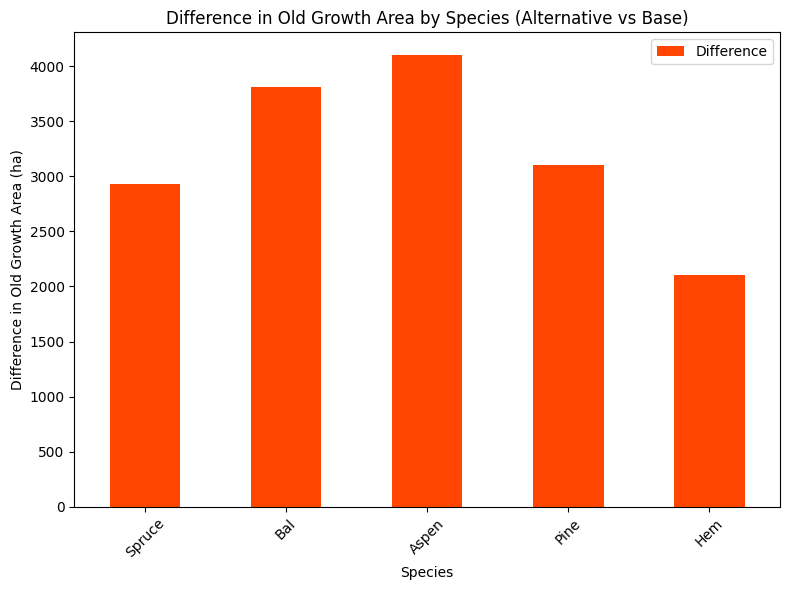

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_age_difference.pdf


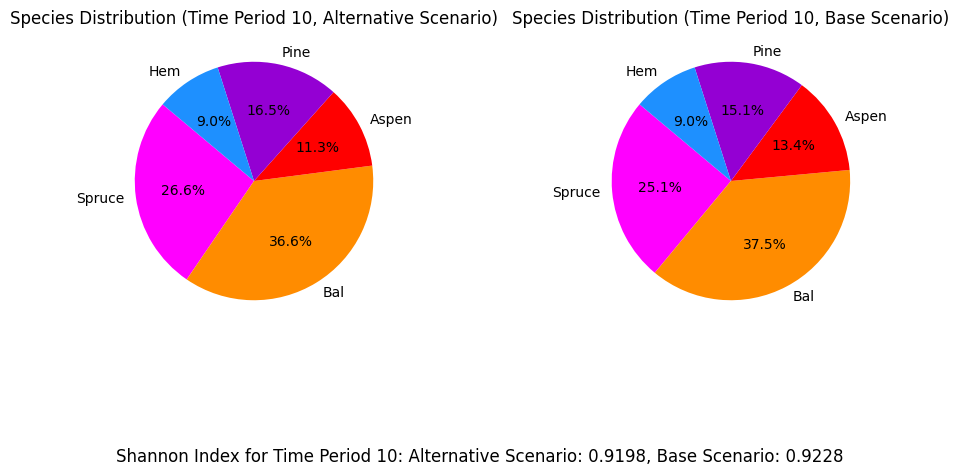

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_hv_gldbr_AAC_20%...
running the scenario for the Golden Bear mining site (20%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xb9629efc
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.19s
Presolved: 1911 rows, 32226 

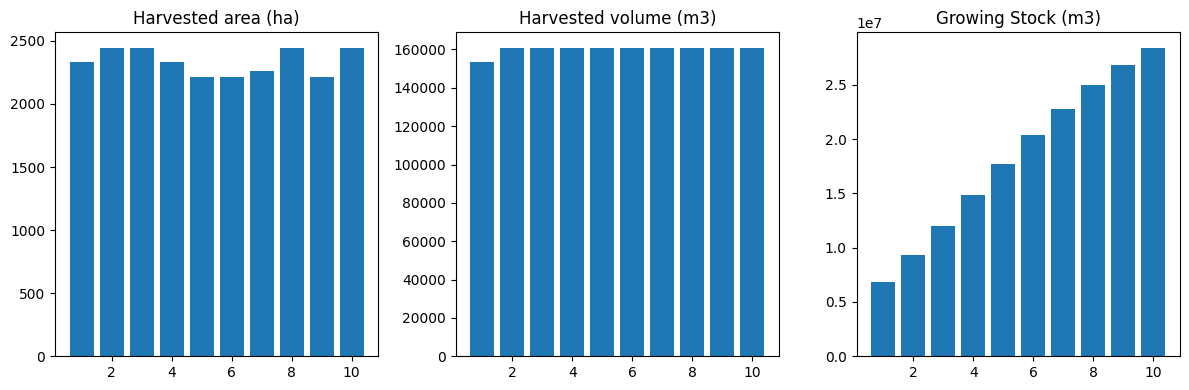

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_20%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  1692
The economic indicator (the provincial government revenues) is:  57724
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


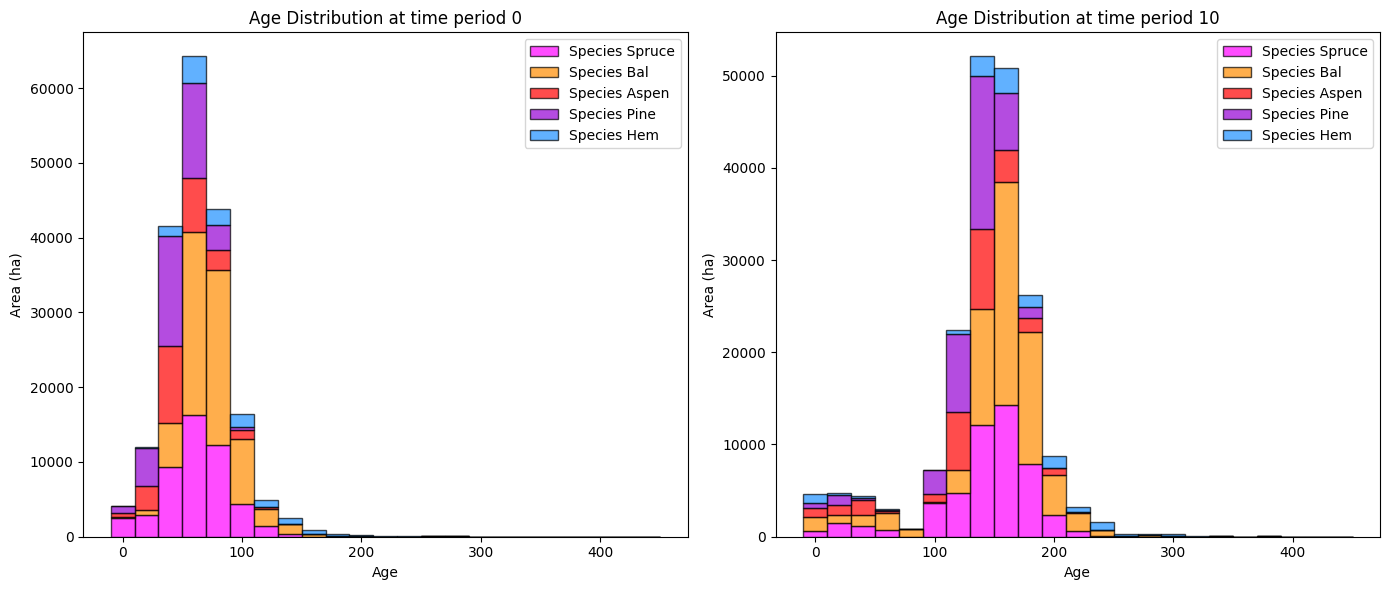

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_20%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   7758.310238   7755.601705
Bal     278.565372  15340.348149  15061.782778
Aspen   273.490478  11319.528896  11046.038418
Pine      0.000000   6998.407134   6998.407134
Hem     419.699331   3505.128720   3085.429389

Overall diversity has **increased** by 43947.26 hectares from time period 0 to time period 10.


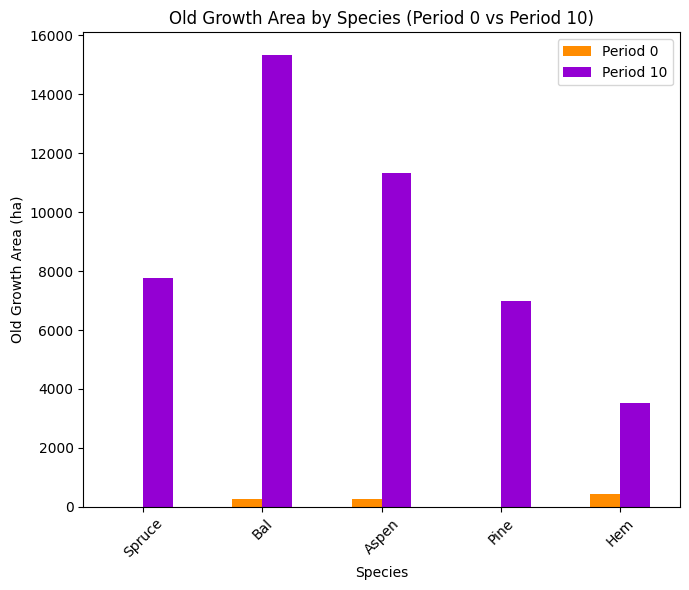

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_20%_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2634
Bal: 0.3620
Aspen: 0.1172
Pine: 0.1701
Hem: 0.0872

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9224

Diversity has **decreased** by 2.31% from time 0 to time 10.


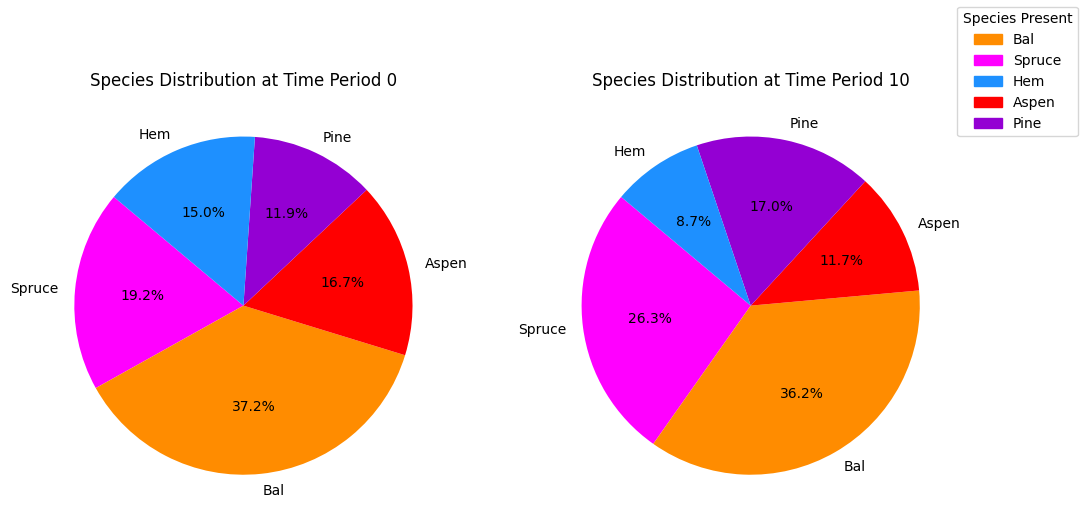

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_20%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xb30b6437
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.19s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

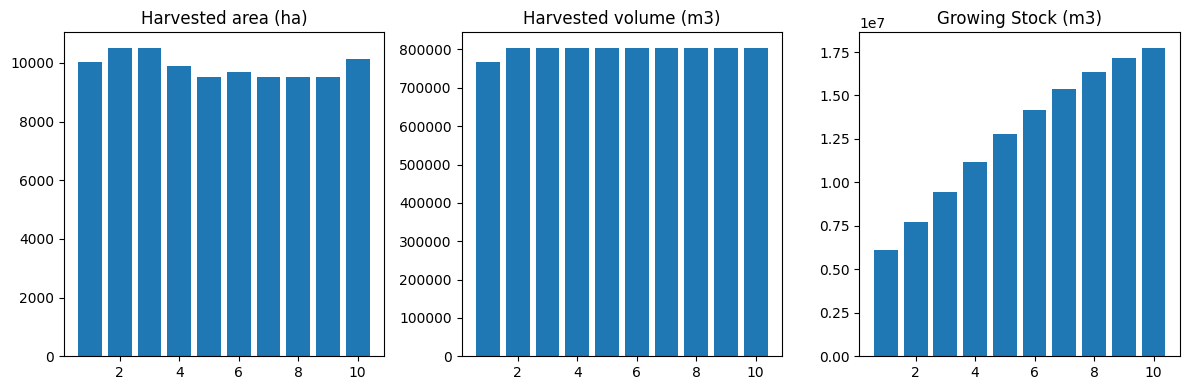

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  8463
The economic indicator (the provincial government revenues) is:  288619
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


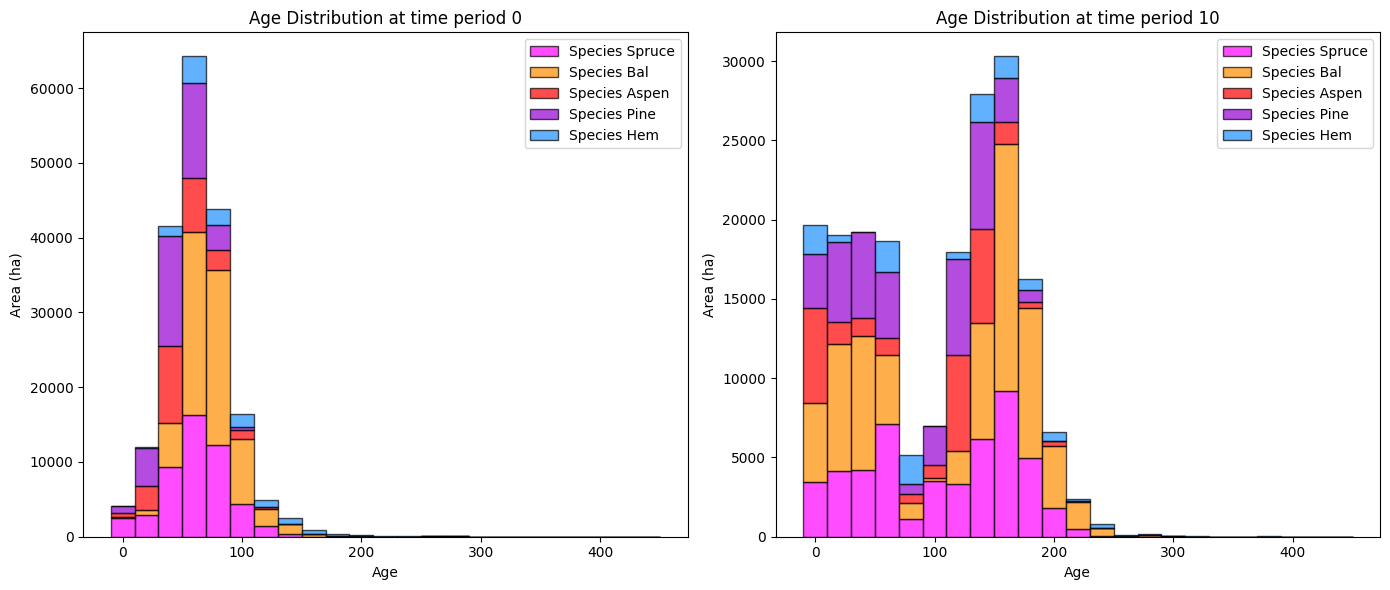

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4624.091497   4621.382963
Bal     278.565372  11130.044561  10851.479189
Aspen   273.490478   6117.315597   5843.825119
Pine      0.000000   3444.407631   3444.407631
Hem     419.699331   1309.461400    889.762069

Overall diversity has **increased** by 25650.86 hectares from time period 0 to time period 10.


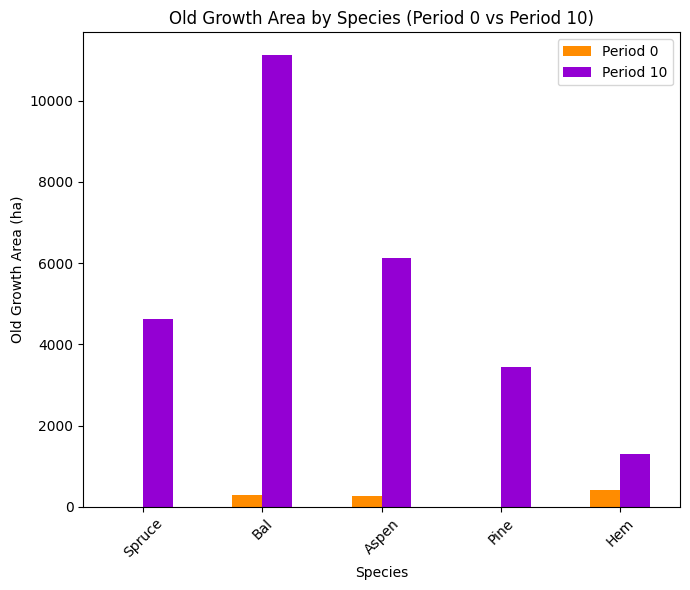

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2509
Bal: 0.3750
Aspen: 0.1338
Pine: 0.1506
Hem: 0.0896

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9228

Diversity has **decreased** by 2.27% from time 0 to time 10.


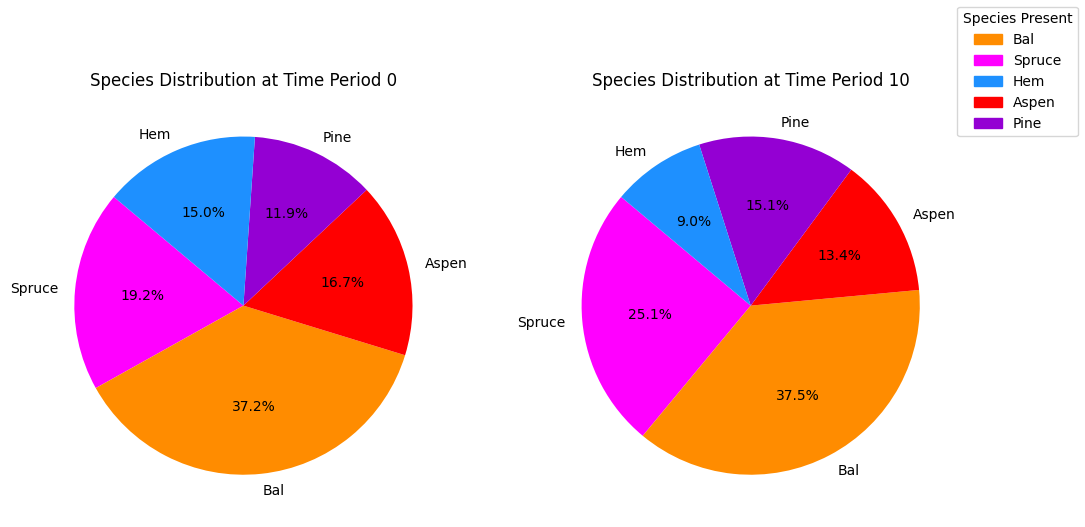

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_species_pie.pdf


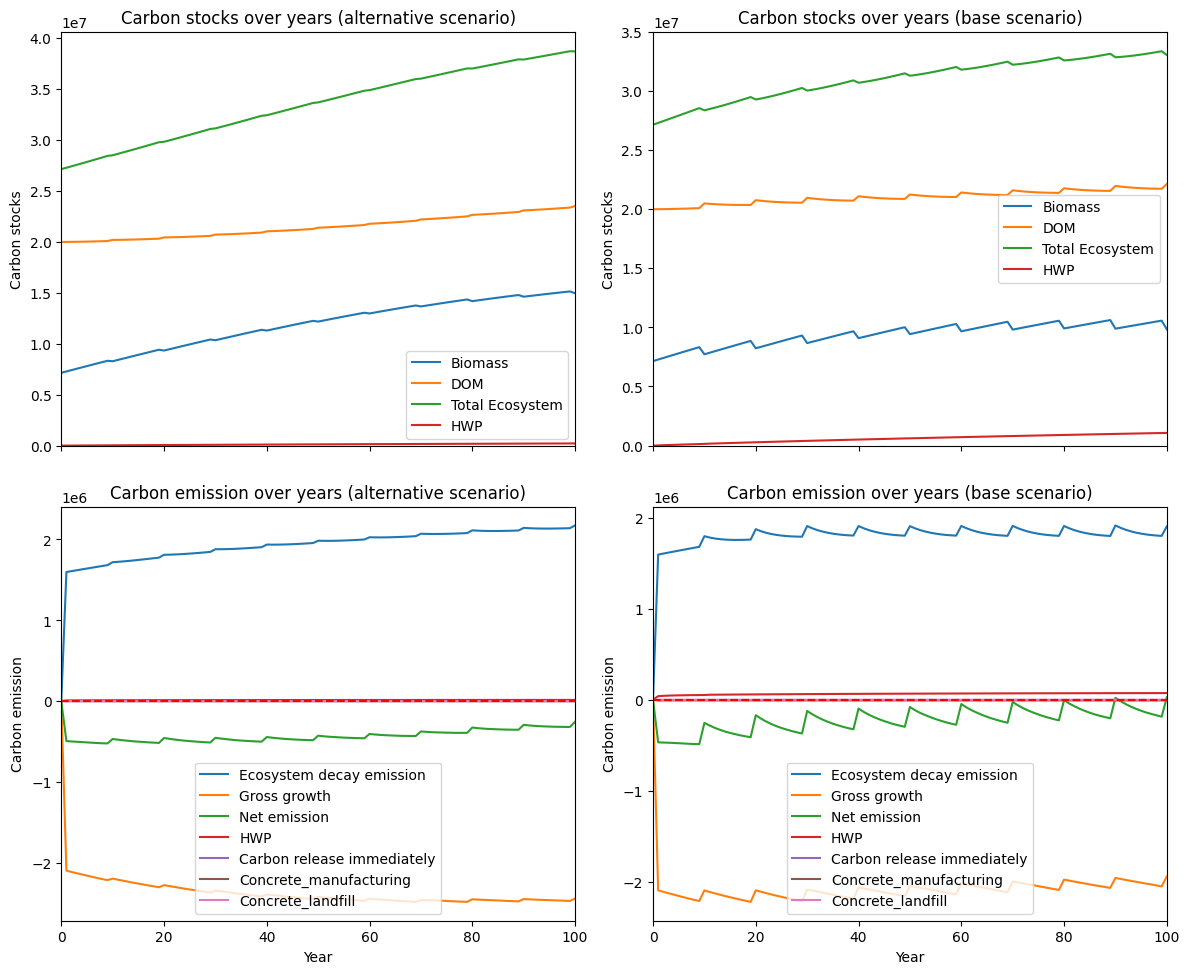

---------------------------------------------------------------------------------------
Net emission difference -2964334.7535642143
Net emission base scenario -11922207.703599093
Net emission alternative scenario -8957872.950034881
dollar_per_ton is:  3.3734381678642547
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  3134.218742  3134.218742
Bal     0.0  4210.303589  4210.303589
Aspen   0.0  5202.213298  5202.213298
Pine    0.0  3553.999503  3553.999503
Hem     0.0  2195.667320  2195.667320

Overall, the old growth area has **increased** by 18296.40 hectares in the alternative scenario compared to the base scenario.


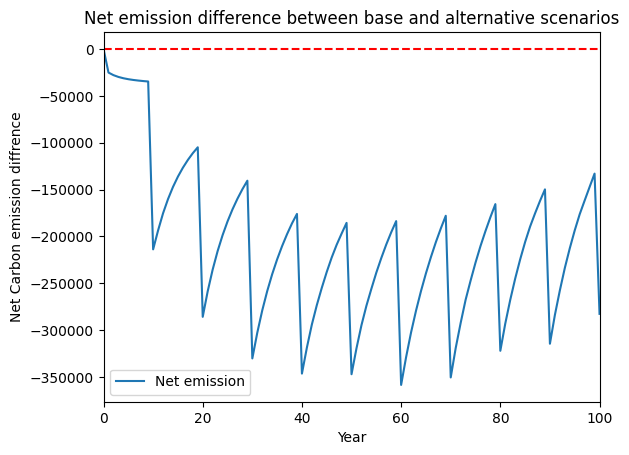

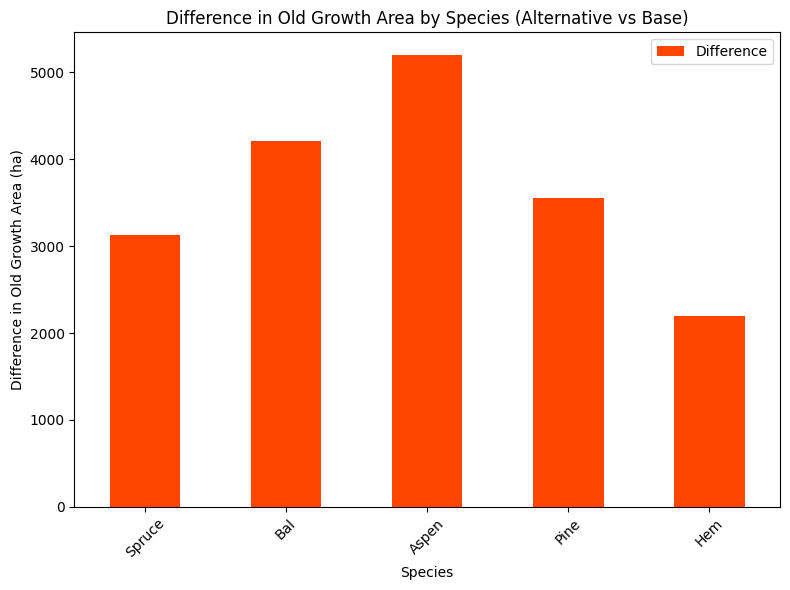

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_age_difference.pdf


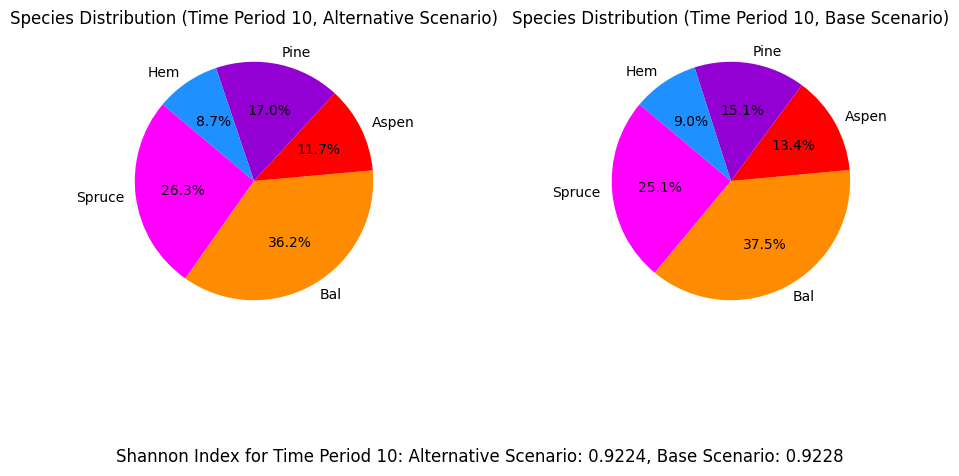

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_max_hv_gldbr_AAC_10%...
running the scenario for the Golden Bear mining site (10%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x3bb725ad
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.17s
Presolved: 1911 rows, 32226 

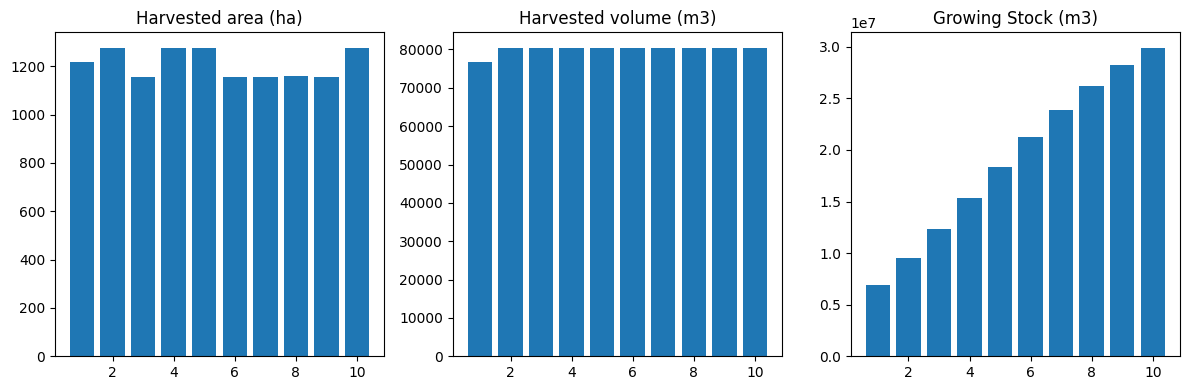

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_10%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  846
The economic indicator (the provincial government revenues) is:  28862
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


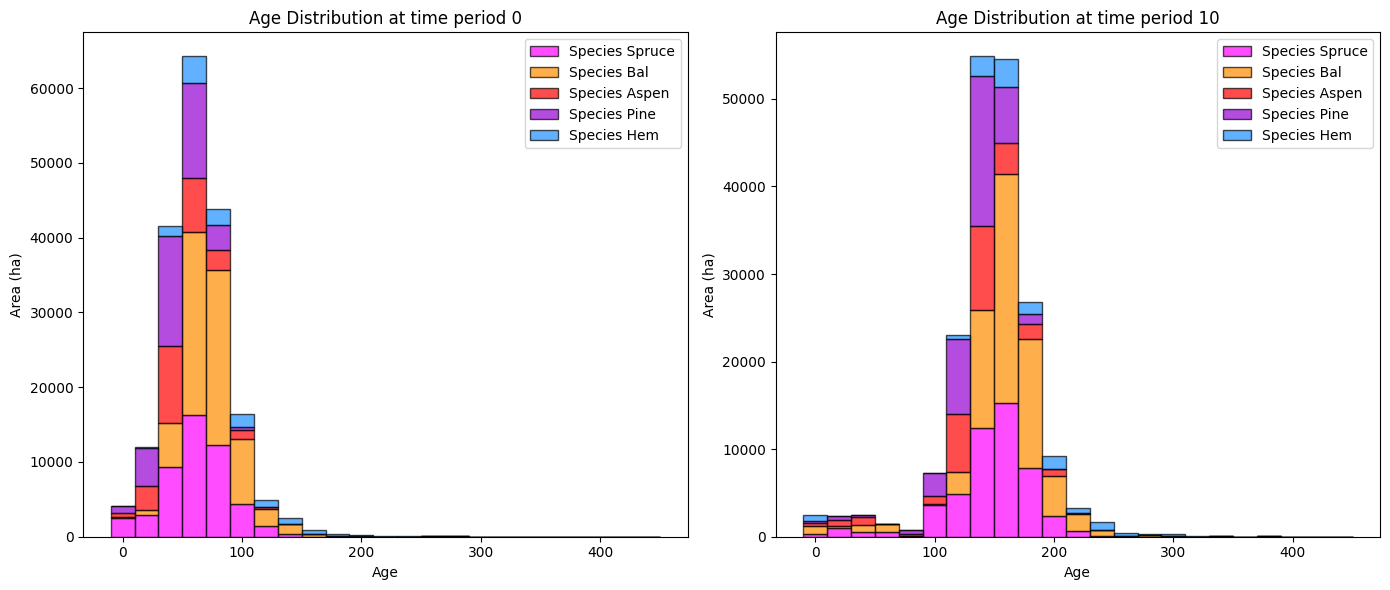

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_10%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   7786.723740   7784.015207
Bal     278.565372  15766.868253  15488.302882
Aspen   273.490478  12271.855408  11998.364930
Pine      0.000000   7207.153023   7207.153023
Hem     419.699331   3737.250659   3317.551328

Overall diversity has **increased** by 45795.39 hectares from time period 0 to time period 10.


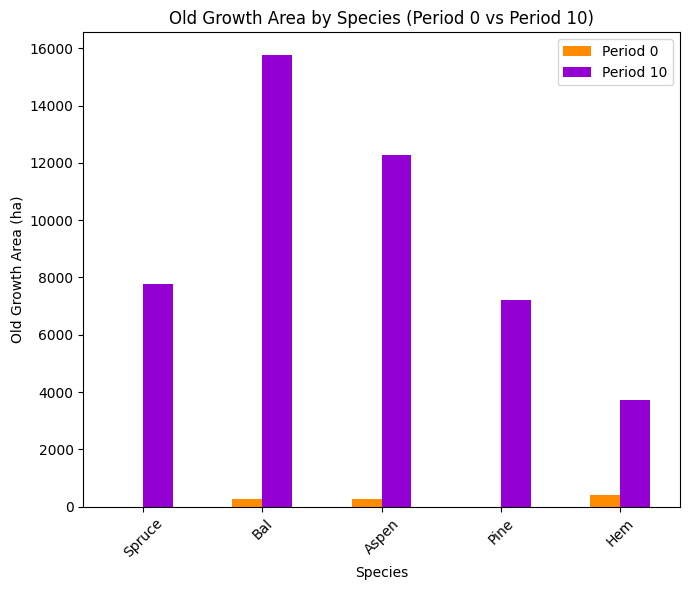

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_10%_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2589
Bal: 0.3626
Aspen: 0.1203
Pine: 0.1655
Hem: 0.0927

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9262

Diversity has **decreased** by 1.94% from time 0 to time 10.


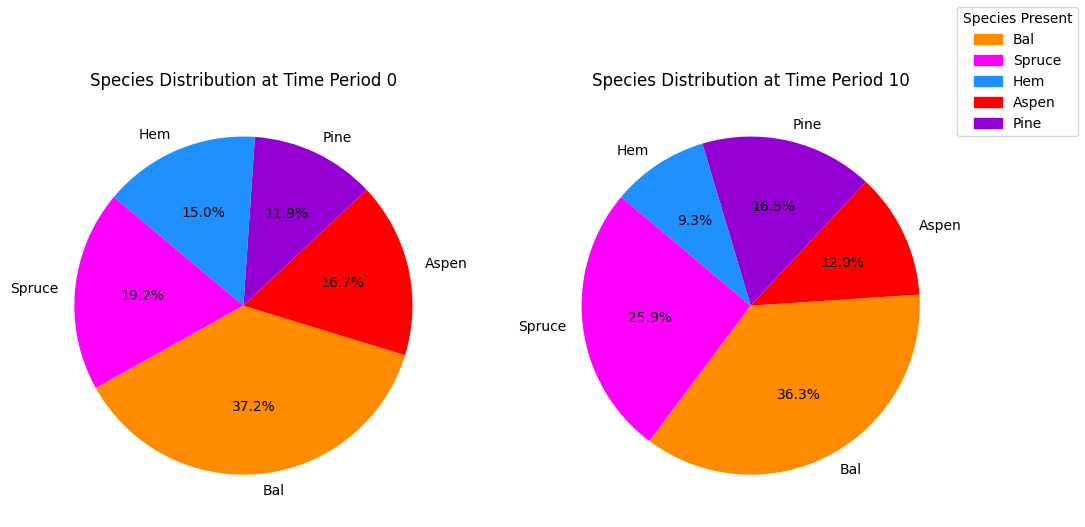

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_gldbr_AAC_10%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xb30b6437
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.15s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

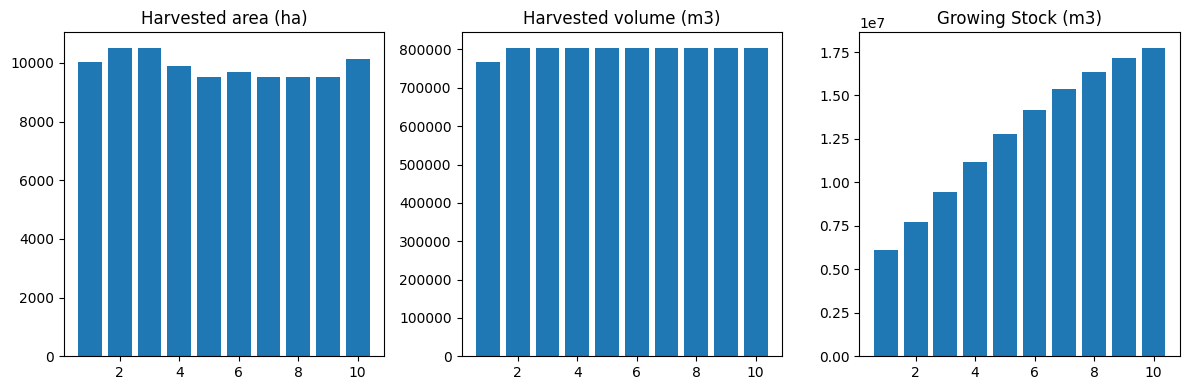

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  8463
The economic indicator (the provincial government revenues) is:  288619
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


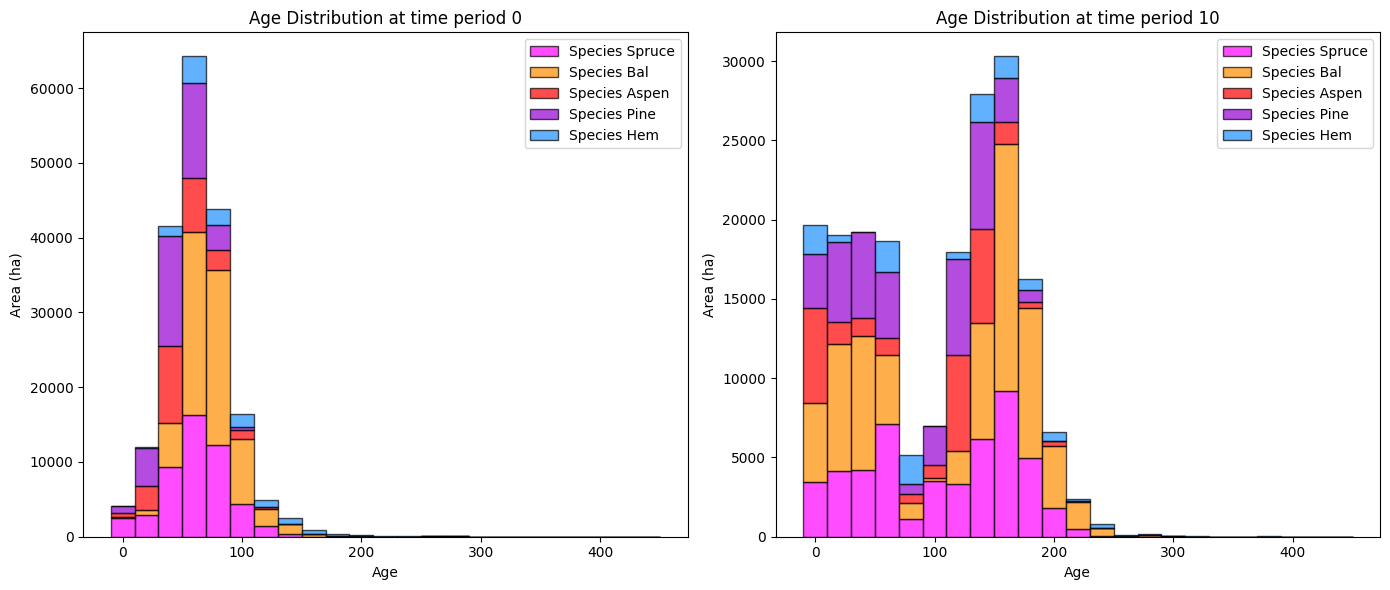

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4624.091497   4621.382963
Bal     278.565372  11130.044561  10851.479189
Aspen   273.490478   6117.315597   5843.825119
Pine      0.000000   3444.407631   3444.407631
Hem     419.699331   1309.461400    889.762069

Overall diversity has **increased** by 25650.86 hectares from time period 0 to time period 10.


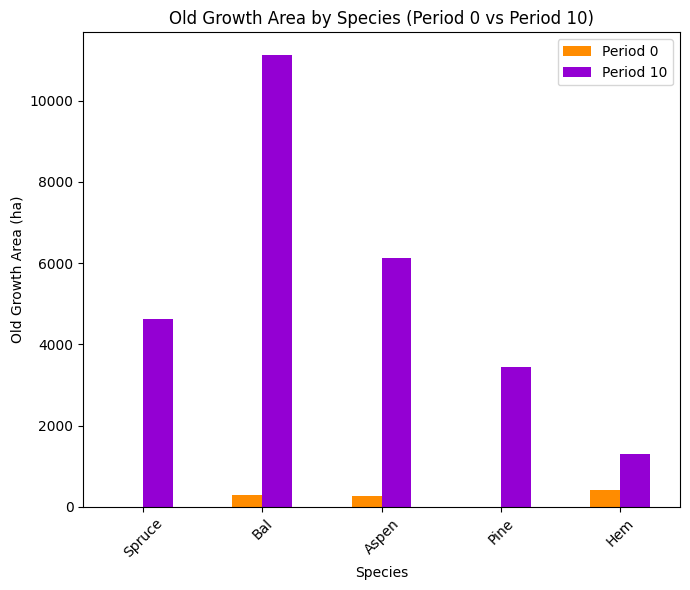

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2509
Bal: 0.3750
Aspen: 0.1338
Pine: 0.1506
Hem: 0.0896

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9228

Diversity has **decreased** by 2.27% from time 0 to time 10.


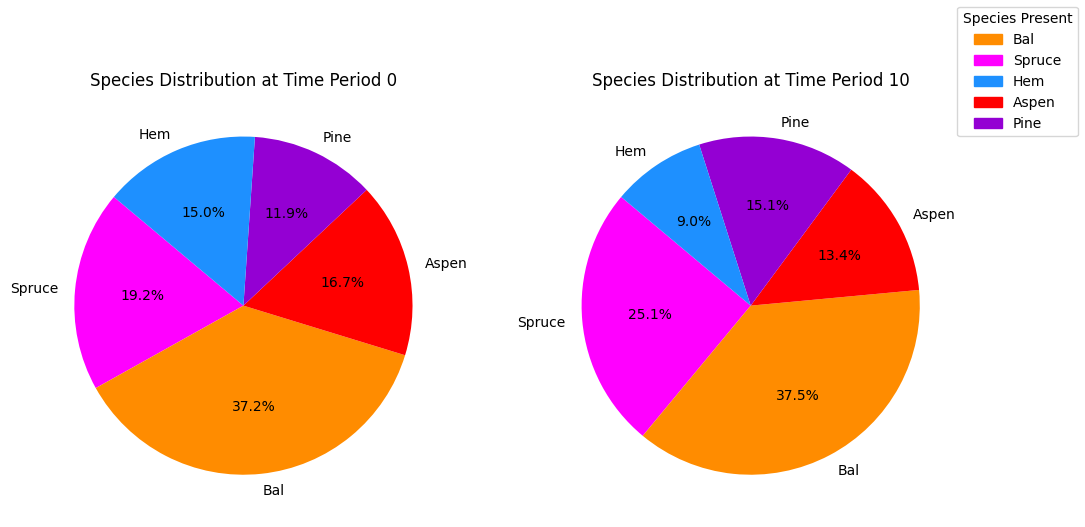

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_bau_gldbr_species_pie.pdf


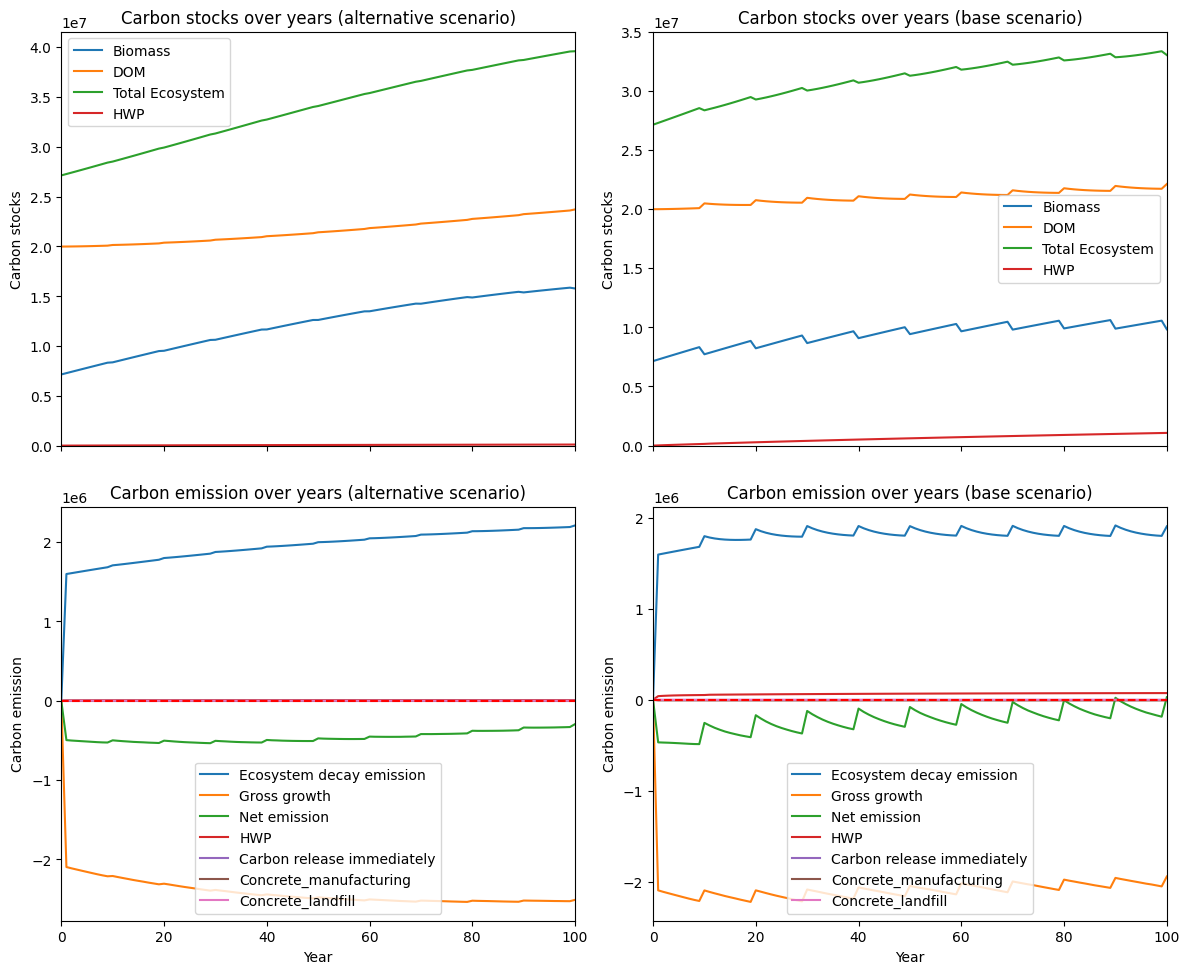

---------------------------------------------------------------------------------------
Net emission difference -3424360.599765166
Net emission base scenario -12382233.549800046
Net emission alternative scenario -8957872.950034881
dollar_per_ton is:  2.920253200169916
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  3162.632243  3162.632243
Bal     0.0  4636.823692  4636.823692
Aspen   0.0  6154.539810  6154.539810
Pine    0.0  3762.745392  3762.745392
Hem     0.0  2427.789259  2427.789259

Overall, the old growth area has **increased** by 20144.53 hectares in the alternative scenario compared to the base scenario.


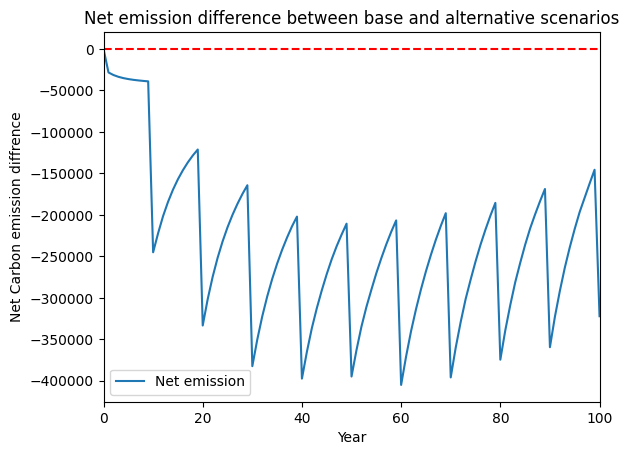

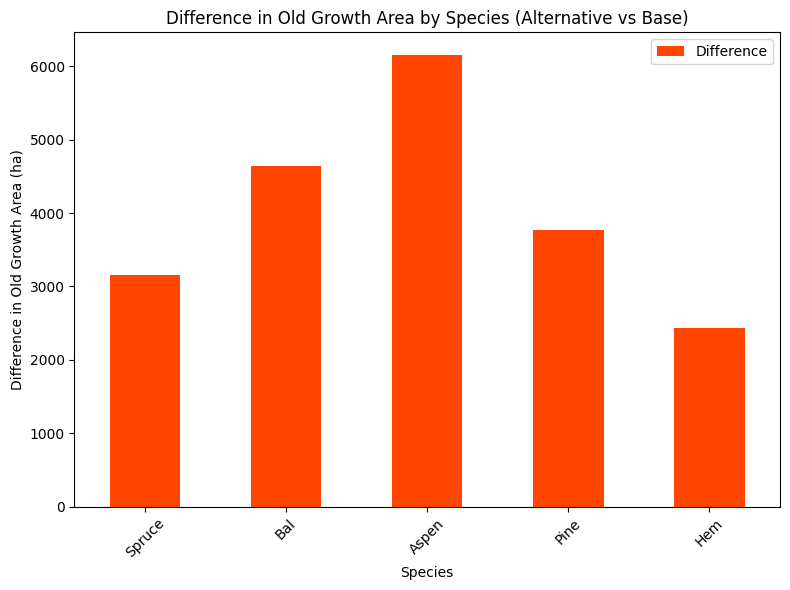

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_age_difference.pdf


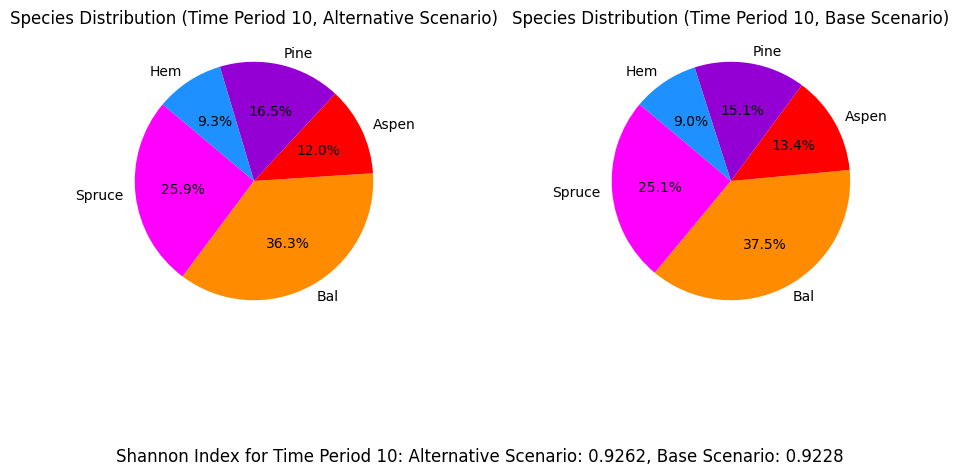

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
It took 100.3 minutes to run all scenarios.


In [12]:
Start = time.time()
scenario_names = scenario_options.get(case_study, [])
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=True, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

In [13]:
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")

It took 100.3 minutes to run this script.
